# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [4]:
# your code here
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')

In [5]:
# review the data types
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [6]:
# check for duplicate rows
len(bikes_df_raw.drop_duplicates(['dteday', 'hour'])) - len(bikes_df_raw)

0

In [7]:
# show overview of data
bikes_df_raw.describe()

season          hour       holiday       weekday    workingday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640     11.546752      0.028770      3.003683      0.682721   
std        1.106918      6.914405      0.167165      2.005771      0.465431   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      6.000000      0.000000      1.000000      0.000000   
50%        3.000000     12.000000      0.000000      3.000000      1.000000   
75%        3.000000     18.000000      0.000000      5.000000      1.000000   
max        4.000000     23.000000      1.000000      6.000000      1.000000   

            weather          temp         atemp           hum     windspeed  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       1.425283      0.496987      0.475775      0.627229      0.190098   
std        0.639357      0.192556      0.171850      0.192930      0.122340   
min        1.000000      0.020000      0.000000      0.000000      0.000000   
25%        1.000000      0.340000      0.333300      0.480000      0.104500   
50%        1.000000      0.500000      0.484800      0.630000      0.194000   
75%        2.000000      0.660000      0.621200      0.780000      0.253700   
max        4.000000      1.000000      1.000000      1.000000      0.850700   

             casual    registered  
count  17379.000000  17379.000000  
mean      35.676218    153.786869  
std       49.305030    151.357286  
min        0.000000      0.000000  
25%        4.000000     34.000000  
50%       17.000000    115.000000  
75%       48.000000    220.000000  
max      367.000000    886.000000

**ANSWER**

The temp, atemp, humidy and windspeed are normalized so its hard to make a direct interpretation of these values related to their natural values.

We need to note that the first hour of the day is 0 and 23 is the last hour.

Holiday and workingday are boolean while weeday represents the day of the week where 0 is Sunday.


**1.2 Notice that the variable in column...**

In [8]:
# your code here

# Convert datetime column to datetime format
bikes_df_raw.loc[:,'dteday'] = pd.to_datetime(bikes_df_raw.loc[:,'dteday'])

In [9]:
# Review the data types again to ensure the change was made as expected
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

In [10]:
# your code here

# append year, month, counts columns

# insert a new series with year so 2011 is 0 and 2012 is 1
year_col = pd.Series([y.year for y in bikes_df_raw['dteday']])
min_year = min(year_col)
bikes_df_raw.insert(1, "year", [y-min_year for y in year_col], False)

# insert a new series with the month so Jan is 1.
bikes_df_raw.insert(2, "month", [y.month for y in bikes_df_raw['dteday']] , False)

# insert a counts column where the column is the sum of casual and registered users
bikes_df_raw.insert(15, "counts", bikes_df_raw['casual'] + bikes_df_raw['registered'], False)

In [11]:
# review data
bikes_df_raw.head()

dteday  year  month  season  hour  holiday  weekday  workingday  \
0 2011-01-01     0      1       1     0        0        6           0   
1 2011-01-01     0      1       1     1        0        6           0   
2 2011-01-01     0      1       1     2        0        6           0   
3 2011-01-01     0      1       1     3        0        6           0   
4 2011-01-01     0      1       1     4        0        6           0   

   weather  temp   atemp   hum  windspeed  casual  registered  counts  
0        1  0.24  0.2879  0.81        0.0       3          13      16  
1        1  0.22  0.2727  0.80        0.0       8          32      40  
2        1  0.22  0.2727  0.80        0.0       5          27      32  
3        1  0.24  0.2879  0.75        0.0       3          10      13  
4        1  0.24  0.2879  0.75        0.0       0           1       1

In [12]:
bikes_df_raw.tail()

dteday  year  month  season  hour  holiday  weekday  workingday  \
17374 2012-12-31     1     12       1    19        0        1           1   
17375 2012-12-31     1     12       1    20        0        1           1   
17376 2012-12-31     1     12       1    21        0        1           1   
17377 2012-12-31     1     12       1    22        0        1           1   
17378 2012-12-31     1     12       1    23        0        1           1   

       weather  temp   atemp   hum  windspeed  casual  registered  counts  
17374        2  0.26  0.2576  0.60     0.1642      11         108     119  
17375        2  0.26  0.2576  0.60     0.1642       8          81      89  
17376        1  0.26  0.2576  0.60     0.1642       7          83      90  
17377        1  0.26  0.2727  0.56     0.1343      13          48      61  
17378        1  0.26  0.2727  0.65     0.1343      12          37      49

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.7.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

In [13]:
# show data set for reference
bikes_df_raw.head()

dteday  year  month  season  hour  holiday  weekday  workingday  \
0 2011-01-01     0      1       1     0        0        6           0   
1 2011-01-01     0      1       1     1        0        6           0   
2 2011-01-01     0      1       1     2        0        6           0   
3 2011-01-01     0      1       1     3        0        6           0   
4 2011-01-01     0      1       1     4        0        6           0   

   weather  temp   atemp   hum  windspeed  casual  registered  counts  
0        1  0.24  0.2879  0.81        0.0       3          13      16  
1        1  0.22  0.2727  0.80        0.0       8          32      40  
2        1  0.22  0.2727  0.80        0.0       5          27      32  
3        1  0.24  0.2879  0.75        0.0       3          10      13  
4        1  0.24  0.2879  0.75        0.0       0           1       1

In [14]:
# create new dataframe grouping by day and calculating respective columns
bikes_by_day = bikes_df_raw.groupby(['dteday']).agg({
        'weekday':'mean',
        'weather':'mean',    
        'season':'mean',
        'temp':'mean',
        'atemp':'mean',
        'windspeed':'mean',
        'hum':'mean',
        'casual':'sum',
        'registered':'sum',
        'counts':'sum'
    })

bikes_by_day.head()

weekday   weather  season      temp     atemp  windspeed  \
dteday                                                                 
2011-01-01        6  1.583333       1  0.344167  0.363625   0.160446   
2011-01-02        0  1.956522       1  0.363478  0.353739   0.248539   
2011-01-03        1  1.000000       1  0.196364  0.189405   0.248309   
2011-01-04        2  1.043478       1  0.200000  0.212122   0.160296   
2011-01-05        3  1.000000       1  0.226957  0.229270   0.186900   

                 hum  casual  registered  counts  
dteday                                            
2011-01-01  0.805833     331         654     985  
2011-01-02  0.696087     131         670     801  
2011-01-03  0.437273     120        1229    1349  
2011-01-04  0.590435     108        1454    1562  
2011-01-05  0.436957      82        1518    1600

In [15]:
bikes_by_day.tail()

weekday   weather  season      temp     atemp  windspeed  \
dteday                                                                 
2012-12-27        4  1.666667       1  0.254167  0.226642   0.350133   
2012-12-28        5  1.708333       1  0.253333  0.255046   0.155471   
2012-12-29        6  2.041667       1  0.253333  0.242400   0.124383   
2012-12-30        0  1.333333       1  0.255833  0.231700   0.350754   
2012-12-31        1  1.500000       1  0.215833  0.223488   0.154846   

                 hum  casual  registered  counts  
dteday                                            
2012-12-27  0.652917     247        1867    2114  
2012-12-28  0.590000     644        2451    3095  
2012-12-29  0.752917     159        1182    1341  
2012-12-30  0.483333     364        1432    1796  
2012-12-31  0.577500     439        2290    2729

In [16]:
# make sure my datatypes are as expected
# I didn't take the min or max of season and weekday on purspose when aggregating
# Using the mean would create a float for the column if any single point was not consistent within a day
# If they are all the same, then I should see integer types for these columns
bikes_by_day.dtypes

weekday         int64
weather       float64
season          int64
temp          float64
atemp         float64
windspeed     float64
hum           float64
casual          int64
registered      int64
counts          int64
dtype: object

In [17]:
# casual and registered riders by day of week
bikes_by_weekday = bikes_by_day.groupby(['weekday']).agg({
        'casual':'sum',
        'registered':'sum',
        'counts':'sum'
    })

bikes_by_weekday

casual  registered  counts
weekday                            
0        140521      303506  444027
1         70784      384719  455503
2         57843      411266  469109
3         57319      415729  473048
4         61460      423935  485395
5         78238      409552  487790
6        153852      323955  477807

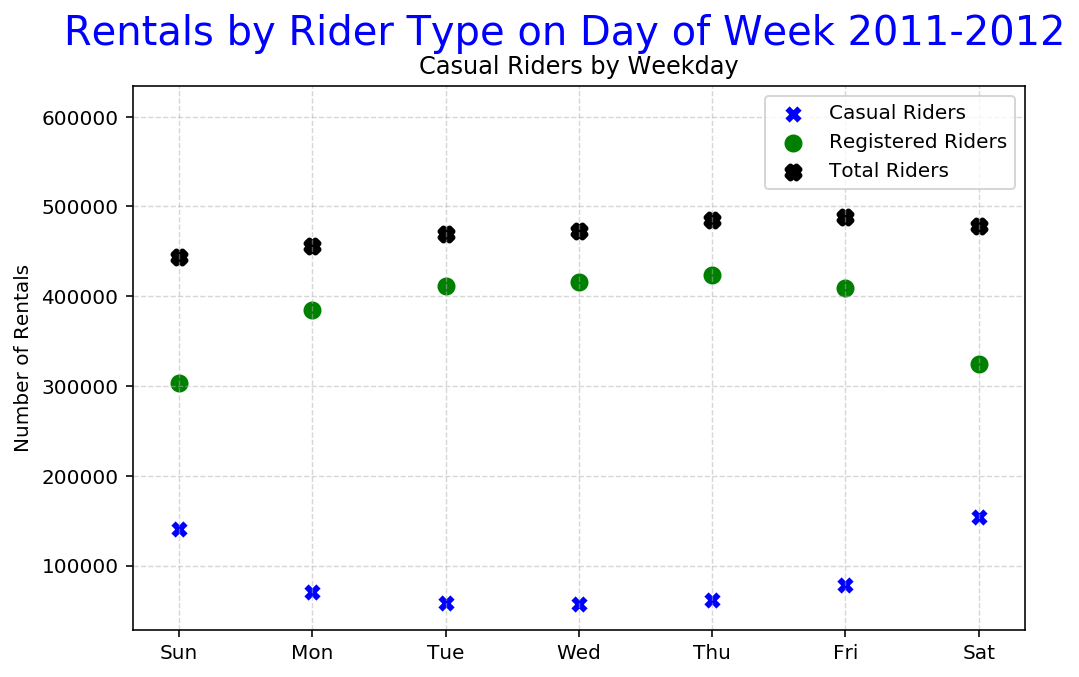

In [18]:
# Basic Scatterplot to see general weekday trend
# plot casual, register and total riders
fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
fig.suptitle("Rentals by Rider Type on Day of Week 2011-2012", fontsize=20, c='b')

max = np.amax(bikes_by_weekday.values)
min = np.min(bikes_by_weekday.values)
xlabels = ['','Sun', 'Mon', 'Tue','Wed', 'Thu', 'Fri', 'Sat']
lw = 3

subplot.scatter(bikes_by_weekday.index.values,bikes_by_weekday['casual'], label="Casual Riders", c='b', marker='x', lw=lw)
subplot.scatter(bikes_by_weekday.index.values,bikes_by_weekday['registered'], label="Registered Riders", c='g', marker='o', lw=lw)
subplot.scatter(bikes_by_weekday.index.values,bikes_by_weekday['counts'], label="Total Riders", c='black', marker='X', lw=lw)
subplot.set_ylim(min/2,max*1.3)
subplot.set_title("Casual Riders by Weekday")
subplot.set_ylabel("Number of Rentals")
subplot.set_xticklabels(xlabels)
subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
subplot.legend()

plt.show()

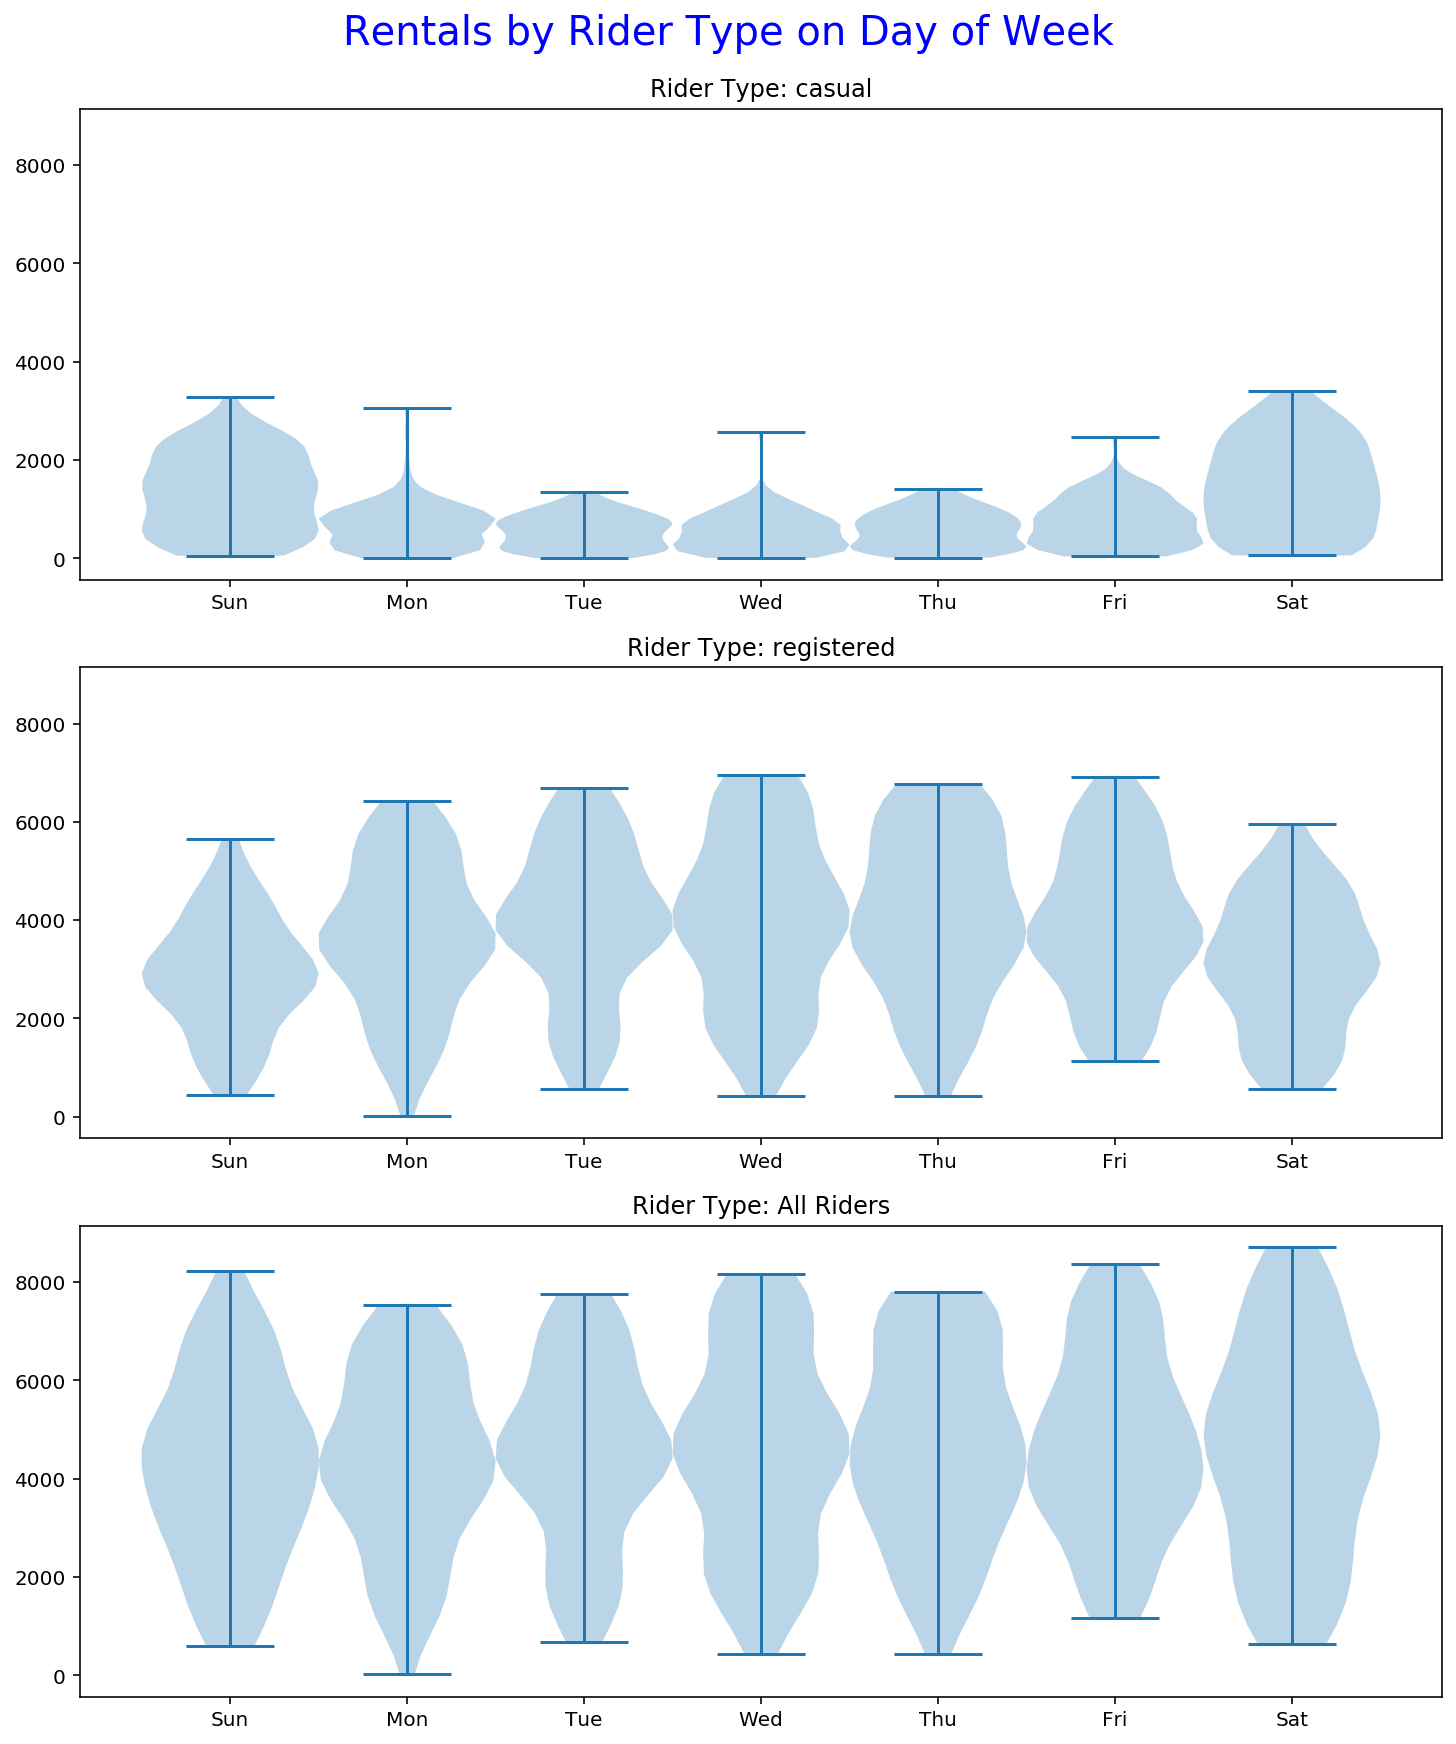

In [19]:
# Violin plots to see distribution

# plot casual, register and total riders
weekdays = ['', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat']
weekday_n = [0,1,2,3,4,5,6]

fig, subplot = plt.subplots(nrows=3, ncols=1, figsize=(10,12), sharey=True, constrained_layout=True)
fig.suptitle("Rentals by Rider Type on Day of Week", fontsize=20, c='b')

r_type='casual'

for i, r_type in enumerate(['casual', 'registered', 'counts']):
    data = []
    for day in weekday_n:
        data.append(bikes_by_day[(bikes_by_day['weekday']==day)][r_type])

    ax = subplot[i]
    ax.violinplot(data, weekday_n, points=20, widths=1);
    ax.set_xticklabels(weekdays)
    ax.set_title("Rider Type: {}".format(r_type if r_type!='counts' else "All Riders"))


**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

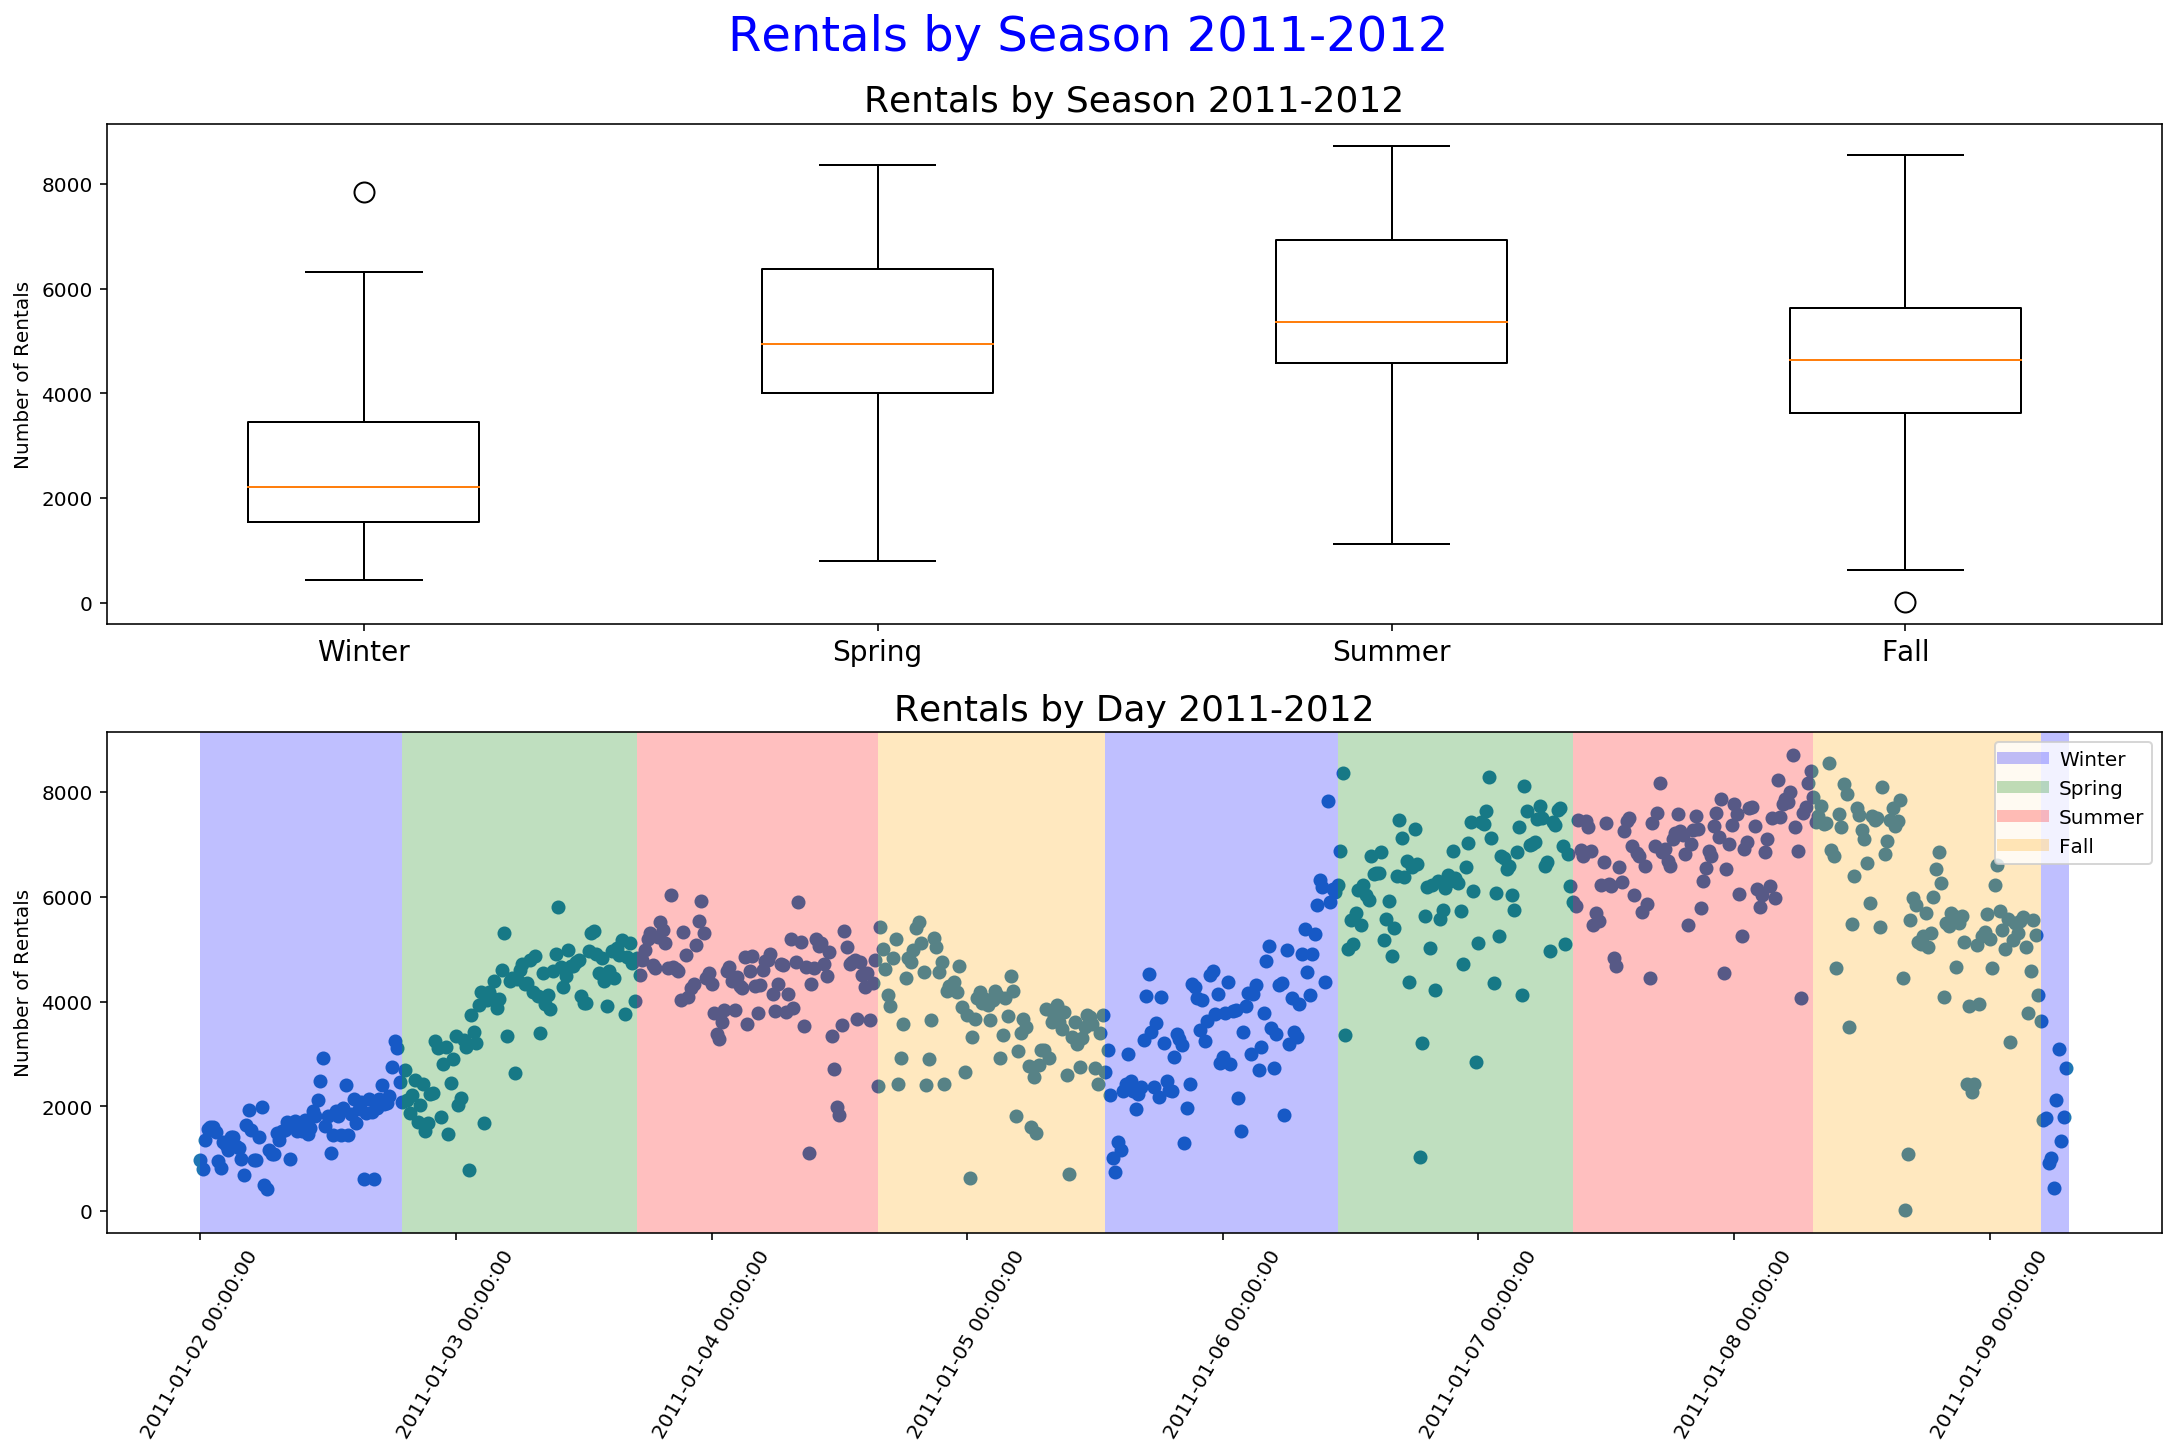

In [20]:
fig, subplot = plt.subplots(nrows=2, ncols=1, figsize=(15,10), constrained_layout=True)
fig.suptitle("Rentals by Season 2011-2012", fontsize=24, c='b')

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
seas_colors = ['', 'blue', 'green', 'red', 'orange']


p = 0
s1 = bikes_by_day[bikes_by_day['season']==1]['counts'].values
s2 = bikes_by_day[bikes_by_day['season']==2]['counts'].values
s3 = bikes_by_day[bikes_by_day['season']==3]['counts'].values
s4 = bikes_by_day[bikes_by_day['season']==4]['counts'].values
flierdict = dict(marker="o", markersize=10, color='r')
results = subplot[p].boxplot((s1,s2,s3,s4), whis=1.5, flierprops=flierdict)
subplot[p].set_title("Rentals by Season 2011-2012", fontsize=18)
subplot[p].set_xticklabels(seasons, fontsize=14)
subplot[p].set_ylabel("Number of Rentals")

p = 1
xaxis = range(0,len(bikes_by_day))
background_alpha = 0.25

subplot[p].scatter(xaxis, bikes_by_day['counts'])
subplot[p].set_title("Rentals by Day 2011-2012", fontsize=18)
for i, row in enumerate(bikes_by_day.iterrows()):
    subplot[p].axvspan(i, i+1, facecolor=seas_colors[int(row[1]['season'])], alpha=background_alpha)
    
custom_legend = [plt.Line2D([0], [0], color='blue', lw=6, alpha=background_alpha),
                 plt.Line2D([0], [0], color='green', lw=6, alpha=background_alpha),
                 plt.Line2D([0], [0], color='red', lw=6, alpha=background_alpha),
                 plt.Line2D([0], [0], color='orange', lw=6, alpha=background_alpha)]
subplot[p].legend(custom_legend, seasons)
subplot[p].set_xticklabels(bikes_by_day.index, rotation=60)
subplot[p].set_ylabel("Number of Rentals")

plt.show()


In [21]:
# Identify dates of outliers
outlier_values = []
for i in results['fliers']:
    if len(i.get_xydata()):
        print("Season: {}  Outlier Value: {}".format(i.get_xydata()[0][0],i.get_xydata()[0][1]))
        outlier_values.append(i.get_xydata()[0][1])


Season: 1.0  Outlier Value: 7836.0
Season: 4.0  Outlier Value: 22.0


In [22]:
outlier_dates = []
for v in outlier_values:
    day = bikes_by_day[bikes_by_day['counts']==v].index.values[0]
    outlier_dates.append(day)
outlier_dates

[numpy.datetime64('2012-03-17T00:00:00.000000000'),
 numpy.datetime64('2012-10-29T00:00:00.000000000')]

In [23]:
# Display Outlier Observations
bikes_by_day.loc[outlier_dates]

weekday  weather  season      temp     atemp  windspeed       hum  \
dteday                                                                          
2012-03-17        6      1.5       1  0.514167  0.505046   0.110704  0.755833   
2012-10-29        1      3.0       4  0.440000  0.439400   0.358200  0.880000   

            casual  registered  counts  
dteday                                  
2012-03-17    3155        4681    7836  
2012-10-29       2          20      22

**Outliers**
We note 3/17/2012 and 10/29/2012 as outliers.

3/17/12 - Warmest date on record at the time would very likely lead to a huge increase in ridership especially since this is in Spring after people have spent a Winter indoors and cold.  Additionally, this is St. Patick's day which may have added to the number of rentals.

10/29/12 - Washinton DC shutdown in preparation for hurricane Sandy.  It is reasonable that there were virtually no riders on this day.

Since the ridership numbers can be substantiated on these dates, they are most likely true outliers and not errors.

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

In [24]:
# setup one-hot series for each predictor and append to raw data
# drop first categorical indicator column - lack of any other indicator will indicate the dropped column is true

season_onehot = pd.get_dummies(bikes_df_raw['season']).drop([1], axis=1)
season_onehot = season_onehot.rename(columns={2:'spring', 3:'summer', 4:'fall'})

month_onehot = pd.get_dummies(bikes_df_raw['month']).drop([1], axis=1)
month_onehot = month_onehot.rename(columns={2:'february', 3:'march', 4:'april', 5:'may', 6:'june', 7:'july', 8:'august', 9:'september', 10:'october', 11:'movember', 12:'december'})

weekday_onehot = pd.get_dummies(bikes_df_raw['weekday']).drop([0], axis=1)
weekday_onehot = weekday_onehot.rename(columns={1:'monday', 2:'tuesday', 3:'wednesday',4:'thursday',5:'friday',6:'saturday'})

weather_onehot = pd.get_dummies(bikes_df_raw['weather']).drop([1], axis=1)
weather_onehot = weather_onehot.rename(columns={2:'cloudy', 3:'light_precip', 4:'heavy_precip'})

# add one-hot columns to raw dataframe
bikes_df = pd.concat([bikes_df_raw, season_onehot, month_onehot, weekday_onehot, weather_onehot], axis=1)

# drop original categorical columns - except hour, since we will use it later
bikes_df.drop(['season','weekday','weather'], axis=1, inplace=True)


**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.

In [25]:
bikes_df.head()

dteday  year  month  hour  holiday  workingday  temp   atemp   hum  \
0 2011-01-01     0      1     0        0           0  0.24  0.2879  0.81   
1 2011-01-01     0      1     1        0           0  0.22  0.2727  0.80   
2 2011-01-01     0      1     2        0           0  0.22  0.2727  0.80   
3 2011-01-01     0      1     3        0           0  0.24  0.2879  0.75   
4 2011-01-01     0      1     4        0           0  0.24  0.2879  0.75   

   windspeed  ...  december  monday  tuesday  wednesday  thursday  friday  \
0        0.0  ...         0       0        0          0         0       0   
1        0.0  ...         0       0        0          0         0       0   
2        0.0  ...         0       0        0          0         0       0   
3        0.0  ...         0       0        0          0         0       0   
4        0.0  ...         0       0        0          0         0       0   

   saturday  cloudy  light_precip  heavy_precip  
0         1       0             0             0  
1         1       0             0             0  
2         1       0             0             0  
3         1       0             0             0  
4         1       0             0             0  

[5 rows x 36 columns]

In [26]:
# Split dataset ensuring that months are equally represented in both the train and test dataset
bikes_train, bikes_test = train_test_split(bikes_df, 
                                           test_size=.5, 
                                           random_state=90, 
                                           shuffle=True, 
                                           stratify=bikes_df['month'])

In [27]:
# Test to see that a month has equal representation in both sets
m_to_test=8
len(bikes_train[bikes_train['month']==m_to_test])/len(bikes_train), \
len(bikes_test[bikes_test['month']==m_to_test])/len(bikes_test)

(0.0848198872137185, 0.08492520138089758)

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

In [28]:
# your code here
# Read in date ensuring that data is sorted by date before removing date column
BSS_train = pd.read_csv('data/BSS_train.csv').sort_values(by=['dteday']).reset_index(drop=True).drop('dteday', axis=1)
BSS_test = pd.read_csv('data/BSS_test.csv').sort_values(by=['dteday']).reset_index(drop=True).drop('dteday', axis=1)

BSS_test.head()

hour  holiday  year  workingday  temp   atemp   hum  windspeed  casual  \
0    19        0     0           0  0.42  0.4242  0.88     0.2537       6   
1     2        0     0           0  0.22  0.2727  0.80     0.0000       5   
2     9        0     0           0  0.32  0.3485  0.76     0.0000       8   
3    13        0     0           0  0.46  0.4545  0.72     0.2985      47   
4     5        0     0           0  0.24  0.2576  0.75     0.0896       0   

   registered  ...  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0          31  ...    0    0    0    0    0    0    1       0     1      0  
1          27  ...    0    0    0    0    0    0    1       0     0      0  
2           6  ...    0    0    0    0    0    0    1       0     0      0  
3          47  ...    0    0    0    0    0    0    1       1     0      0  
4           1  ...    0    0    0    0    0    0    1       1     0      0  

[5 rows x 34 columns]

In [29]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [30]:
BSS_train.head()

hour  holiday  year  workingday  temp   atemp   hum  windspeed  casual  \
0    22        0     0           0  0.40  0.4091  0.94     0.2239      11   
1    14        0     0           0  0.46  0.4545  0.72     0.2836      35   
2     4        0     0           0  0.24  0.2879  0.75     0.0000       0   
3    21        0     0           0  0.40  0.4091  0.87     0.1940       3   
4    20        0     0           0  0.40  0.4091  0.87     0.2537      11   

   registered  ...  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0          17  ...    0    0    0    0    0    0    1       1     0      0  
1          71  ...    0    0    0    0    0    0    1       1     0      0  
2           1  ...    0    0    0    0    0    0    1       0     0      0  
3          31  ...    0    0    0    0    0    0    1       1     0      0  
4          25  ...    0    0    0    0    0    0    1       1     0      0  

[5 rows x 34 columns]

In [31]:
# Raw data of Obersations
def plot_rawdata(x_train:pd.DataFrame, x_val:pd.DataFrame) -> None:
    # Figure Setup and Title
    fig , subplot = plt.subplots(nrows=2, ncols=1, figsize=(12,8), constrained_layout=True)  # (rows, columns)
    fig.suptitle("Raw Data - Riders for each Hour 2011-2012", fontsize=20, color='darkblue')

    for i, data in enumerate((BSS_train, BSS_test)):

        # plot actual data
        subplot[i].scatter(data.index.values, data.counts.values, marker='*', s=2, color='lightgrey', label="Actual Rentals")

        # Subplot Axes Labels, Titles and Legends
        subplot[i].set_xlabel("Hour from 12:00am Jan, 1, 2011", fontsize=14)
        subplot[i].set_ylabel("Number of Rentals", fontsize=14)
        subplot[i].set_title("{} Data".format("Test" if i%2 else "Train"), fontsize=16)
        subplot[i].legend(loc='best', fontsize=16)
        subplot[i].tick_params(labelsize=12) # Update ticklabel size

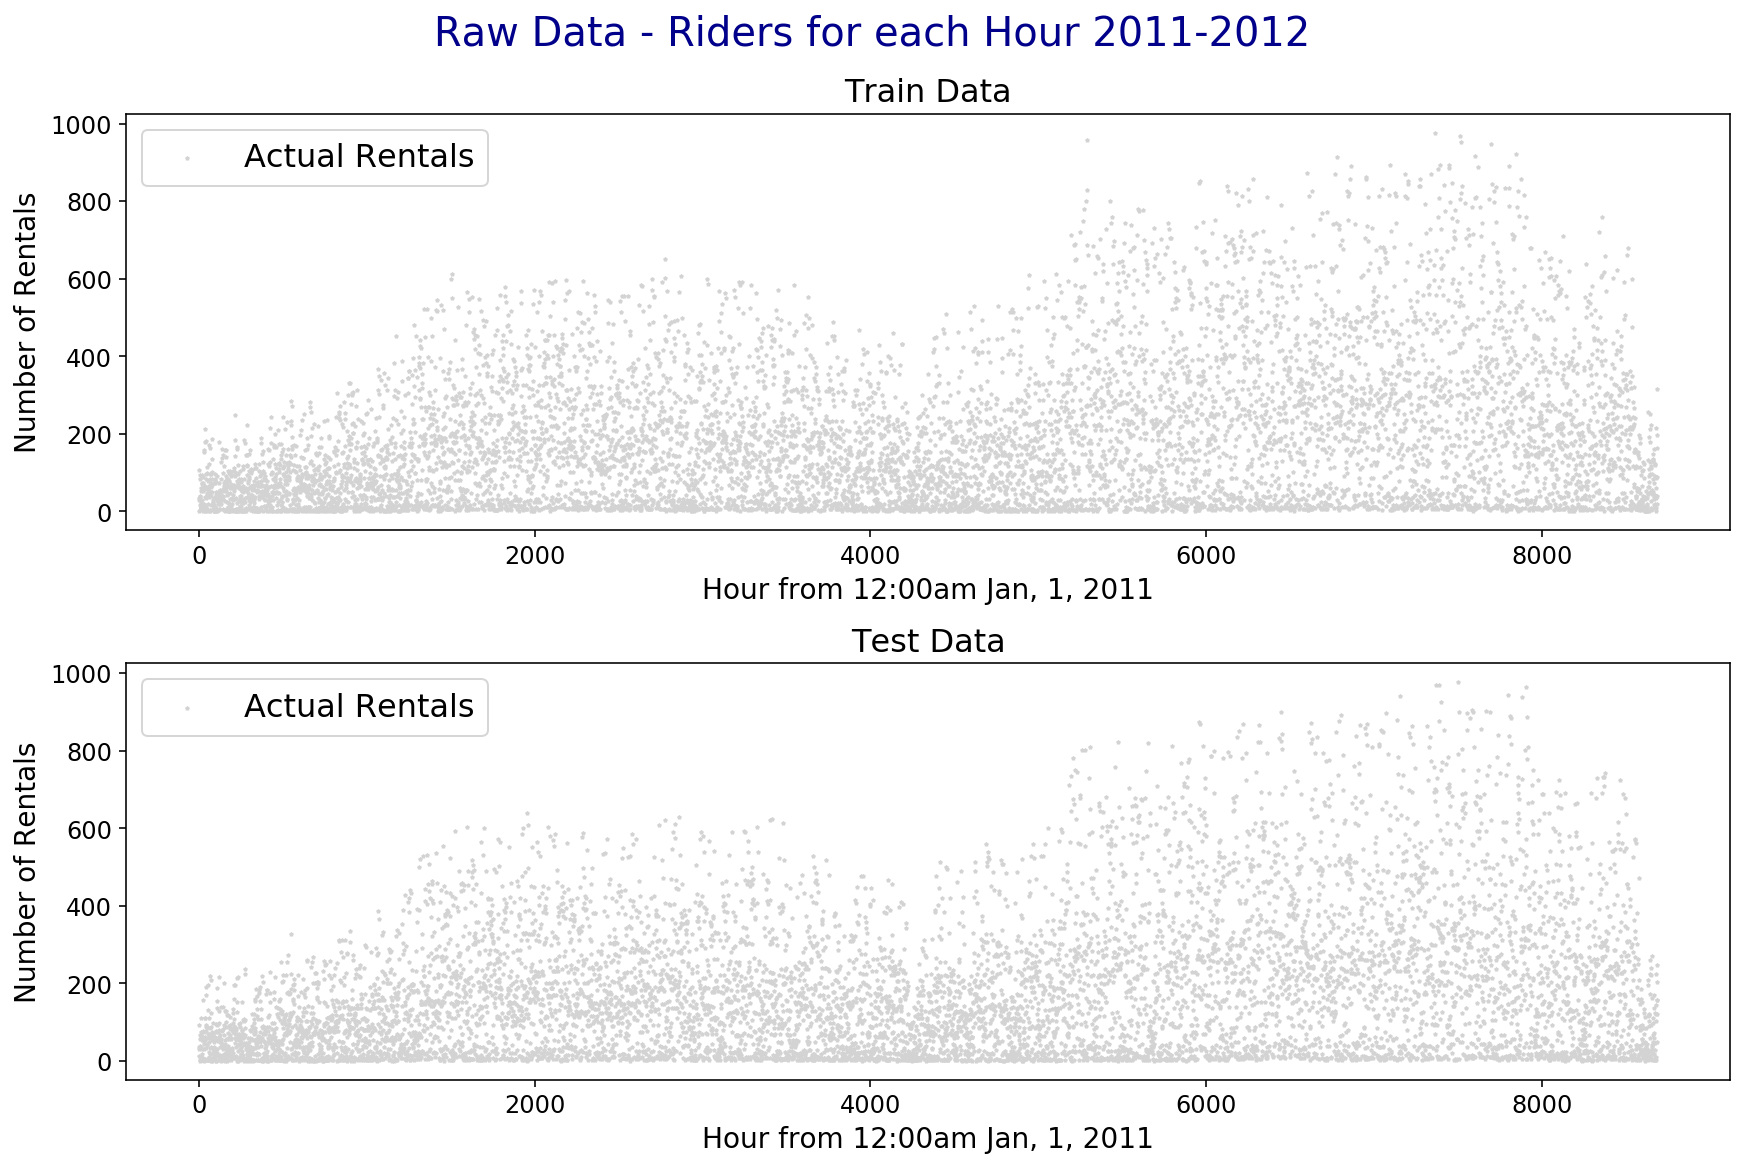

In [32]:
plot_rawdata(BSS_train, BSS_test)

Plotting the raw data helps ensure we have two separate sets of data and helps highlight some overall trends with the data.

We can observe that the second year has increased ridership and that within each year, ridership varies by season.

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

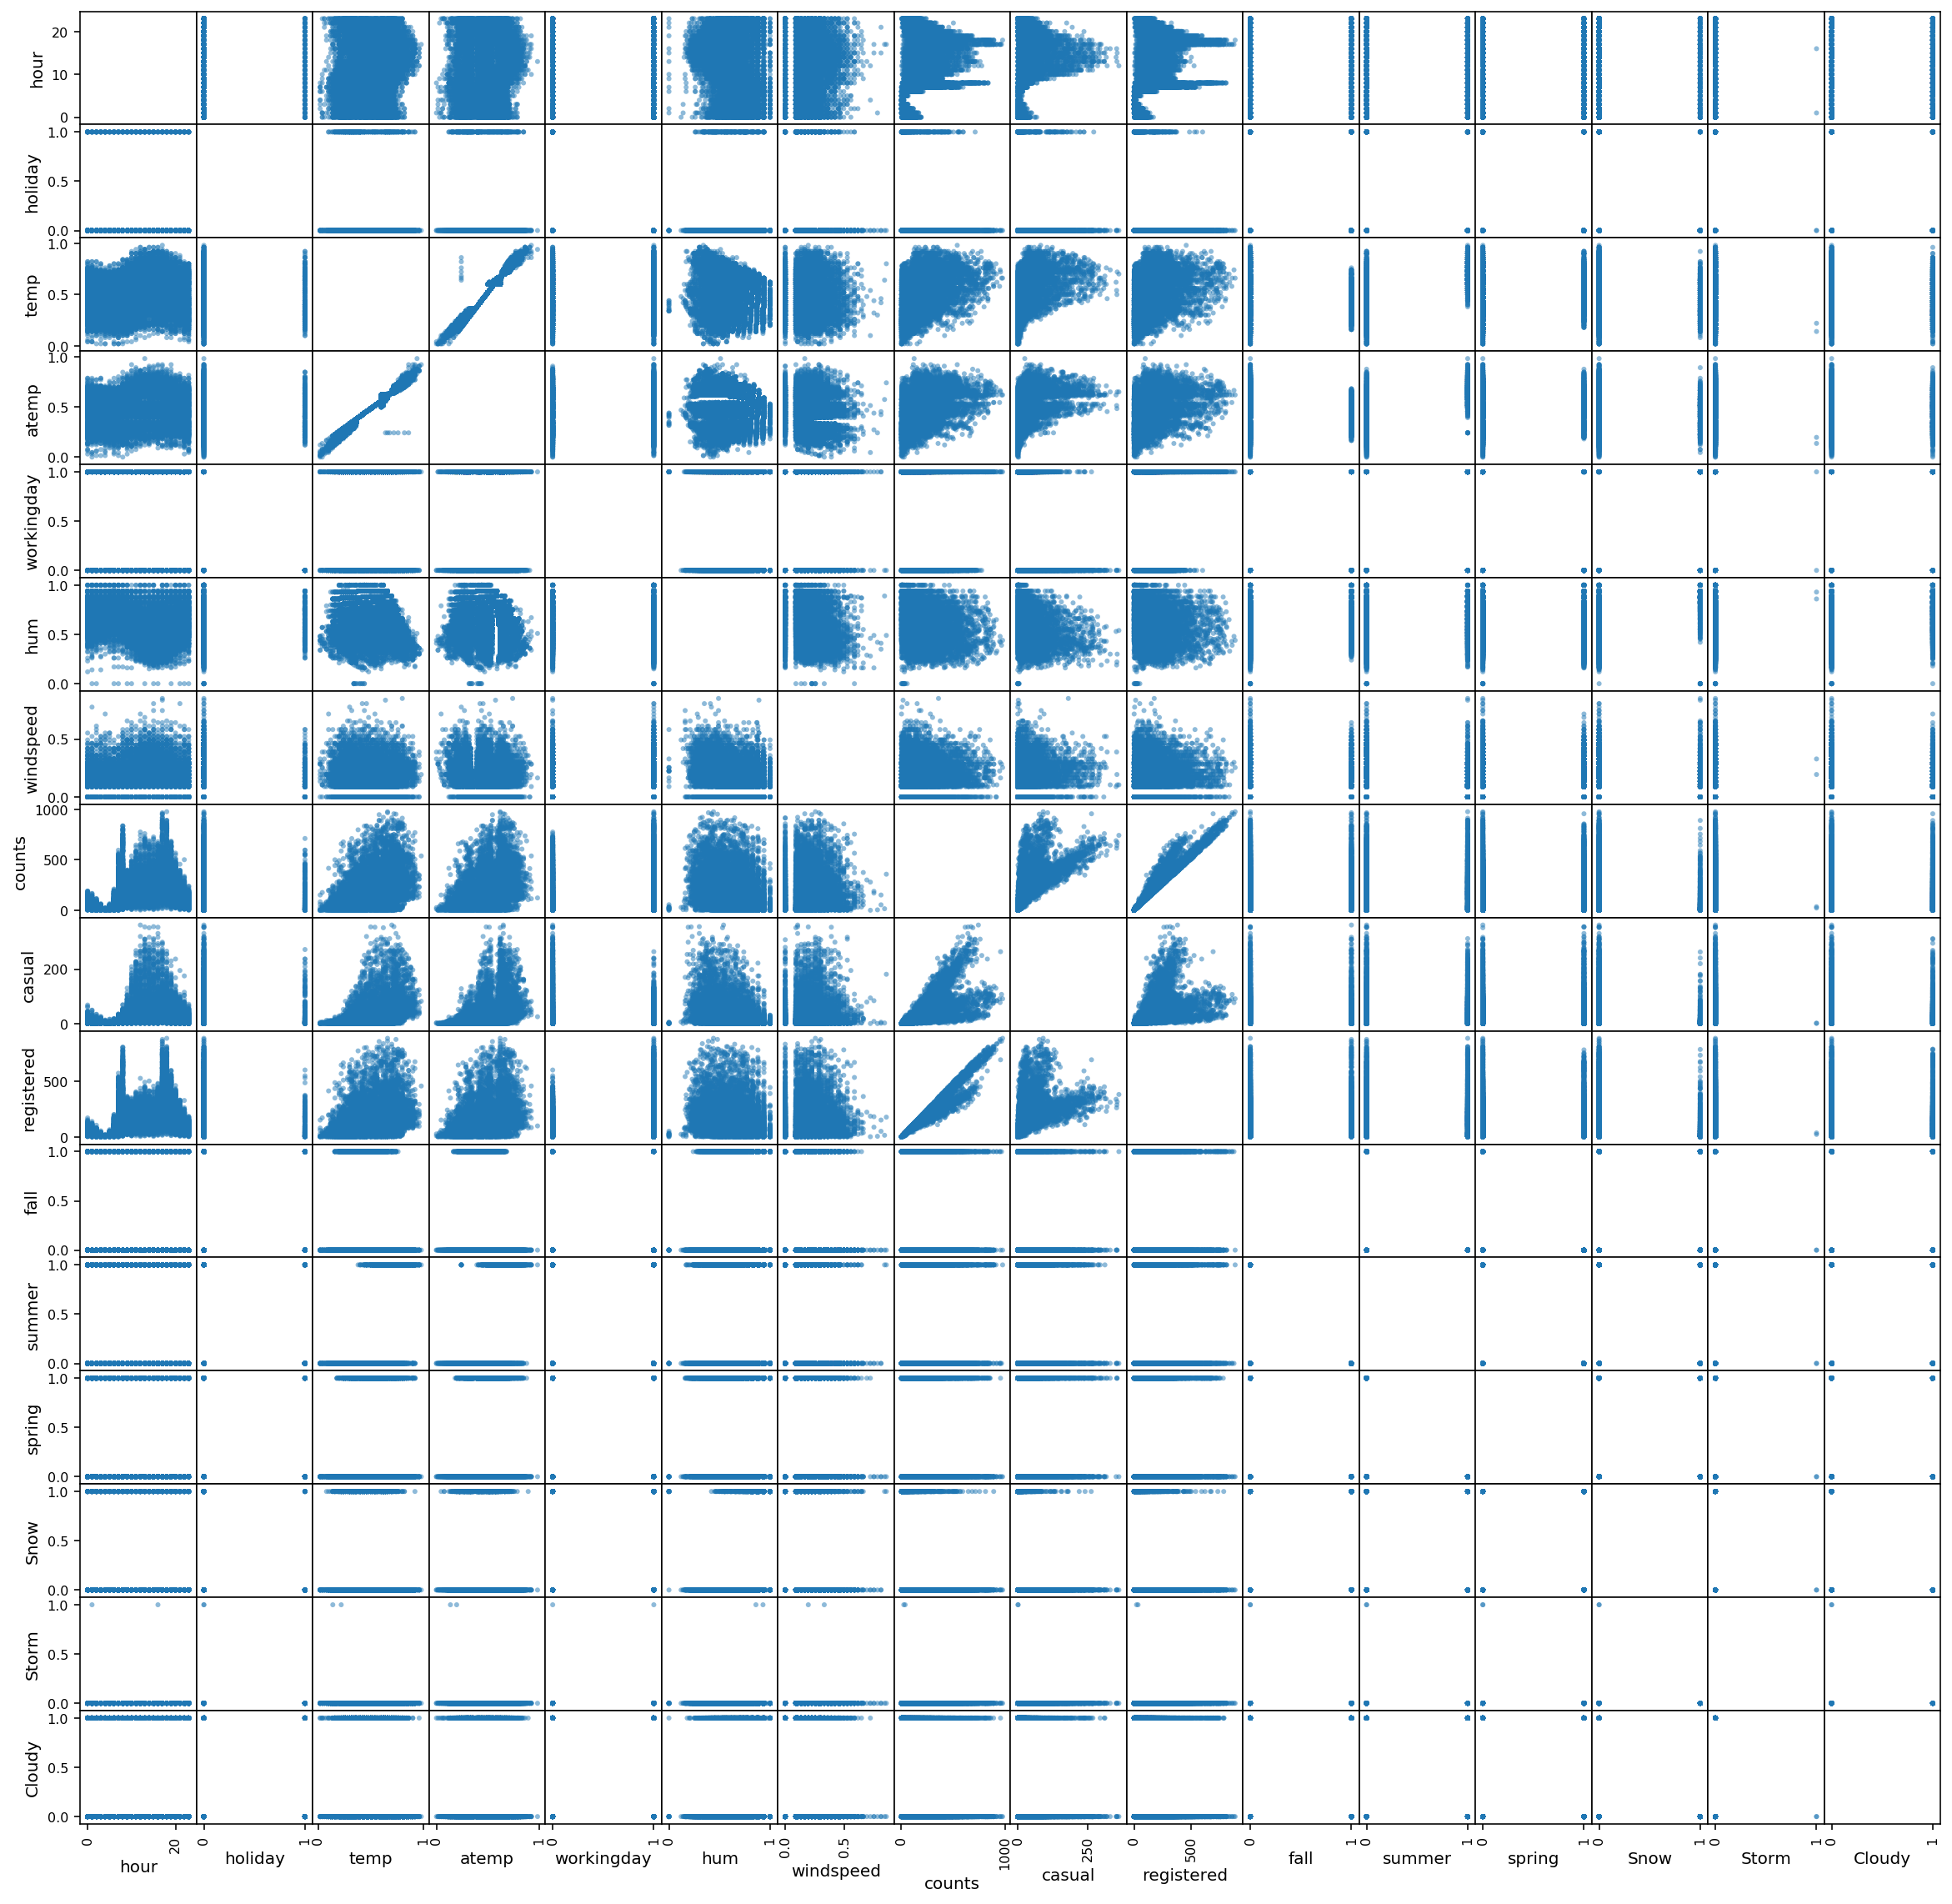

In [33]:
# your code here
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']

# Comment-out to avoid long calculation delay
pd.plotting.scatter_matrix(BSS_train[cor_columns], figsize=(20,20), diagonal={'kde'}, range_padding=.15)
plt.show()

Moving along the x-axis:

Hour:
    Rider counts change with respect to hour over the course of the day in a regular pattern.
    
Temperature:
    We see a general increase in couts as temperature increases up to a point when it drops.
    Directly related to aTemp, so one is redunant.
    
Windspeed:
    At high windspeeds, ridership falls off.
    
Workingday:
    We can see that there tend to be more casual riders on non-working days.
    More registered riders on workingdays.
    
Counts:
    Clearly relational to casual and registered counts.
    We can see that casual counts have two trends. Likely weekdays and weekends with differnt rates.
    There is a small indication that registered riders have the same double-trend.
   

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

In [34]:
# your code here
bikes_by_hour = BSS_train.groupby(['hour']).agg({
        'casual':'mean',
        'registered':'mean',
        'counts':'mean'
    })
bikes_by_hour.head()

casual  registered     counts
hour                                  
0     11.056980   43.774929  54.831909
1      6.357513   26.116580  32.474093
2      4.674863   17.877049  22.551913
3      2.798956    9.370757  12.169713
4      1.277286    5.011799   6.289086

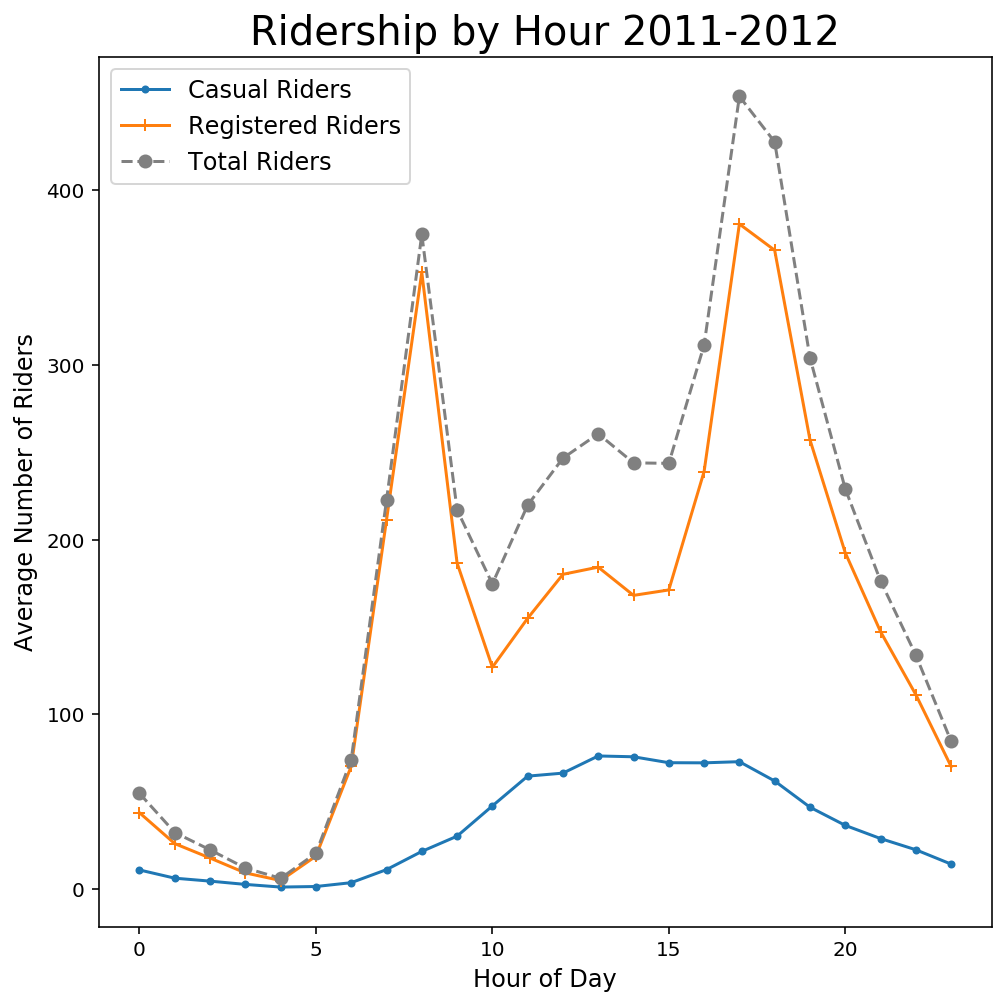

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.set_title("Ridership by Hour 2011-2012", fontsize=20)
ax.plot(bikes_by_hour.index, bikes_by_hour['casual'], label="Casual Riders", marker='.', ls='-')
ax.plot(bikes_by_hour.index, bikes_by_hour['registered'], label="Registered Riders", marker='+')
ax.plot(bikes_by_hour.index, bikes_by_hour['counts'], label="Total Riders", marker='o', c='grey', ls='--')
ax.set_xlabel("Hour of Day", fontsize=12)
ax.set_ylabel("Average Number of Riders", fontsize=12)
ax.legend(fontsize=12)
plt.show()

There are ridership peaks during morning and evening rush hours driven by usage from regsitered riders.  Conveniently, as the morning rush drops off, the number of casual riders peaks.  In the afternoon, the increase is registered rider rush hour traffic drives a huge spike in ridership that is mitigated as casual ridership drops before the rush period evenutally comes to an end.

We also note that registred riders have increased usage around lunch time.

Splitting this between weekends/holidays and weekdays would be helpful.

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.7.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

In [36]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

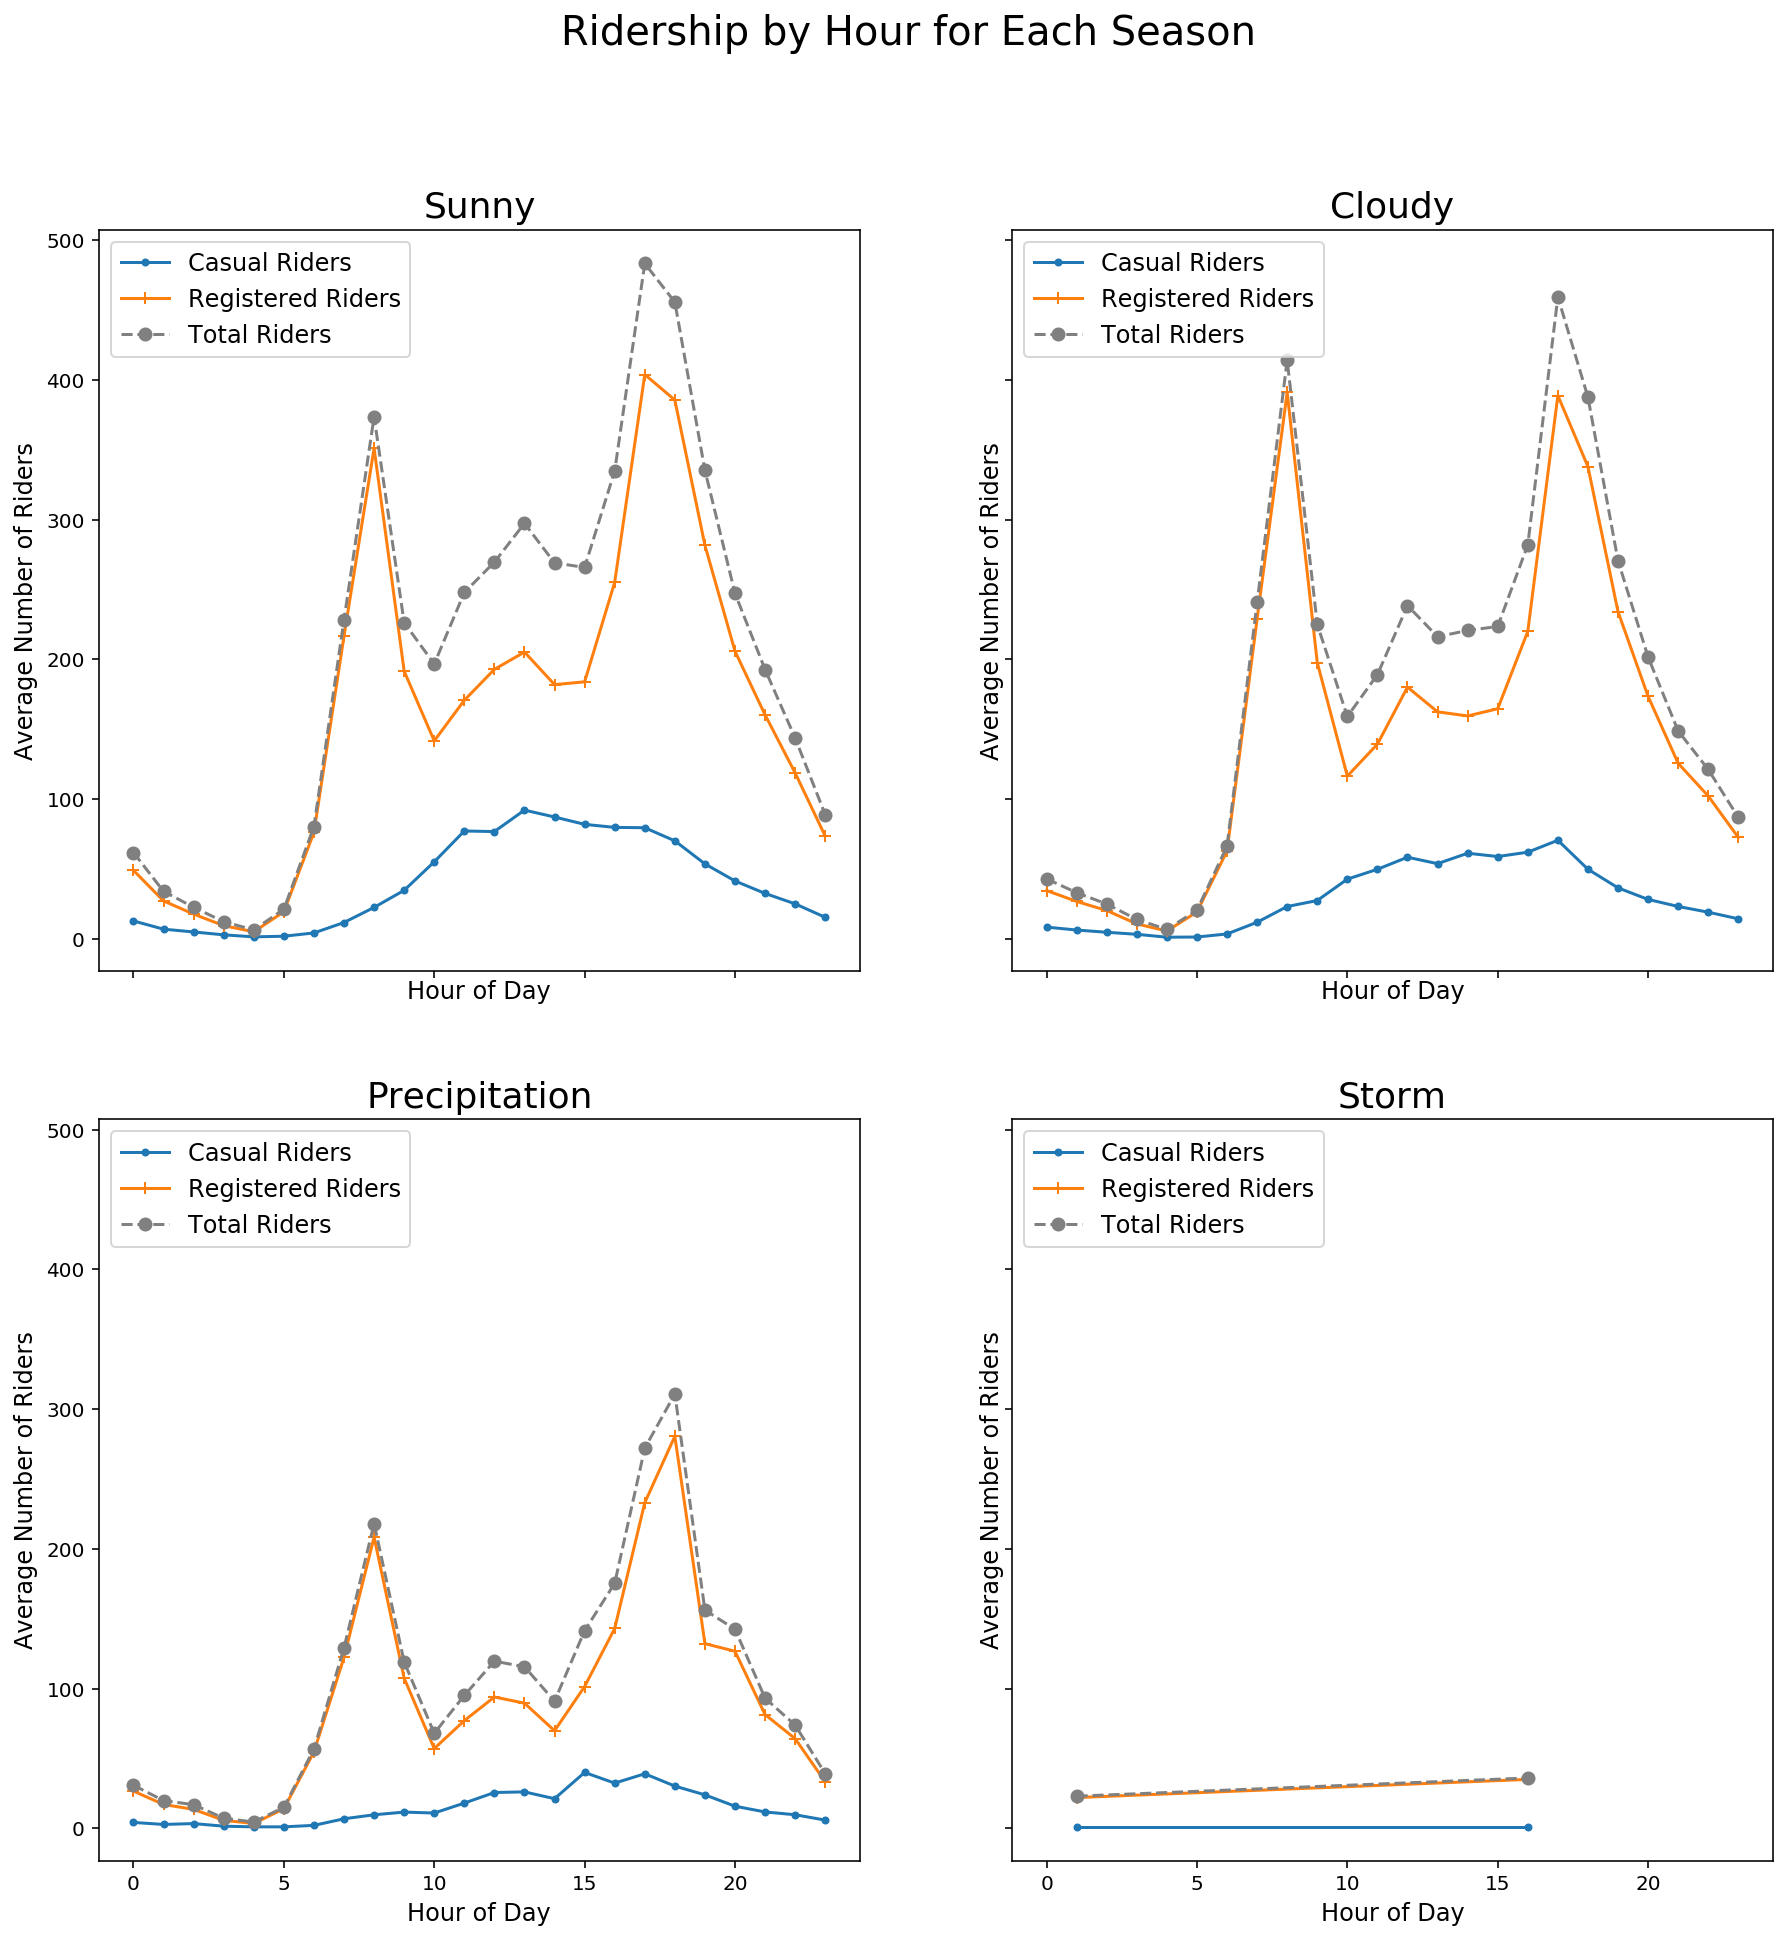

In [37]:

# ridership by weather category
weathers = (
    (BSS_train[(BSS_train['Cloudy']==0) & (BSS_train['Storm']==0) & (BSS_train['Snow']==0)], "Sunny"),
    (BSS_train[BSS_train['Cloudy']==1], "Cloudy"), 
    (BSS_train[BSS_train['Snow']==1],   "Precipitation"  ),
    (BSS_train[BSS_train['Storm']==1],  "Storm" )
)

fig, subplot = plt.subplots(nrows=2, ncols=2, figsize=(15,15), sharex=True, sharey=True)
fig.suptitle("Ridership by Hour for Each Season", fontsize=20)
pos = [(0,0),(0,1),(1,0),(1,1)]

for i, weather in enumerate(weathers):       
    frame = weather[0].groupby(['hour']).agg({
            'casual':'mean',
            'registered':'mean',
            'counts':'mean'
        })
    
    ax = subplot[pos[i][0]][pos[i][1]]
    ax.set_title(weather[1], fontsize=18)
    ax.plot(frame.index, frame['casual'], label="Casual Riders", marker='.', ls='-')
    ax.plot(frame.index, frame['registered'], label="Registered Riders", marker='+')
    ax.plot(frame.index, frame['counts'], label="Total Riders", marker='o', c='grey', ls='--')
    ax.set_xlabel("Hour of Day", fontsize=12)
    ax.set_ylabel("Average Number of Riders", fontsize=12)
    ax.legend(loc='upper left', fontsize=12)
    
plt.show()


In general, ridership decraeses as the weather gets worse. (no shocker there!)

Cloudy weather has no impact on registered ridership and only a slight impact on casual rideship.

Casual riders are more sensitive to precipitation than registered riders.  Casual riders are almost non-existent when there is any precipitation while registered riders are still using bikes, albeit, not as much as when the weather is nicer.  Interesting to note is that registered riders still appear to use the bikes over the lunch hour when there is precipitation.  Although rain discourages riders, the riders that do use the bikes on precipitation days seem to be die-hards!

One small interesting note is that when there is precipitation, it appears as if riders wait a little longer before leaving work, probably in hopes that the precipitation will stop.  Or, people that ride in the rain work later in the day.

There is practically no ridership when it storms. (no surprise here!)


---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

In [38]:
# your code here
BSS_train.head()

hour  holiday  year  workingday  temp   atemp   hum  windspeed  casual  \
0    22        0     0           0  0.40  0.4091  0.94     0.2239      11   
1    14        0     0           0  0.46  0.4545  0.72     0.2836      35   
2     4        0     0           0  0.24  0.2879  0.75     0.0000       0   
3    21        0     0           0  0.40  0.4091  0.87     0.1940       3   
4    20        0     0           0  0.40  0.4091  0.87     0.2537      11   

   registered  ...  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0          17  ...    0    0    0    0    0    0    1       1     0      0  
1          71  ...    0    0    0    0    0    0    1       1     0      0  
2           1  ...    0    0    0    0    0    0    1       0     0      0  
3          31  ...    0    0    0    0    0    0    1       1     0      0  
4          25  ...    0    0    0    0    0    0    1       1     0      0  

[5 rows x 34 columns]

In [39]:
# define columns to drop for predictor data
drop_cols = [
    'casual',
    'registered',
    'counts'
]

# define response column
response = [
    'counts'
]

In [40]:
# define train and test data
X_train = BSS_train.drop(drop_cols, axis=1)
X_train = sm.add_constant(X_train)
y_train = BSS_train['counts'].values

X_test  = BSS_test.drop(drop_cols, axis=1)
X_test = sm.add_constant(X_test)
y_test  = BSS_test['counts'].values

In [41]:
X_train.head()

const  hour  holiday  year  workingday  temp   atemp   hum  windspeed  \
0    1.0    22        0     0           0  0.40  0.4091  0.94     0.2239   
1    1.0    14        0     0           0  0.46  0.4545  0.72     0.2836   
2    1.0     4        0     0           0  0.24  0.2879  0.75     0.0000   
3    1.0    21        0     0           0  0.40  0.4091  0.87     0.1940   
4    1.0    20        0     0           0  0.40  0.4091  0.87     0.2537   

   spring  ...  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0       0  ...    0    0    0    0    0    0    1       1     0      0  
1       0  ...    0    0    0    0    0    0    1       1     0      0  
2       0  ...    0    0    0    0    0    0    1       0     0      0  
3       0  ...    0    0    0    0    0    0    1       1     0      0  
4       0  ...    0    0    0    0    0    0    1       1     0      0  

[5 rows x 32 columns]

In [42]:
# fit model
sm_BSS_model = sm.OLS(endog=y_train, exog=X_train, hasconst=True).fit()

In [43]:
sm_BSS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:08:34   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [44]:
# predict model
predictions_train = sm_BSS_model.predict(X_train)
predictions_test = sm_BSS_model.predict(X_test)

In [45]:
def train_test_plots(train_data:(), test_data:()) -> None:
    """
    Plots train and test data against the predicted values.
    Arguments:
        train_data = Tuple: (x_train, y_train, train_predictions)
        test_data = Tuple: (x_test, y_test, test_predictions)
    """

    # Figure Setup and Title
    fig , subplot = plt.subplots(nrows=2, ncols=1, figsize=(12,8), constrained_layout=True)  # (rows, columns)
    fig.suptitle("Predicted Ridership 2011-2012", fontsize=20, color='darkblue')

    legend=False
    for j, data in enumerate((train_data, test_data)):

        # plot actual data
        subplot[j].scatter(data[0].index.values, data[1], marker='*', s=2, color='lightgrey', label="Actual Rentals")

        # plot predicted data
        pred = data[2]
        subplot[j].scatter(data[0].index.values, pred, marker='.', s=1, color='green', label="Predicted Rentals", alpha=0.5)

        # Subplot Axes Labels, Titles and Legends
        subplot[j].set_xlabel("Hour from 12:00am Jan, 1, 2011", fontsize=14)
        subplot[j].set_ylabel("Number of Rentals", fontsize=14)
        subplot[j].set_title("Predicted {} Data".format("Test" if j%2 else "Train"), fontsize=16)
        if not legend:
            subplot[j].legend(loc='best', fontsize=16, markerscale=5)
            legend=True
        subplot[j].tick_params(labelsize=12) # Update ticklabel size

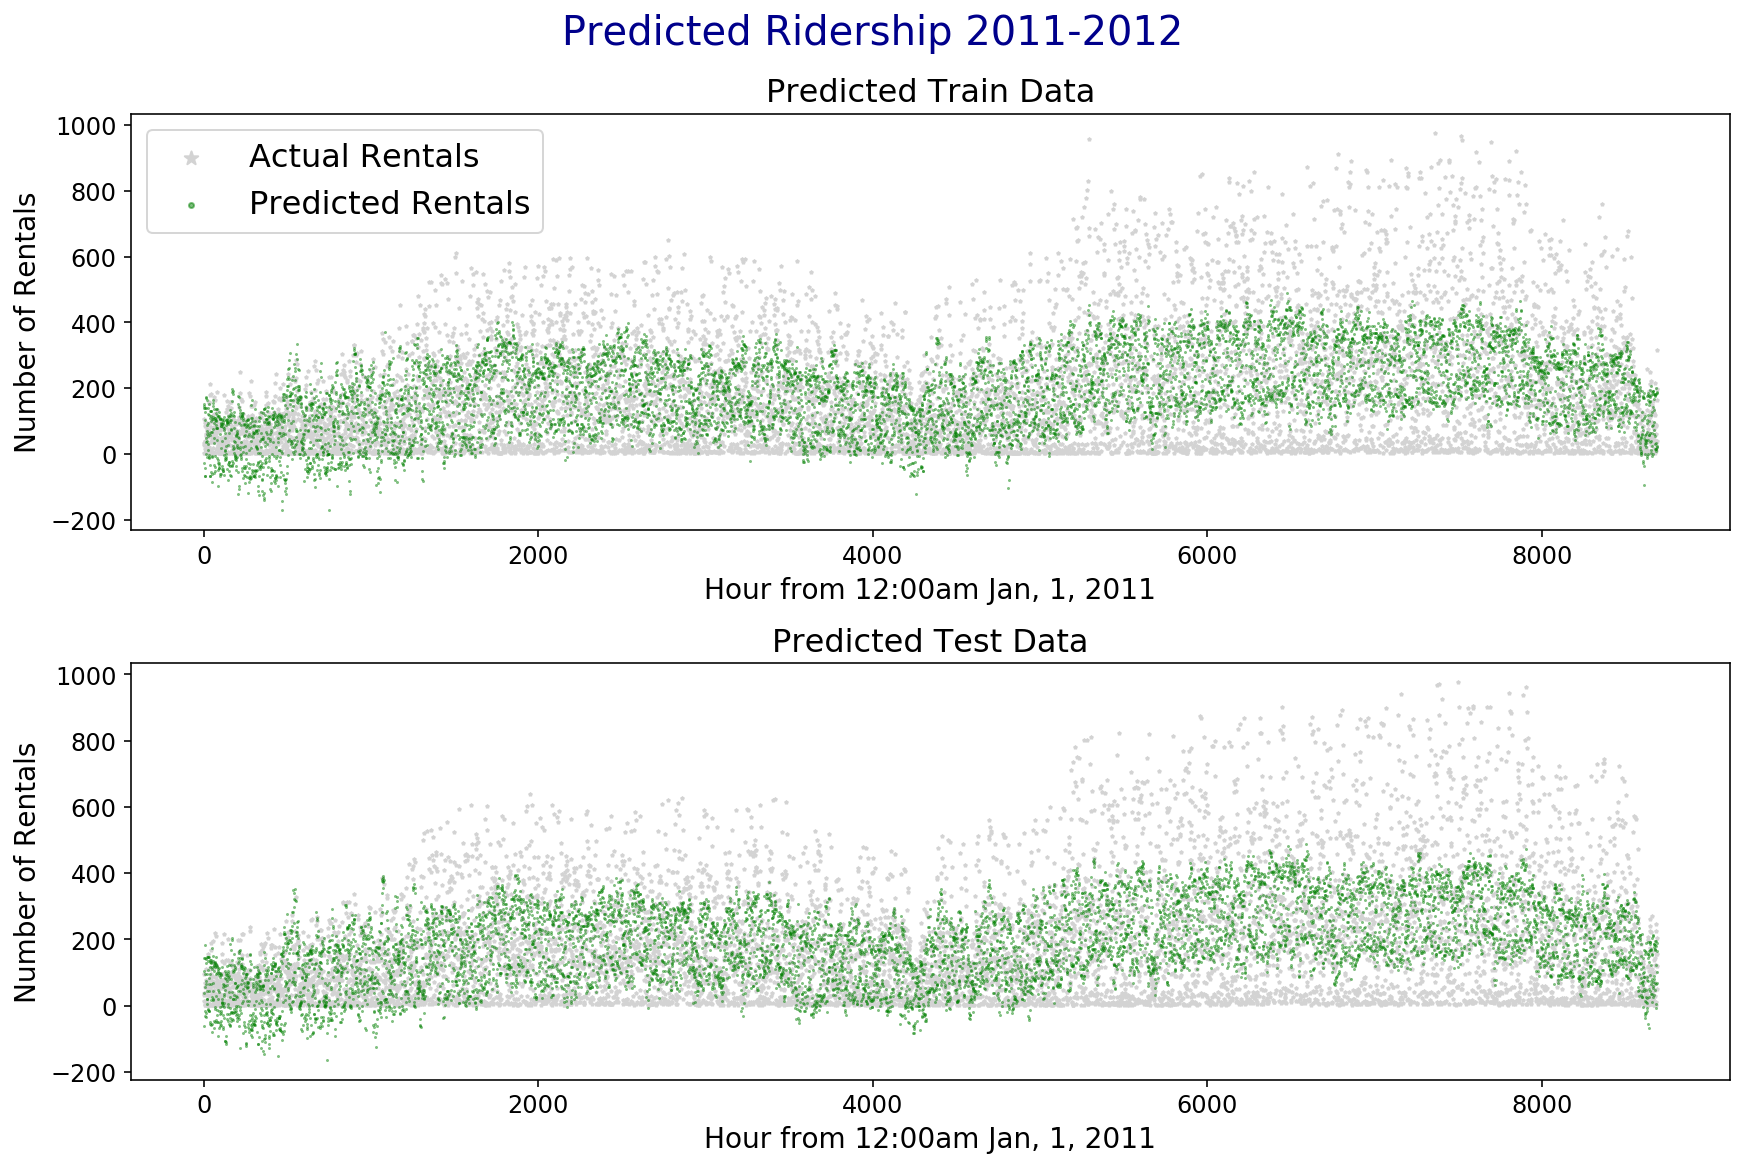

In [46]:
train_data = (X_train, y_train, predictions_train)
test_data = (X_test, y_test, predictions_test)
train_test_plots(train_data, test_data)

In [47]:
# R2 for train data
# R2_train = sm_BSS_model.rsquared
R2_train = r2_score(y_train, predictions_train)

# R2 for test data (calc with sklearn)
R2_test = r2_score(y_test, predictions_test)

print("R2 Train: ", np.round(R2_train, decimals=5))
print("R2 Test : ", np.round(R2_test , decimals=5))

R2 Train:  0.41157
R2 Test :  0.40072


**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

In [48]:
# your code here
sm_BSS_model.fvalue

201.85764373114839


**Fstat** indicates that there is at least one variable that is significant.


In [49]:
sm_BSS_model.params.const

-30.407500184523556

In [50]:
# Show significant indicators and their p-values
coefs = sm_BSS_model.params
pvalues = sm_BSS_model.pvalues
cols = X_test.columns
pthresh=.05
print("\nSignificant Indicators (p-value <={})\n".format(pthresh))
print('%-10s' '%10s' '%10s'% ("Predictor ", " p-value", "    coef"))
print('%-10s' '%10s' '%10s'% ("----------", "--------", "--------"))
for i in range(0, len(cols)):
    if pvalues[i]<=pthresh:
        print('%-10s' '%10s' '%10s'% (cols[i], np.round(pvalues[i], decimals=3), np.round(coefs[i], decimals=3) ))


Significant Indicators (p-value <=0.05)

Predictor    p-value      coef
----------  --------  --------
const          0.005   -30.408
hour             0.0     7.209
holiday        0.022   -19.151
year             0.0    78.121
workingday     0.002    10.948
temp             0.0   273.663
atemp          0.012   162.535
hum              0.0  -202.008
spring           0.0    50.075
summer         0.042    22.688
fall             0.0    70.947
Apr              0.0   -44.833
May              0.0   -50.161
Jun              0.0   -72.204
Jul              0.0   -90.896
Aug              0.0   -58.325
Nov            0.007   -32.723
Dec            0.045   -19.209
Sat            0.023    12.746
Snow             0.0   -26.815


The significant indicators are listed above.

The constant is significant indicating that January, Sunny, Winter and Sunday together, are significant.

An interesting observation is that 'Storm' didn't show up as significant.  I suspect this is because of the limited number of observations with story days.

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

July has a negative coefficient of -90.896.  This would indicate that if the month is July, we would decrease our prediction by 90.896 rentals.  Our 'base' prediction before this adjustment is January which is represented in the $\beta$ value.  However, our $\beta$ value includes not just January, but also 'Sunday', 'Winter' and 'Sunny'.  This means that the July coefficient is really not indicating the adjustment for July compared to Janaury, but is actually adjusting July compared to a Sunny, Winter, Sunday in January, with all other factors being equal.  Since we are not likely to have any days that have the exact other matching factors in January and July, this will be hard to validate, but makes sense.  

Another way to understand why this -90 coefficient makes sense is realizing that you will get more riders in January when it is 90degrees and sunny than you will in July if it is 90degrees and sunny.  In January, it's a celebration and in July it is a drag.  The same holds for lower temperatures. If it's 40degrees in July, people are less likely to be riding outside due to the coming ice age, but in January, the temperture will be business as usual.

One other point to consider is that since all of July in in Summer, we can offset the -90 with the +22 from Summer indicating that the differnce is about -68 rentals.

There are some other things that seem wrong here.  Using the season is kind of a repeat since months mostly correspond to the season.  aTemp is going to be highly related to temp and humidity some at least one of temp aTemp and humidity are redundant.  Workingday and Holiday also have a direct relationship.  Some of these items are probably driving the colinearity warning when using summary().

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

In [51]:
# plot histogram of residuals

def plot_residuals(residuals, predictions, debug=False) -> None:
    """
    Plots a historgram of residual values as well as the residual errors.
    Arguments:
        residuals: residual values from training data
        x_index: x index used in training
    """

    if debug:
        print("residuals shape:   {}  len: {} ".format(residuals.shape, len(residuals)))
        print("predictions shape: {}  len: {} ".format(predictions.shape, len(predictions)))
    
    fig, ax = plt.subplots(nrows=2, figsize=(12,6), constrained_layout=True)

    i = 0
    ax[i].set_title("Histogram of Fitted Model Residuals")
    ax[i].set_xlabel("Residual Value")
    ax[i].set_ylabel("Count")
    ax[i].hist(residuals, bins=int(len(residuals)/50))

    i = 1
    ax[i].set_title("Residuals by Prediction")
    ax[i].set_xlabel("Predicted Value")
    ax[i].set_ylabel("Residual Value")
    ax[i].scatter(predictions, residuals, s=1, c='r', label="Residual", alpha=.5)
    ax[i].legend(fontsize=12)
    ax[i].axhline(0, color='k')
    


    fig.show()

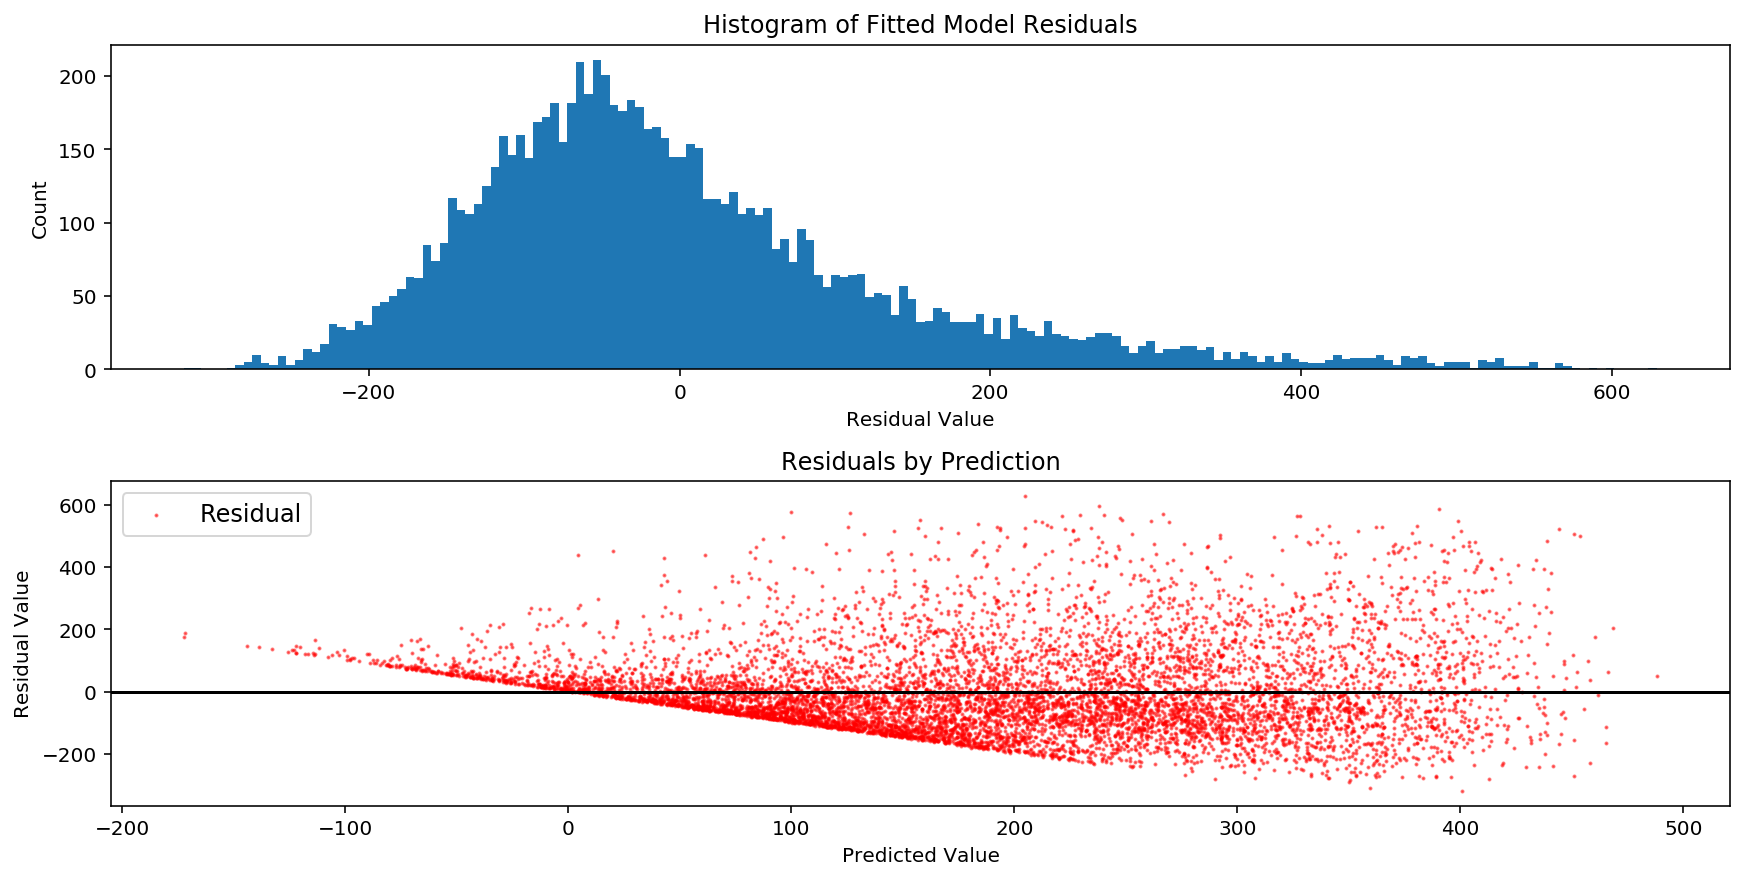

In [52]:
residuals = sm_BSS_model.resid # y_train - predictions_train
predictions = sm_BSS_model.fittedvalues
plot_residuals(residuals, predictions)

Linearity, Constant Variance, Normality

**Linearity**
The residual plot reveals some pattern in the residual data (lacks hereroskedacity).  The mass of deviations are just below the zero line with a disproportionate number of values on the high end of the residual.  This indicates that some of the error is in our model.  The sharp line is indicative of the floor value of 0 that we naurally have for the number of rentals. 

**Constant Variance**
The variance increases as the predicted value increases nor is the variance is also not symmetric around the zero line. Both indicate our model may not be optimal.

**Normality**
We observe a right skew in the distribtion.  Our model is underpredicting values at a larger rate than under-predicting.


**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [53]:
# your code here

# We will add polyfeatures for each term and then concantenate them
columns_forpoly = ['temp', 'hour', 'hum']
polyvals = 2
poly_transformer = PolynomialFeatures(polyvals, include_bias=False)

X_train_poly = X_train.copy()
for c in columns_forpoly:
    xdata = X_train[c].values.reshape(-1,1)
    col_names = []
    for val in range(1, polyvals):
        col_names.append("{}^{}".format(c, val+1))
    
    # ignore first column since it is the raw source data for each poly column
    c_pterms = pd.DataFrame(poly_transformer.fit_transform(xdata)[:,1:],columns=col_names) 
    
    # append to X_train_poly
    X_train_poly = pd.concat([X_train_poly, c_pterms], axis=1)
    
X_test_poly = X_test.copy()
for c in columns_forpoly:
    xdata = X_test[c].values.reshape(-1,1)
    col_names = []
    for val in range(1, polyvals):
        col_names.append("{}^{}".format(c, val+1))

    # ignore first column since it is the raw source data for each poly column
    c_pterms = pd.DataFrame(poly_transformer.fit_transform(xdata)[:,1:],columns=col_names)
    
    # append to X_train_poly -  dont add duplicate column
    X_test_poly = pd.concat([X_test_poly, c_pterms], axis=1)


In [54]:
X_train.shape, X_test.shape

((8689, 32), (8690, 32))

In [55]:
# we should have 3 new columns of data
X_train_poly.shape, X_test_poly.shape

((8689, 35), (8690, 35))

In [56]:
# fit model
sm_BSS_model_poly = sm.OLS(endog=y_train, exog=X_train_poly, hasconst=True).fit()

In [57]:
# predict model
predictions_train_poly = sm_BSS_model_poly.predict(X_train_poly)
predictions_test_poly = sm_BSS_model_poly.predict(X_test_poly)

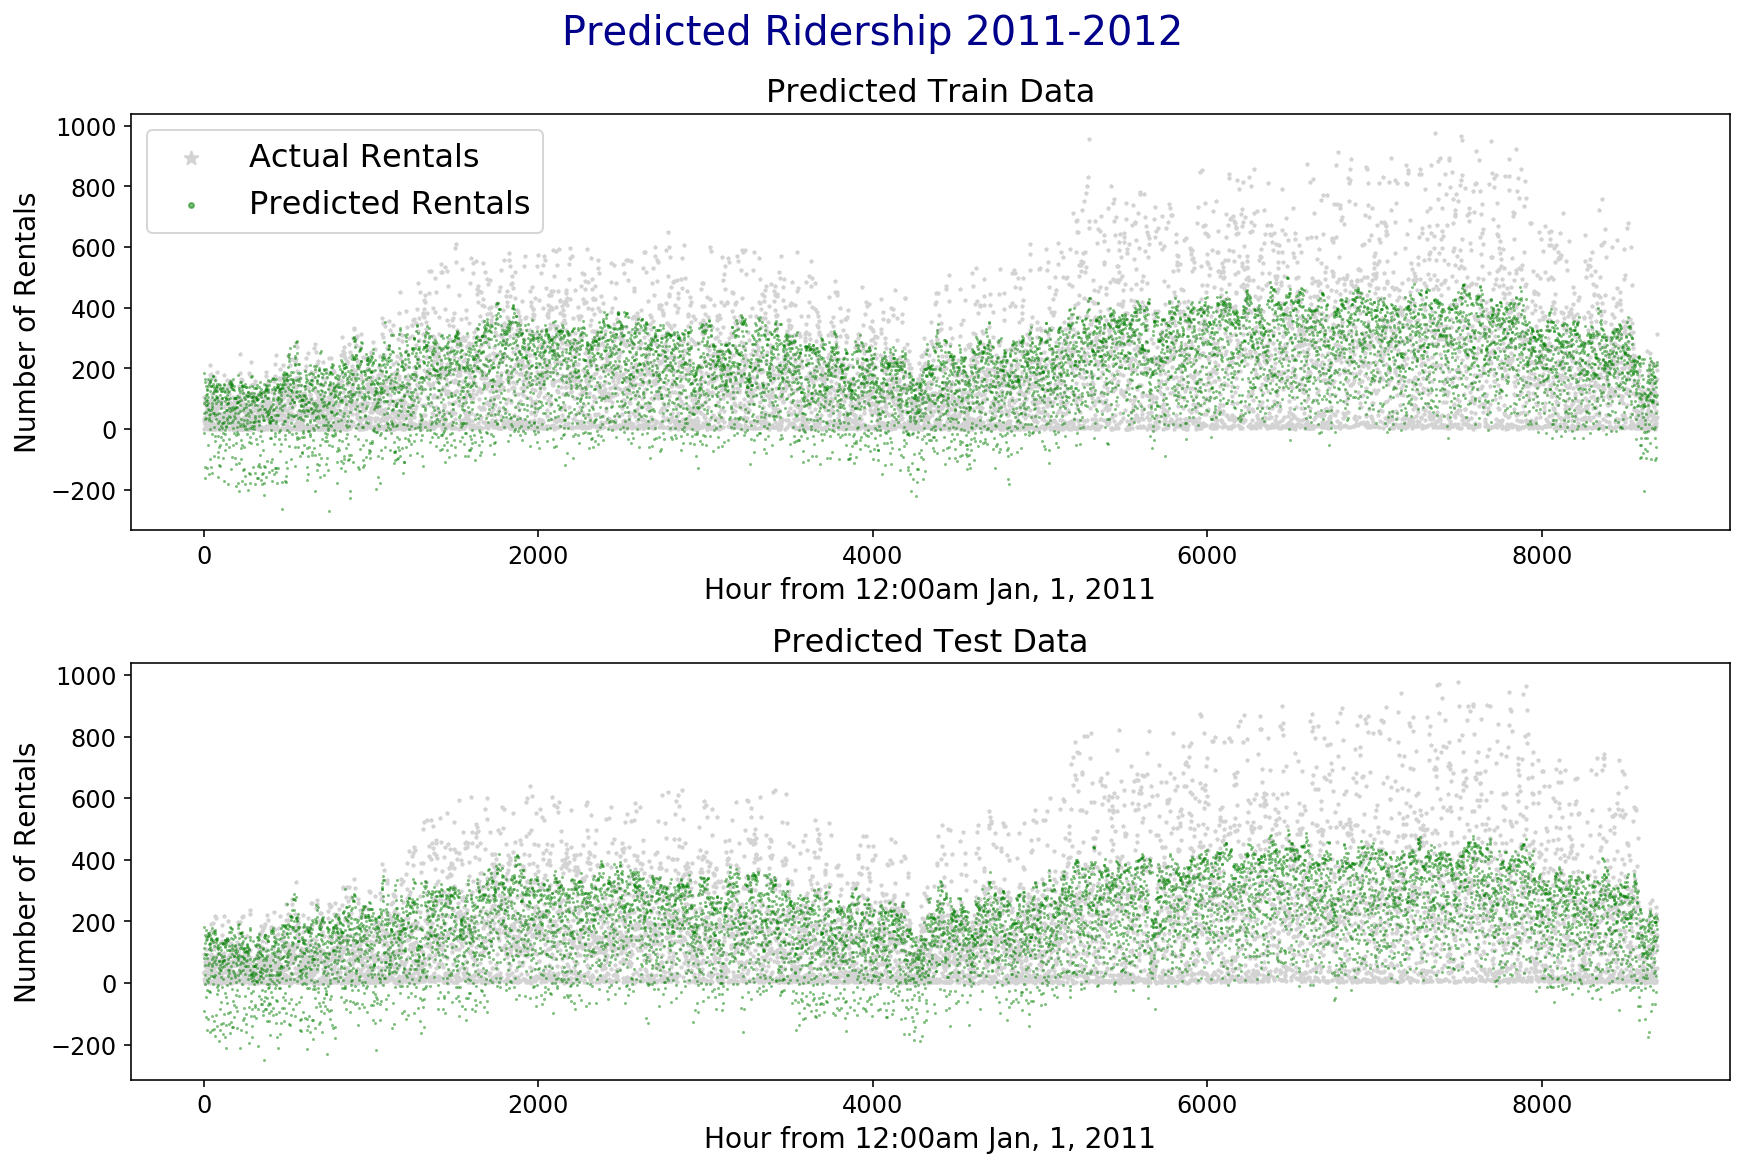

In [58]:
train_data = (X_train_poly, y_train, predictions_train_poly)
test_data = (X_test_poly, y_test, predictions_test_poly)
train_test_plots(train_data, test_data)

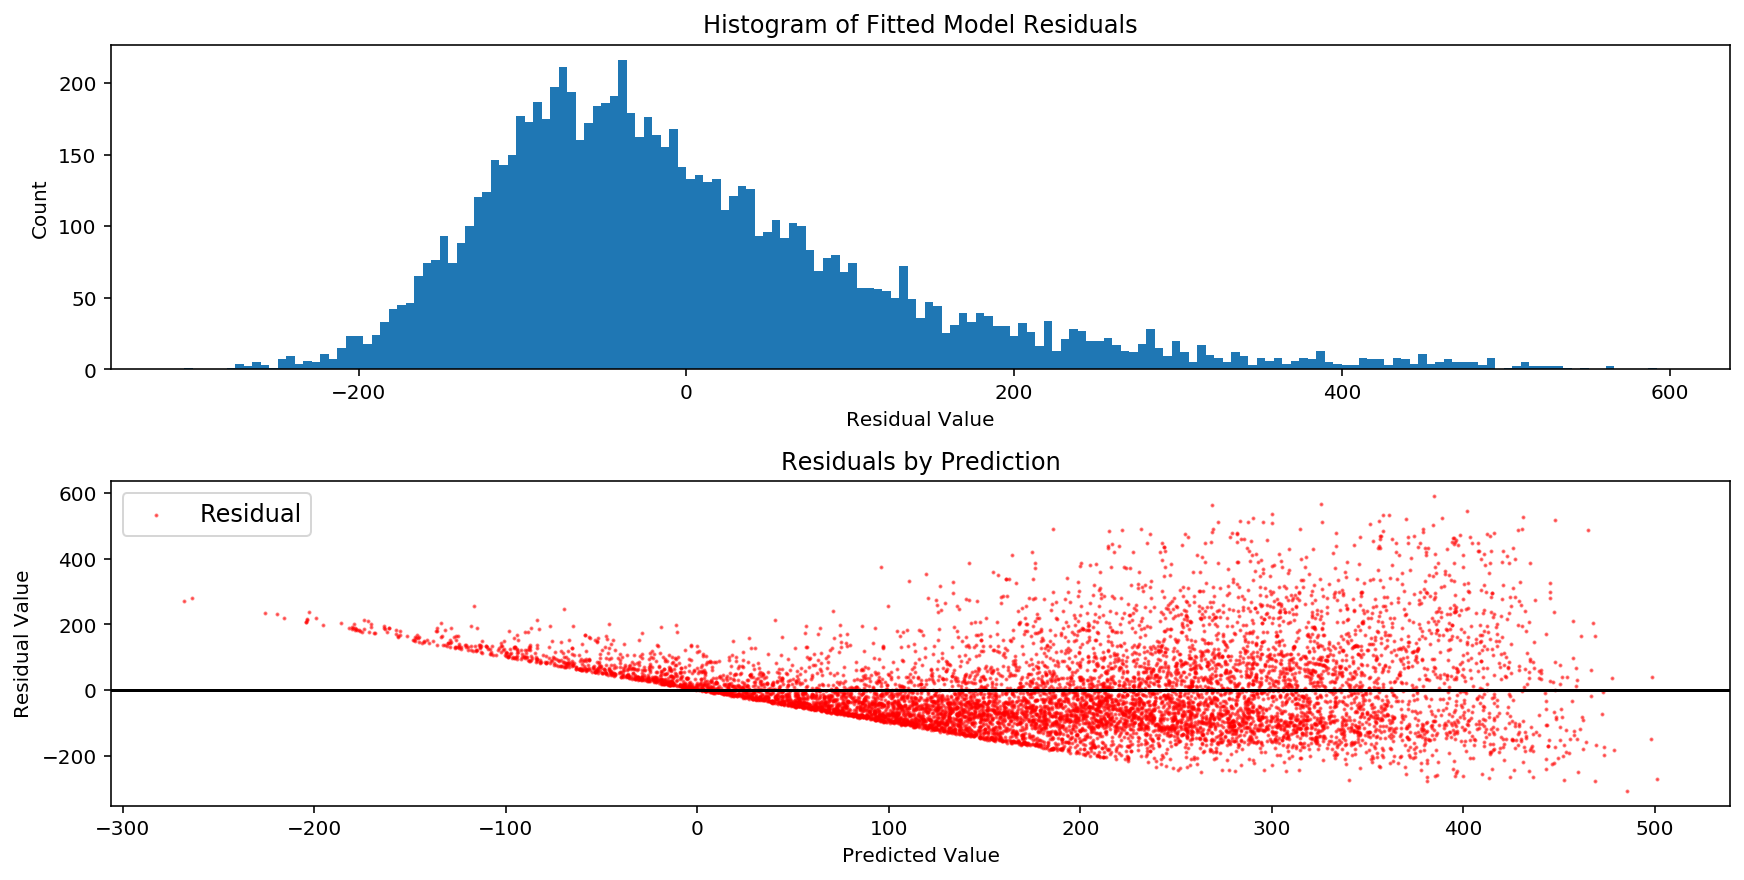

In [59]:
residuals = sm_BSS_model_poly.resid # y_train - predictions_train
predictions = sm_BSS_model_poly.fittedvalues
plot_residuals(residuals, predictions)

In [60]:
# R2 for train data
# R2_train = sm_BSS_model.rsquared
R2_train = r2_score(y_train, predictions_train_poly)

# R2 for test data (calc with sklearn)
R2_test = r2_score(y_test, predictions_test_poly)

print("R2 Train: ", np.round(R2_train, decimals=5))
print("R2 Test : ", np.round(R2_test , decimals=5))

R2 Train:  0.50849
R2 Test :  0.49059


In [61]:
# sm_BSS_model_poly.summary()

In [62]:
# Show significant indicators and their p-values
coefs = sm_BSS_model_poly.params
pvalues = sm_BSS_model_poly.pvalues
cols = X_test_poly.columns
pthresh=.05
print("\nSignificant Indicators (p-value <={})\n".format(pthresh))
print('%-10s' '%10s' '%10s'% ("Predictor ", " p-value", "    coef"))
print('%-10s' '%10s' '%10s'% ("----------", "--------", "--------"))
for i in range(0, len(cols)):
    if pvalues[i]<=pthresh:
        print('%-10s' '%10s' '%10s'% (cols[i], np.round(pvalues[i], decimals=3), np.round(coefs[i], decimals=3) ))


Significant Indicators (p-value <=0.05)

Predictor    p-value      coef
----------  --------  --------
const            0.0  -193.333
hour             0.0    40.221
year             0.0     83.21
workingday       0.0    13.224
atemp          0.015   148.531
spring           0.0    46.832
summer         0.013    25.408
fall             0.0    74.729
Jun            0.018   -29.876
Jul              0.0   -51.521
Nov            0.013     -27.8
Dec            0.031   -19.117
Sat              0.0    18.132
Cloudy         0.005    -9.507
Snow             0.0   -46.921
temp^2         0.002    140.68
hour^2           0.0    -1.388
hum^2          0.001  -126.887


Based on the p-values, all the new polynominal termed values are statisically significant.  

Seems unexpected that Temperature and Humidity alone are not signficant, but Temperature$^2$ and Humidity$^2$ are considered significant.

As temperature increases, the rate of additional riders increases.  Since we don't have the integer value of the termperature, we can't associate a change in degrees to ridership.

As the hour increases over the day we see an increase in 40 riders, except as the day progresses, this increase per hour will slow by a rate of 1.4 riders per hour.

As humidity increases, the rate of new riders renting bikes through the day decreases by 127.  Interesting the hum^2 is significant but humidity alone is not.

Looking at the weather parts of this, we can see that as the temperature increases, rate of additional riders per hour sees a sizable increase except if the increase in termperature is accompanied by an increase in humidity, that increased rate is offset considerably.

Since aTemp is a factor of temperature and humidity, I wonder if it is better to simply leave temperature and humidity out of the model and focus on aTemp alone.  To keep this notebook from getting too long, I am not going to include this analysis.

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.

In [63]:
drop_cols = ['workingday','atemp','spring','summer','fall']
X_train_drop = X_train.drop(drop_cols, axis=1)
X_test_drop = X_test.drop(drop_cols, axis=1)

In [64]:
# Check that drop worked properly
X_train_drop.columns ^ X_train.columns

Index(['atemp', 'fall', 'spring', 'summer', 'workingday'], dtype='object')

In [65]:
# fit new model using statsmodels
sm_BSS_model_drop = sm.OLS(endog=y_train, exog=X_train_drop, hasconst=True).fit() 
predictions_train_drop = sm_BSS_model_drop.predict(X_train_drop)
predictions_test_drop = sm_BSS_model_drop.predict(X_test_drop)

# using sklearn
# if 'const' in X_train_drop.columns:
#     sm_BSS_model_drop = LinearRegression().fit(X_train_drop.drop('const', axis=1), y_train)
#     # predict model
#     predictions_train_drop = sm_BSS_model_drop.predict(X_train_drop.drop('const', axis=1))
#     predictions_test_drop = sm_BSS_model_drop.predict(X_test_drop.drop('const', axis=1))

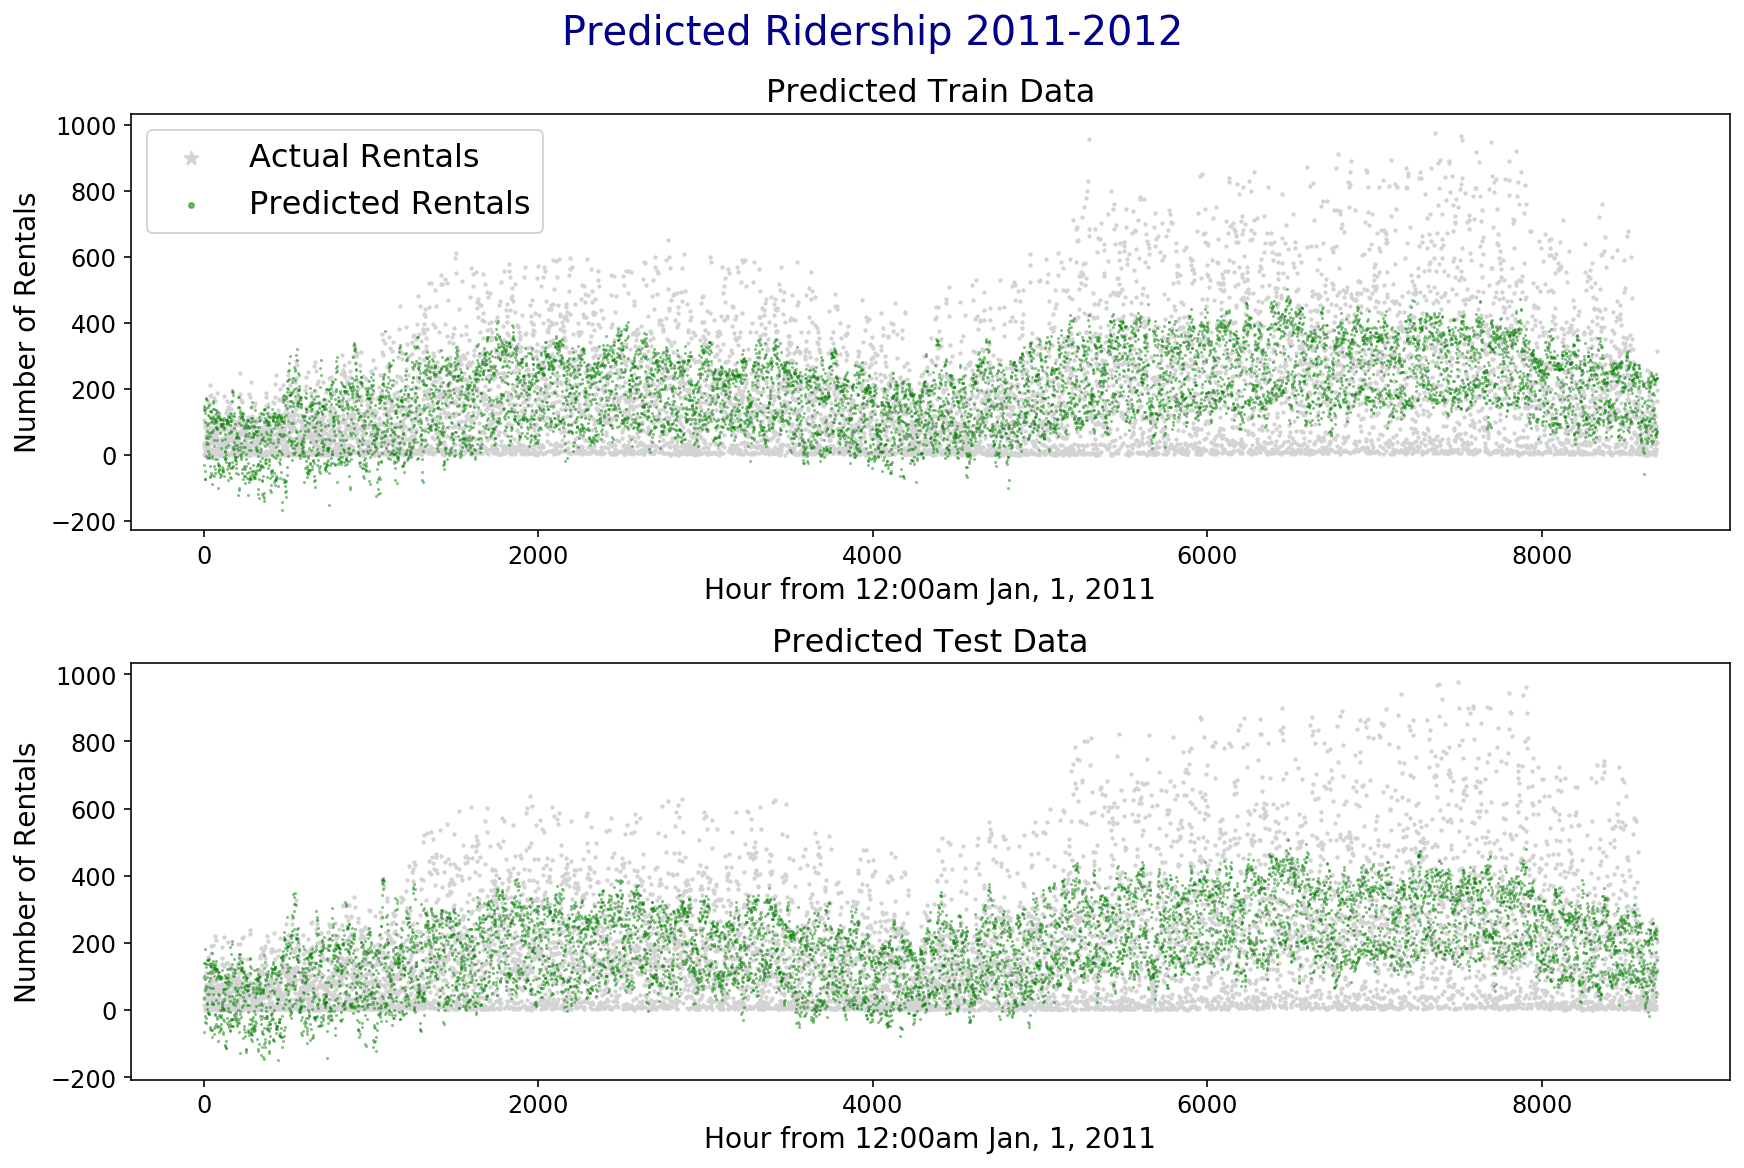

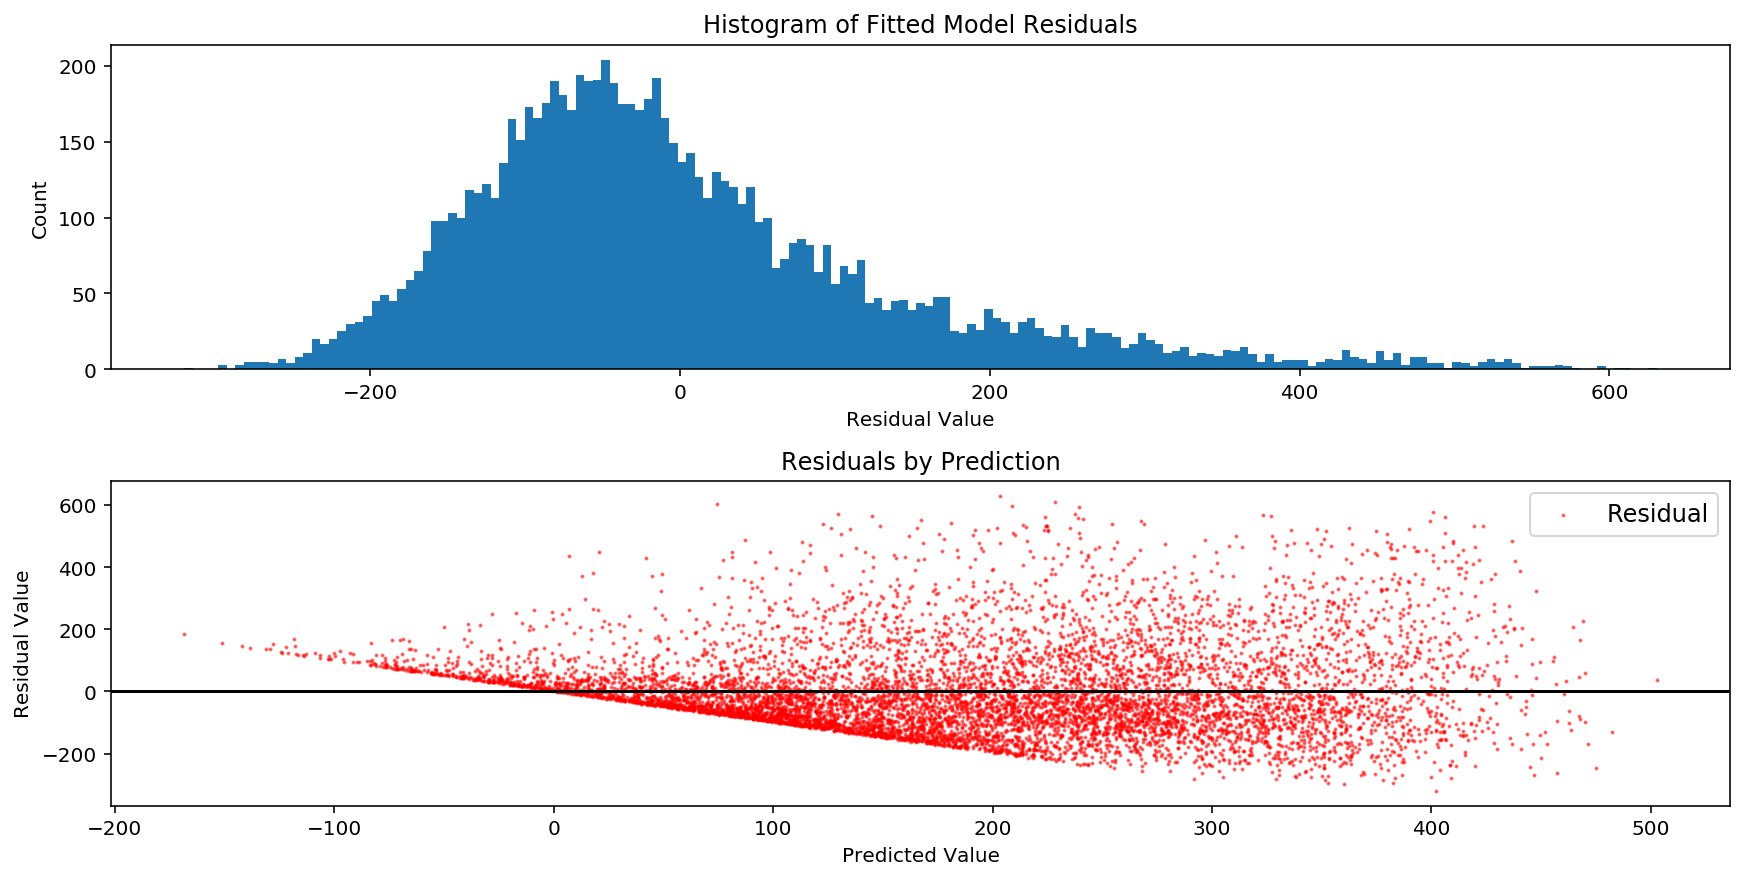

In [66]:
train_data = (X_train_drop, y_train, predictions_train_drop)
test_data = (X_test_drop, y_test, predictions_test_drop)
train_test_plots(train_data, test_data)

residuals =  y_train - predictions_train_drop # sm_BSS_model_drop.resid

plot_residuals(residuals, predictions_train_drop)

In [67]:
# R2 for train data
# R2_train = sm_BSS_model.rsquared
R2_train = r2_score(y_train, predictions_train_drop)

R2_test = r2_score(y_test, predictions_test_drop)

print("R2 Train: ", np.round(R2_train, decimals=5))
print("R2 Test : ", np.round(R2_test , decimals=5))

R2 Train:  0.40509
R2 Test :  0.39719


In [68]:
# Show significant indicators and their p-values
coefs = sm_BSS_model_drop.params
pvalues = sm_BSS_model_drop.pvalues
cols = X_test_drop.columns
pthresh=.05
print("\nSignificant Indicators (p-value <={})\n".format(pthresh))
print('%-10s' '%10s' '%10s'% ("Predictor ", " p-value", "    coef"))
print('%-10s' '%10s' '%10s'% ("----------", "--------", "--------"))
for i in range(0, len(cols)):
    if pvalues[i]<=pthresh:
        print('%-10s' '%10s' '%10s'% (cols[i], np.round(pvalues[i], decimals=3), np.round(coefs[i], decimals=3) ))


Significant Indicators (p-value <=0.05)

Predictor    p-value      coef
----------  --------  --------
const          0.015   -26.206
hour             0.0     7.222
holiday          0.0   -37.253
year             0.0    77.969
temp             0.0   425.386
hum              0.0    -198.2
Jun            0.001   -35.398
Jul              0.0   -72.277
Aug              0.0   -40.904
Oct              0.0    54.038
Nov              0.0    38.387
Dec            0.001    26.209
Tue            0.044    11.479
Fri            0.017     13.51
Sat            0.028    12.326
Snow             0.0   -27.396


After removing the colinear columns, the coeficient estimates are certainly more resonable.  

Multicolinearity indicates that there are data points that have a direct relationship with each other.  Such points have the same relationship with the response variable and are essentially like having the same predictor multuiple times in the model.

This is not desired, firstly, because it adds complexity to the model that is not necessary.  More importantly, it can lead to incorrect predictions by making a model that has too much emphasis on a pair of values that move in the same direction.  

R2 dropped from .412/.401 to .405/.397 in the train and test sets.  This is insignificant, so the removal of these points was reasonable. 

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

In [69]:
# Re-Read Data - Insert month to stratify later on
# ensure that data is sorted by date before removing date column
BSS_train = pd.read_csv('data/BSS_train.csv').sort_values(by=['dteday']).reset_index(drop=True)
BSS_test = pd.read_csv('data/BSS_test.csv').sort_values(by=['dteday']).reset_index(drop=True)


# Convert datetime column to datetime format
BSS_train.loc[:,'dteday'] = pd.to_datetime(BSS_train.loc[:,'dteday'])
BSS_test.loc[:,'dteday'] = pd.to_datetime(BSS_test.loc[:,'dteday'])

# insert a new series with the month so Jan is 1.
BSS_train.insert(2, "month", [y.month for y in BSS_train['dteday']] , False)
BSS_test.insert(2, "month", [y.month for y in BSS_test['dteday']] , False)

drop_cols = ['dteday', 'month', 'workingday','atemp','spring','summer','fall']
try:
    BSS_train = BSS_train.drop(drop_cols, axis=1)
    BSS_test  = BSS_test.drop(drop_cols, axis=1)
except:
    print("Columns removal failed: \n\t", drop_cols)

In [70]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [71]:
# Create fresh X_train and X_test sets to work on
X_train = BSS_train.copy()
X_test = BSS_test.copy()
y_train = BSS_train['counts']
y_test = BSS_test['counts']
drop_cols = ['casual','registered','counts']
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`

In [72]:
X_train.head()

hour  holiday  year  temp   hum  windspeed  Feb  Mar  Apr  May  ...  Dec  \
0    22        0     0  0.40  0.94     0.2239    0    0    0    0  ...    0   
1    14        0     0  0.46  0.72     0.2836    0    0    0    0  ...    0   
2     4        0     0  0.24  0.75     0.0000    0    0    0    0  ...    0   
3    21        0     0  0.40  0.87     0.1940    0    0    0    0  ...    0   
4    20        0     0  0.40  0.87     0.2537    0    0    0    0  ...    0   

   Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0    0    0    0    0    0    1       1     0      0  
1    0    0    0    0    0    1       1     0      0  
2    0    0    0    0    0    1       0     0      0  
3    0    0    0    0    0    1       1     0      0  
4    0    0    0    0    0    1       1     0      0  

[5 rows x 26 columns]

In [73]:
def is_binary(col:pd.Series) -> bool:
    "Return True if a column is binary"
    if col.dtype != int:
        return False
    elif (np.max(col)==0) & (np.max(col)==np.min(col)):
        return True
    elif (np.max(col)==1) & (np.min(col)==np.min(col)):
        return True
    elif (np.min(col)==0) & (np.max(col)==1):
        return True
    return False
            

In [74]:
def scale_data_columns(df_source:pd.DataFrame, 
                       cols_list:[]=None, 
                       scaler:StandardScaler=None, 
                       debug=False) -> pd.DataFrame:
    """
    Use sklearn StandardScaler to scale the specified columns only.
    Arguments:
        raw_data:pd.DataFrame - The dataframe that contains columns to scale
        cols_list:list() - A list of column names in the raw_data DataFrame to scale.
                Defaults to None which will scale all non-binary columns.
        scaler:StandardScaler - When argument exists, the supplied StandardScaler object will 
                be used to scale the data.  Otherwise, the data will be scaled based on the data in the column.
    Returns:
        Raw data set with the specied columns scaled and the scaler used.
    """

    name = None
    try: # get name if its a pandas Series
        name = df_source.name 
    except:
        pass 
    
    orig_shape = df_source.shape
    # If the data is 1-dimensional - it's 1 column, reshape it
    if df_source.ndim==1:
        df_source = np.array(df_source).reshape(-1,1)
    
    # if 2_dim with second dim = 1, it is also considered 1 column
    if (len(df_source.shape)==2) & (df_source.shape[1]==1): 
        if scaler is None:
            df_source = np.array(df_source).reshape(-1,1) # make sure it's numpy
            scaler = StandardScaler().fit(df_source)
        scaled_data = scaler.transform(df_source)
        return scaled_data, scaler
       

    # If cols_list is None, define define non-binary columns
    if cols_list is None:
        binary_columns = [c for c in df_source.columns if is_binary(df_source[c])]
        cols_list = list(df_source.columns ^ binary_columns)
        # const will be a binary column that should not be scaled
        if 'const' in cols_list:
            cols_list.remove('const')
        if debug:
            print("Creating list of non-binary columns to scale:\n\t", cols_list)
    # Cols were supplied, check if any are not in dataframe
    else:
        missing_cols = [c for c in cols_list if c not in df_source.columns]
        if missing_cols:
            print("The following supplied columns were not in the dataframe and will be skipped:\n")
            print(missing_cols)
            for c in missing_cols:
                cols_list.remove(c)

    # Scale all selected columns and save in new frame
    if scaler is None:
        scaler = StandardScaler().fit(df_source[cols_list])
    scaled_data = pd.DataFrame(scaler.transform(df_source[cols_list]), columns=cols_list)
    
    # replace scaled columns with the respective column in the source dataframe
    for c in cols_list:
        df_source[c] = scaled_data[c]
        
    if debug:
        print("Added scaling to :\n\t", cols_list )   
    return df_source, scaler

In [75]:
# TESTING - ERASE

yxx = np.array(y_train).reshape(-1,1)

data, scaler = scale_data_columns(y_train)
# data.shape, y_train.shape, X_train.shape


In [76]:
# Test scale_data_columns()

binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']

non_binary_columns = list(X_train.columns ^ binary_columns)
practice_X_train = X_train.drop(binary_columns, axis=1)
practice_X_train.head()

hour  year  temp   hum  windspeed
0    22     0  0.40  0.94     0.2239
1    14     0  0.46  0.72     0.2836
2     4     0  0.24  0.75     0.0000
3    21     0  0.40  0.87     0.1940
4    20     0  0.40  0.87     0.2537

In [77]:
non_binary_columns

['hour', 'hum', 'temp', 'windspeed', 'year']

In [78]:
# Scale data columns - will scale all continuous data columns
practice_X_train_scaled, _ = scale_data_columns(practice_X_train, debug=True)
practice_X_train_scaled.head()

Creating list of non-binary columns to scale:
	 ['hour', 'hum', 'temp', 'windspeed']
Added scaling to :
	 ['hour', 'hum', 'temp', 'windspeed']


hour  year      temp       hum  windspeed
0  1.494648     0 -0.500674  1.636992   0.270066
1  0.345191     0 -0.189066  0.492766   0.754466
2 -1.091631     0 -1.331629  0.648797  -1.546636
3  1.350966     0 -0.500674  1.272920   0.027460
4  1.207284     0 -0.500674  1.272920   0.511860

In [79]:
practice_X_train_scaled.describe()

hour         year          temp           hum     windspeed
count  8.689000e+03  8689.000000  8.689000e+03  8.689000e+03  8.689000e+03
mean   5.273208e-17     0.503395 -4.818590e-16 -9.801417e-16 -3.221487e-17
std    1.000058e+00     0.500017  1.000058e+00  1.000058e+00  1.000058e+00
min   -1.666359e+00     0.000000 -2.474192e+00 -3.251974e+00 -1.546636e+00
25%   -8.042663e-01     0.000000 -8.122824e-01 -7.554808e-01 -6.987336e-01
50%    5.782674e-02     1.000000  1.867233e-02 -2.733697e-02  2.746035e-02
75%    9.199197e-01     1.000000  8.496271e-01  8.048274e-01  5.118601e-01
max    1.638331e+00     1.000000  2.511537e+00  1.949053e+00  5.355858e+00

In [80]:
practice_X_train_scaled.dtypes

hour         float64
year           int64
temp         float64
hum          float64
windspeed    float64
dtype: object

In [81]:
# test y scaling
practice_y_train = y_train
practice_y_train_scaled, _ = scale_data_columns(practice_y_train, debug=False)
practice_y_train_scaled[0:10]

array([[-0.89504992],
       [-0.46511248],
       [-1.04387441],
       [-0.86197781],
       [-0.85095377],
       [-0.96119414],
       [-0.58637688],
       [-0.82890569],
       [-0.53676872],
       [-1.03285038]])

In [82]:
pd.DataFrame(practice_y_train_scaled, columns=['counts']).describe()

counts
count  8.689000e+03
mean  -1.943561e-16
std    1.000058e+00
min   -1.043874e+00
25%   -8.289057e-01
50%   -2.556558e-01
75%    5.160268e-01
max    4.335856e+00

The means of all columns are 0 (essentially zero) and the std deviations are 1 indicating they are standardized correctly.

**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [83]:
def poly_augment(df_source:pd.DataFrame, poly_cols:[], poly_max:int, debug=False) -> pd.DataFrame:
    """
    Augment specified DataFrame by adding polynomial values for the 
    column names specified.  Include a poly_max integer to indicate
    the highest order that should be created.  All orders except 1 and 0
    smaller than poly_max will be created as well.
    Arguments:
        df_source:pd.DataFarame - The dataframe with columns to base polynominal augmentaions on
        poly_cols:list() - A list of column names in the df_source that will be used to create
                    newly augmented columns
        poly_max:int - The maximum polynomial.  A column will be be created for each
                    integer up to and including this value where the integer will be
                    the exponent of the source column.
    Returns:
        The specified DataFrame with the added polynominal columns.
    """
    if debug:
        print("Running polynomial augmentation: {}".format(poly_max))
    
    if poly_max<1:
        print("Maximum polynominal must be 1 or larger.")
        return False
    
    if poly_max == 1:
        if debug:
            print("\nDid not add any polynomial columns. Kept original columns: \n", df_source.columns.values)
        return df_source
    
    transformer = PolynomialFeatures(poly_max, include_bias=False)
    
    all_poly_cols = []
    for c in poly_cols:
        if c not in df_source.columns:
            print("Specified column '{}' not in DataFrame. Skipping.".format(c))
            continue
            
        source_col = df_source[c].values.reshape(-1,1)
        col_names = []
        for poly_val in range(2, poly_max+1):
            new_col_name = "{}^{}".format(c, poly_val)
            if new_col_name in df_source.columns and debug:
                print("Column '{}' already exists in source DataFrame. Deleting from source and re-adding.".format(new_col_name))
                df_source = df_source.drop([new_col_name], axis=1)

            col_names.append(new_col_name)

        # Use tranformer to create new polynomial columns from the source column
        # ignore first column since it is already in the specified DataFrame
        df_pterms = pd.DataFrame(transformer.fit_transform(source_col)[:,1:],columns=col_names) 
        
        # append to specified DataFrame
        df_source = pd.concat([df_source, df_pterms], axis=1)
        
        all_poly_cols.append(col_names)
        
    if debug:
        print("\nAdding columns for polynomial terms:\n", all_poly_cols)
        
    return df_source
    

In [84]:
# We will add polyfeatures for each term and then concantenate them
poly_cols = ['temp', 'hum', 'windspeed', 'hour']
polyvals = 3
practice_X_train_poly = poly_augment(practice_X_train_scaled, poly_cols, polyvals, debug=True)

Running polynomial augmentation: 3

Adding columns for polynomial terms:
 [['temp^2', 'temp^3'], ['hum^2', 'hum^3'], ['windspeed^2', 'windspeed^3'], ['hour^2', 'hour^3']]


In [85]:
practice_X_train_poly.columns

Index(['hour', 'year', 'temp', 'hum', 'windspeed', 'temp^2', 'temp^3', 'hum^2',
       'hum^3', 'windspeed^2', 'windspeed^3', 'hour^2', 'hour^3'],
      dtype='object')

In [86]:
practice_X_train_poly.head()

hour  year      temp       hum  windspeed    temp^2    temp^3  \
0  1.494648     0 -0.500674  1.636992   0.270066  0.250675 -0.125506   
1  0.345191     0 -0.189066  0.492766   0.754466  0.035746 -0.006758   
2 -1.091631     0 -1.331629  0.648797  -1.546636  1.773236 -2.361293   
3  1.350966     0 -0.500674  1.272920   0.027460  0.250675 -0.125506   
4  1.207284     0 -0.500674  1.272920   0.511860  0.250675 -0.125506   

      hum^2     hum^3  windspeed^2  windspeed^3    hour^2    hour^3  
0  2.679742  4.386715     0.072936     0.019697  2.233974  3.339006  
1  0.242818  0.119652     0.569218     0.429456  0.119157  0.041132  
2  0.420937  0.273102     2.392083    -3.699682  1.191657 -1.300850  
3  1.620325  2.062544     0.000754     0.000021  1.825110  2.465662  
4  1.620325  2.062544     0.262001     0.134108  1.457535  1.759659

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

In [87]:
def make_term_pairs(df_source:pd.DataFrame,
                    term_pairs:[]=None,
                    dummies:[]=None,
                    interactive_binaries:[]=None,
                    interactive_continuous:[]=None,
                    exclude_chars:[]=['^'],
                    debug=False) -> []:
    """
    Helper function for add_interactive_terms().
    Creates a list of term pairs for all non-binary/binary combinations in a dataframe.
    Excludes polynomial columns.
    Arguments:
        df_source:pd.DataFrame - the dataframe from which to create term pairs
        term_pairs:list - Default=None.  Allows specified term pairs to be created
        exclude_char:list - Default=['^']. Excludes pairs where a pair element 
                contains any one of the characters in the list supplied.
    Returns:
        List of non-binary term pairs
    """
    
    def test_pair(pair:()) -> bool:
        # test for conditions on each element of pair
        # return True if passes conditions, False if either item fails
        one_is_dummy=False
        for p in pair:
            
            if debug:
                print("Evaluating Element: ", p)
            
            if p not in df_source.columns:
                if debug:
                    print("Pair item '{}' in pair '{}' not in source dataframe. Skipping pair.".format(p, pair))
                return False
            elif is_binary(df_source[p]):
                if one_is_dummy: # if we already have a dummy in the pair - False
                    if debug:
                        print("Both items in pair are dummies ({}). Skipping pair.".format(pair))
                    return False
                # if dummies are restricted - return False if this one is not listed
                if interactive_binaries and p not in interactive_binaries:
                    if debug:
                        print("Item not in binaries list: {} ({}). Skipping pair.".format(p, pair))
                    return False
                one_is_dummy=True
            elif p == 'const':
                if debug:
                    print("Pair item '{}' in pair '{}' is designated constant ({}). Skipping pair.".format(p, pair, df_source[p].dtypes))
                return False
            elif any([ c in p for c in exclude_chars]):
                if debug:
                    print("Pair item '{}' in pair '{}' is a polynomial term. Skipping pair.".format(p, pair))
                return False
            elif interactive_continuous and p not in interactive_continuous:
                if debug:
                    print("Item not in continuous list: {} ({}). Skipping pair.".format(p, pair))
                return False
        
        # One item in pair is not a dummy
        if not one_is_dummy:
            if debug:
                print("One pair item is not a dummy: '{}'. Skipping pair.".format(pair))
            return False
        
        return True
    
    
    
    # test that defined interactive columns are in dataframe
    if interactive_continuous:
        for c in interactive_continuous:
            if c not in df_source.columns:
                print("Specified column not in source dataframe: {}", c)
                return False
    if interactive_binaries:
        for c in interactive_binaries:
            if c not in df_source.columns:
                print("Specified column not in source dataframe: {}", c)
                return False
    
    
    # if pairs are not restricted in any way, define all possible term pairs
    if not term_pairs:  
        cols = list(df_source.columns.values)

        # define all combination of term pairs
        # if dummies have been specified
        term_pairs=[]
        cols_copy =  cols.copy()
        if dummies:
            # make all combinations for each dummy
            for dummy in dummies:
                for rcol in cols:
                    if rcol != dummy:
                        term_pairs.append( (dummy, rcol) )

        else:
            # make all combinations by determining dummies
            for nbcol in cols:
                cols_copy.remove(nbcol)
                for rcol in cols_copy:
                    term_pairs.append( (nbcol, rcol) )
       
    
    # review term pairs - remove items that don't pass the test
    term_pairs_copy = term_pairs.copy()
    for pair in term_pairs_copy:
        # test to make sure they should be included
        if debug:
            print("\nEvaluating Pair: ", pair)
        if not test_pair(pair): # if test fails, remove the pair
            term_pairs.remove(pair)

    return term_pairs

In [88]:
# test
make_term_pairs(X_train, interactive_binaries=['Feb', 'Mar'], interactive_continuous=['temp'], debug=False)

[('temp', 'Feb'), ('temp', 'Mar')]

In [89]:
# your code here

def add_interaction_terms(df_source:pd.DataFrame, 
                          term_pairs:[]=None,
                          interactive_binaries:[]=None,
                          interactive_continuous:[]=None,
                          dummies:[]=None, 
                          debug=False) -> pd.DataFrame:
    """
    Returns the source dataframe with interaction terms added.
    The term_pairs argument include a list of tuples where each
    tuple is a pais of interaction terms to multiple and include as a column.
    
    Ignores creating interaction columns if one of the pair items is not
    continuous data.
    
    Arguments:
        df_source:pd.DataFrame - A source dataframe that includes columns
                    indicated in the term_pairs list.
        term_pairs:list() - A list of tuples where each tuple is a pair of
                    column names.  A new column will be created for each pair
                    where the values in the column are the pair values multipled.
                    Pairs can be tuples of any number of columns.  If not supplied,
                    all non-integer colums will create a pair
        interactive_binaries:[] - List of explicit binariy columns to use when making interactive cols.
        interactive_continuous:[] - Explicit list of continuous terms to use whem making columns.
        dummies:list() - A list of specified dummies.  If None, dummies will be dervied
                    as columns with only 0's and 1's.
    Returns:
        The source dataframe with the interaction-pair columns added.
    """
    if debug:
        print("Adding interactive terms: \n\tBinary columns:\n\t\t{} \n\tContinuous columns:\n\t\t{}".format(interactive_binaries, interactive_continuous))
    
    debug=False
    # if term pairs is None, define term pairs
    if not term_pairs:
        term_pairs = make_term_pairs(df_source, 
                                     dummies=dummies, 
                                     interactive_binaries=interactive_binaries, 
                                     interactive_continuous=interactive_continuous, 
                                     debug=debug)

        if term_pairs==False:
            print("Terms pairs creation failed. Not adding Interaction Terms.")
            return False
    
    for pair in term_pairs:
        # create column name
        new_col_name = '*'.join(pair)
        new_col = pd.Series()
        
        # create new series that is the columns in pair multiplied
        for i, col in enumerate(pair):
            if i==0:
                new_col = df_source[col]
            else:
                new_col = new_col * df_source[col]
        new_col.name = new_col_name # assign name to new column
        
        # add new column to source dataframe
        df_source = pd.concat([df_source,new_col], axis=1)

    return df_source
            

In [90]:
interactive_continuous = [ 'temp','hum', 'windspeed' ]
interactive_binaries = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']
practice_X_train_poly_pairs = add_interaction_terms(X_train, 
                                                    dummies=None, 
                                                    interactive_continuous=interactive_continuous, 
                                                    interactive_binaries=interactive_binaries, 
                                                    debug=False)

In [91]:
practice_X_train_poly_pairs.head()

hour  holiday  year  temp   hum  windspeed  Feb  Mar  Apr  May  ...  \
0    22        0     0  0.40  0.94     0.2239    0    0    0    0  ...   
1    14        0     0  0.46  0.72     0.2836    0    0    0    0  ...   
2     4        0     0  0.24  0.75     0.0000    0    0    0    0  ...   
3    21        0     0  0.40  0.87     0.1940    0    0    0    0  ...   
4    20        0     0  0.40  0.87     0.2537    0    0    0    0  ...   

   windspeed*Sept  windspeed*Oct  windspeed*Nov  windspeed*Dec  windspeed*Mon  \
0             0.0            0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0            0.0   

   windspeed*Tue  windspeed*Wed  windspeed*Thu  windspeed*Fri  windspeed*Sat  
0            0.0            0.0            0.0            0.0         0.2239  
1            0.0            0.0            0.0            0.0         0.2836  
2            0.0            0.0            0.0            0.0         0.0000  
3            0.0            0.0            0.0            0.0         0.1940  
4            0.0            0.0            0.0            0.0         0.2537  

[5 rows x 77 columns]

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [92]:
def get_design_mats(train_df:pd.DataFrame, 
                    val_df:pd.DataFrame=pd.DataFrame(),  
                    degree:int=2, 
                    columns_forpoly:[]=['temp', 'hum','windspeed', 'hour'],
                    interactive_binaries:[]=None,
                    interactive_continuous:[]=None,
                    target_col:str='counts', 
                    bad_columns:[]=['counts'],
                    scale_data:bool=True,
                    x_scaler:StandardScaler=None,
                    y_scaler:StandardScaler=None,
                    library:str='statsmodels',
                    debug:bool=False):
    """
    Return training and validation x and y data configured according to 
    argument values.  If val_df=None then only x and y data are returned for
    training data.
    :param train_df: The training data
    :param val_df: Your test/validation data. (optional) - Without this, we can assume
                    that testing data is being formatted.
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    :param interactive_binaries:[] - binary columns for interactive columns
    :param interactive_continuous:[] - continuous colums for interactive columns
    :param scale_data:bool - scaling can optionally be chosen
    :param scaler:StandardScaler - scaler can be explicitely set (optional)
    :param library:str - using 'statsmodels' or 'scikit' will determin the model function to use
                        as well as whether or not to add a constant to the data.
    
    """
    
    if debug:
        print ("Running get_design_mats(). Creating train and test sets.")
        print (train_df.shape, train_df.columns)
        print (val_df.shape, val_df.columns)

    # split train and validation sources into x and y frames
    train_df = train_df.reset_index(drop=True) # reset the indexes
    x_train = train_df.drop(bad_columns, axis=1) # drop specified columns
    y_train = train_df[target_col]
    y_train = np.array(y_train).reshape(-1,1) 
    
    x_val = pd.DataFrame()
    y_val = pd.Series()
    if len(val_df) != 0:
        val_df = val_df.reset_index(drop=True) # reset the indexes
        x_val  = val_df.drop(bad_columns, axis=1)
        y_val  = val_df[target_col]
        y_val  = np.array(y_val).reshape(-1,1)
    
    # scale
    if scale_data==True:
        if debug: print("Data will be scaled.")
        x_train, x_scaler = scale_data_columns(x_train, scaler=x_scaler, debug=debug)
        y_train, y_scaler = scale_data_columns(y_train, scaler=y_scaler, debug=debug)        
        if len(val_df) != 0:
            x_val, x_scaler = scale_data_columns(x_val, scaler=x_scaler, debug=debug)
            y_val, y_scaler = scale_data_columns(y_val, scaler=y_scaler, debug=debug)
    
    # add poly cols
    if degree:
        x_train = poly_augment(x_train, 
                               poly_cols=columns_forpoly, 
                               poly_max=degree, 
                               debug=debug)
        if len(val_df) != 0:
            x_val = poly_augment(x_val, 
                                 poly_cols=columns_forpoly, 
                                 poly_max=degree, 
                                 debug=debug)
    
    # add interaction cols
    x_train = add_interaction_terms(x_train, 
                                    interactive_binaries=interactive_binaries, 
                                    interactive_continuous=interactive_continuous, 
                                    debug=debug)
    if len(val_df) != 0:
        x_val = add_interaction_terms(x_val,
                                      interactive_binaries=interactive_binaries,
                                      interactive_continuous=interactive_continuous,
                                      debug=debug)
    
    if debug:
        print("get_design_mats(): Library: {}  x_train cols: \n\t{}".format(library, x_train.columns))
    
    # add constant columns to x_train and x_val if they don't already exist
    # set appropriate constant column and y shapes depending on the library used
    if library == 'statsmodels':
        if 'const' not in x_train.columns:
            x_train = sm.add_constant(x_train, has_constant='add')
        if 'const' not in x_val.columns:
            x_val = sm.add_constant(x_val, has_constant='add')
    elif library == 'scikit':
        if 'const' in x_train.columns:
            x_train = x_train.drop('const', axis=1)
        if 'const' in x_val.columns:
            x_val = x_val.drop('const', axis=1)
    else:
        print("Library must be 'statsmodels' or 'scikit': {}.".format(library))
        return False   

    if len(val_df) == 0:
        return x_train, y_train
        
    return x_train, y_train, x_val, y_val, x_scaler, y_scaler

In [93]:
ic = [ 'temp','hum', 'windspeed' ]
ib = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']

xx_train, xy_train, xx_val, xy_val, x_scaler, y_scaler = get_design_mats(train_df=BSS_train, 
                                                             val_df=BSS_test,
                                                             degree=2,
                                                             columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                                                             target_col='counts',
                                                             bad_columns=['casual','registered','counts'],
                                                             interactive_continuous=ic,
                                                             interactive_binaries=ib,
                                                             library='statsmodels',
                                                             debug=False)


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

In [94]:
# For each degree 1-8:
# - Create Data Sets
# - Fit model
# - Predict
# - Store Scores
# Store in list a dictionary of model variables and results

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def create_models(max_poly:int, 
                  train_set:pd.DataFrame, 
                  val_set:pd.DataFrame, 
                  target_col:str='counts', 
                  bad_columns:[]=['casual','registered','counts'],
                  columns_forpoly:[]=['temp', 'hum','windspeed', 'hour'],
                  interactive_binaries:[]=None,
                  interactive_continuous:[]=None,
                  lambdas:[]=None,
                  model_types:[]=['OLS'],
                  library='statsmodels',
                  debug:bool=False) -> pd.DataFrame():
    """
    Create a model for each combination of degree and lambda value provided.
    Stores model in a dataframe with respective performance scores and relevant model information.
    Arguments:
        max_poly:int - 
        train_set:pd.DataFrame - 
        val_set:pd.DataFrame - 
        target_col:str - Default is 'counts'.  Response variable's column name.
        bad_columns:list - Default is ['casual','registered','counts']. Columns to remove from training set.
        columns_forpoly:list - Default is ['temp', 'hum','windspeed', 'hour'].
                    Columns to use when creating polynomial expansions.
        interactive_binaries:[] - List of explicit binariy columns to use when making interactive cols.
        interactive_continuous:[] - Explicit list of continuous terms to use whem making columns.
        dummies:list() - A list of specified dummies.  If None, dummies will be dervied
        lambdas:list - Default is [0].  The lambdas to use for regularization.
        model_types:list - Default is 'OLS'. Add 'ridge' and/or 'lasso' to add regularization types.
        library:str - using 'statsmodels' or 'scikit' will determin the model function to use
                        as well as whether or not to add a constant to the data.
        debug:bool - Default is False.  When True, prints additional output to the terminal. 
    Returns:
        Pandas DataFrame where is row contains a fitted model and the scores of the model.
    """
    
    def add_entry(model, 
                  dataframe, 
                  model_type, 
                  x_train, y_train, x_val, y_val, 
                  lambda_val:float=0.0, 
                  x_scaler:StandardScaler=None, 
                  y_scaler:StandardScaler=None, 
                  library:str='statsmodels') -> pd.DataFrame:
        
        # predict model
        predictions_train = model.predict(x_train)
        predictions_val = model.predict(x_val)

        #R2 Scores
        R2_train = r2_score(y_train, predictions_train)
        R2_val = r2_score(y_val, predictions_val)
        
        # MSE Calculations
        MAE_train = mean_absolute_error(y_train, predictions_train)
        MAE_val = mean_absolute_error(y_val, predictions_val)
        MSE_train = mean_squared_error(y_train, predictions_train)
        MSE_val = mean_squared_error(y_val, predictions_val)
        
        # Add model details to dataframe
        dataframe = dataframe.append({
            "model":model,
            "target_col":target_col,
            "bad_columns":bad_columns,
            "binary_cols":interactive_binaries,
            "cont_cols":interactive_continuous,
            "columns_forpoly":columns_forpoly,
            "x_scaler":x_scaler,
            "y_scaler":y_scaler,
            "degree":poly,
            "R2_train":R2_train,
            "R2_val":R2_val,
            "lambda_val":lambda_val,
            "model_type":model_type,
            "MAE_train":MAE_train,
            "MAE_val":MAE_val,
            "MSE_train":MSE_train,
            "MSE_val":MSE_val
        }, ignore_index=True)
        
        if debug:
            print("\tSaved Model with polynomial: {}   lambda: {}/{}".format(poly, lambda_val, model_type))
        
        return dataframe
    # END add_entry()
    
    
    print("\nBeginning Model Creation")
    print("Response Variable: \n\t", target_col)
    print("Base Predictors: \n\t", [x for x in train_set.columns.values if x not in bad_columns])
    cols = ["model", "target_col", "bad_columns", "binary_cols", "cont_cols", "columns_forpoly", "x_scaler", "y_scaler", "degree", "lambda_val", "model_type", "R2_train", "R2_val", "MAE_train", "MAE_val", "MSE_train", "MSE_val"]
    results_df = pd.DataFrame(columns=cols)
    
    for poly in range(1, max_poly+1):

        # Create Data Sets
        x_train, y_train, x_val, y_val, x_scaler, y_scaler = get_design_mats(train_df=train_set,
                                                        val_df=val_set,
                                                        degree=poly,
                                                        columns_forpoly=columns_forpoly,
                                                        interactive_binaries=interactive_binaries,
                                                        interactive_continuous=interactive_continuous,
                                                        target_col=target_col,
                                                        bad_columns=bad_columns,
                                                        library=library)
        
        if debug:
            print ("create_models(): library:{} x_train columns: {}".format(library, len(x_train.columns)))
        
        if 'const' in x_train.columns and library=='scikit':
            print("ERROR: You are giving a Scikit model a training constant! create_models():add_entry()")
            break
        
        # build and fit OLS model
        # get_design_mats makes sure const column is present if using statsmodel
        if 'OLS' in model_types:
            if debug:
                print("\nBuilding OLS model using {}.  Columns: {}".format(library, len(x_train.columns)))
            if library=='statsmodels':
                model = sm.OLS(endog=y_train, exog=x_train, hasconst=True).fit() 
            else: # using scikit
                model = LinearRegression().fit(X=x_train, y=np.array(y_train).reshape(-1,1)) 

            results_df = add_entry(model=model, 
                                   dataframe=results_df, 
                                   model_type='OLS',
                                   x_train=x_train,
                                   y_train=y_train,
                                   x_val=x_val,
                                   y_val=y_val,
                                   x_scaler=x_scaler,
                                   y_scaler=y_scaler)
         
        if 'ridge' in model_types:
            if lambdas is None:
                print("Regularized model requires lambdas to be set, but list is None. Skipping OLS-Reg Model build.")
                continue
            for l_val in lambdas:
                if debug:
                    print("\nBuilding OLS-Ridge Regularized model: {} Columns:{}".format(float(l_val),len(x_train.columns)))
                model = Ridge(alpha=l_val, max_iter=100000).fit(X=x_train, y=np.array(y_train).reshape(-1,1))
                results_df = add_entry(model=model, 
                                       dataframe=results_df, 
                                       model_type='ridge', 
                                       x_train=x_train,
                                       y_train=y_train,
                                       x_val=x_val,
                                       y_val=y_val,
                                       x_scaler=x_scaler,
                                       y_scaler=y_scaler,
                                       lambda_val=l_val,
                                       library=library)
            
        if 'lassoCV' in model_types:
            if lambdas is None:
                print("Lasso model requires lambdas to be set, but list is None. Skipping Lasso Model build.")
                continue
            if debug:
                print("\nBuilding LassoCV model: {} Columns:{}".format(lambdas,len(x_train.columns)))
            model = LassoCV(alphas=lambdas).fit(X=x_train, y=np.array(y_train).reshape(-1,1))

            results_df = add_entry(model=model, 
                                   dataframe=results_df, 
                                   lambda_val=model.alpha_, 
                                   model_type='lassoCV', 
                                   x_train=x_train,
                                   y_train=y_train,
                                   x_val=x_val,
                                   y_val=y_val,
                                   x_scaler=x_scaler,
                                   y_scaler=y_scaler,
                                   library=library)
        
        if 'ridgeCV' in model_types:
            if lambdas is None:
                print("Ridge model requires lambdas to be set, but list is None. Skipping Ridge Model build.")
                continue
            if debug:
                print("\nBuilding RidgeCV model: {} Columns:{}".format(lambdas,len(x_train.columns)))
            model = RidgeCV(alphas=lambdas).fit(X=x_train, y=np.array(y_train).reshape(-1,1))
            results_df = add_entry(model=model, 
                                   dataframe=results_df, 
                                   lambda_val=model.alpha_, 
                                   model_type='ridgeCV',
                                   x_train=x_train,
                                   y_train=y_train,
                                   x_val=x_val,
                                   y_val=y_val,
                                   x_scaler=x_scaler,
                                   y_scaler=y_scaler,
                                   library=library)
        
    print("DONE")
    
    return results_df

In [95]:
ic = ['temp','hum', 'windspeed']
ib = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']
fit_results = create_models(8, 
                            train_set=BSS_train, 
                            val_set=BSS_test, 
                            interactive_continuous=ic, 
                            interactive_binaries=ib,
                            library='statsmodels',
                            debug=True)


Beginning Model Creation
Response Variable: 
	 counts
Base Predictors: 
	 ['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
create_models(): library:statsmodels x_train columns: 78

Building OLS model using statsmodels.  Columns: 78
	Saved Model with polynomial: 1   lambda: 0.0/OLS
create_models(): library:statsmodels x_train columns: 82

Building OLS model using statsmodels.  Columns: 82
	Saved Model with polynomial: 2   lambda: 0.0/OLS
create_models(): library:statsmodels x_train columns: 86

Building OLS model using statsmodels.  Columns: 86
	Saved Model with polynomial: 3   lambda: 0.0/OLS
create_models(): library:statsmodels x_train columns: 90

Building OLS model using statsmodels.  Columns: 90
	Saved Model with polynomial: 4   lambda: 0.0/OLS
create_models(): library:statsmodels x_train columns: 94

Building OLS model using sta

In [96]:
fit_results.head()

model target_col  \
0  <statsmodels.regression.linear_model.Regressio...     counts   
1  <statsmodels.regression.linear_model.Regressio...     counts   
2  <statsmodels.regression.linear_model.Regressio...     counts   
3  <statsmodels.regression.linear_model.Regressio...     counts   
4  <statsmodels.regression.linear_model.Regressio...     counts   

                    bad_columns  \
0  [casual, registered, counts]   
1  [casual, registered, counts]   
2  [casual, registered, counts]   
3  [casual, registered, counts]   
4  [casual, registered, counts]   

                                         binary_cols               cont_cols  \
0  [Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct,...  [temp, hum, windspeed]   
1  [Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct,...  [temp, hum, windspeed]   
2  [Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct,...  [temp, hum, windspeed]   
3  [Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct,...  [temp, hum, windspeed]   
4  [Feb, Mar, Apr, May, Jun, Jul, Aug, Sept, Oct,...  [temp, hum, windspeed]   

                columns_forpoly  \
0  [temp, hum, windspeed, hour]   
1  [temp, hum, windspeed, hour]   
2  [temp, hum, windspeed, hour]   
3  [temp, hum, windspeed, hour]   
4  [temp, hum, windspeed, hour]   

                                            x_scaler  \
0  StandardScaler(copy=True, with_mean=True, with...   
1  StandardScaler(copy=True, with_mean=True, with...   
2  StandardScaler(copy=True, with_mean=True, with...   
3  StandardScaler(copy=True, with_mean=True, with...   
4  StandardScaler(copy=True, with_mean=True, with...   

                                            y_scaler degree  lambda_val  \
0  StandardScaler(copy=True, with_mean=True, with...      1         0.0   
1  StandardScaler(copy=True, with_mean=True, with...      2         0.0   
2  StandardScaler(copy=True, with_mean=True, with...      3         0.0   
3  StandardScaler(copy=True, with_mean=True, with...      4         0.0   
4  StandardScaler(copy=True, with_mean=True, with...      5         0.0   

  model_type  R2_train    R2_val  MAE_train   MAE_val  MSE_train   MSE_val  
0        OLS  0.437482  0.429194   0.554179  0.557307   0.562518  0.570282  
1        OLS  0.526351  0.512199   0.515276  0.524278   0.473649  0.487353  
2        OLS  0.569570  0.561271   0.477299  0.484274   0.430430  0.438326  
3        OLS  0.571380  0.564381   0.477760  0.483582   0.428620  0.435218  
4        OLS  0.586311  0.576064   0.476686  0.484117   0.413689  0.423547

In [97]:
def plot_score_chart(results:pd.DataFrame, 
                     plot_model_type:str='OLS',
                     score_to_plot:str='R2',
                     invert_chart:bool=False,
                     plot_train:bool=True,
                     plot_val:bool=True) -> None:
    """
    Plots scores of multiple models
    Arguments:
    Returns:
        Nothing.  Displays Chart.
    """

    results = results[results.model_type==plot_model_type]
    # If all are zero, this will reduce the list into a single item of 0 in the list
    lambda_vals = np.unique(results.lambda_val.values).tolist()
    degrees = np.unique(results.degree.values).tolist()

    # Plot r2 trends
    # Figure Setup and Title
    fig , subplot = plt.subplots(nrows=1, ncols=1, figsize=(12,8), constrained_layout=True)  # (rows, columns)
    fig.suptitle("{} Results For Multiple Polynomial Values - {}".format(score_to_plot, plot_model_type), fontsize=20, color='darkblue')

    if invert_chart:
        for item in degrees:
            if plot_train:
                if score_to_plot == 'R2':
                    subplot.plot(results[results.degree==item].R2_train.values, label="Training R2 (degree={})".format(item), marker='+')
                if score_to_plot == 'MSE':   
                    subplot.plot(results[results.degree==item].MSE_train.values, label="Training MSE (degree={})".format(item), marker='+')
                if score_to_plot == 'MAE':
                    subplot.plot(results[results.degree==item].MAE_train.values, label="Training MAE (degree={})".format(item), marker='+')
            if plot_val:
                if score_to_plot == 'R2':
                    subplot.plot(results[results.degree==item].R2_val.values, label="Validation R2 (degree={})".format(item), marker='x')
                if score_to_plot == 'MSE':
                    subplot.plot(results[results.degree==item].MSE_val.values, label="Validation MSE (degree={})".format(item), marker='x')
                if score_to_plot == 'MAE':
                    subplot.plot(results[results.degree==item].MAE_val.values, label="Validation MAE (degree={})".format(item), marker='x')
        subplot.set_xticks(range(0,len(lambda_vals)),1)
        subplot.set_xticklabels([""] + lambda_vals)
        subplot.set_xlabel("Lambda Value", fontsize=14)
    else:
        for item in lambda_vals:
            if plot_train:
                if score_to_plot == 'R2':
                    subplot.plot(results[results.lambda_val==item].R2_train.values, label="Training R2 (lambda={})".format(item), marker='+')
                if score_to_plot == 'MSE':
                    subplot.plot(results[results.lambda_val==item].MSE_train.values, label="Training MSE (lambda={})".format(item), marker='+')
                if score_to_plot == 'MAE':
                    subplot.plot(results[results.lambda_val==item].MAE_train.values, label="Training MAE (lambda={})".format(item), marker='+')
            if plot_val:
                if score_to_plot == 'R2':
                    subplot.plot(results[results.lambda_val==item].R2_val.values, label="Validation R2 (lambda={})".format(item), marker='x')
                if score_to_plot == 'MSE':
                    subplot.plot(results[results.lambda_val==item].MSE_val.values, label="Validation MSE (lambda={})".format(item), marker='x')
                if score_to_plot == 'MAE':
                    subplot.plot(results[results.lambda_val==item].MAE_val.values, label="Validation MAE (lambda={})".format(item), marker='x')
        subplot.set_xticks(range(0,len(degrees)),1)
        subplot.set_xticklabels([""] + degrees)
        subplot.set_xlabel("Polynomial Value", fontsize=14)

    subplot.set_ylabel("{} Score".format(score_to_plot), fontsize=14)
    subplot.legend(fontsize=16)
    fig.show()

In [98]:
def r2_reporting(results:[], 
                 plot_train:bool=True, 
                 plot_val:bool=True, 
                 supress_table:bool=False, 
                 supress_chart:bool=False,
                 invert_chart:bool=False,
                 plot_model_types:list=['OLS'],
                 score_to_plot:str='R2') -> None:
    """
    Displays graphical result of R2 scores for provided model types.
    """
    col_template = '%10s' '%10s'  '%10s' '%10s' '%10s' '%10s' '%10s' '%10s' '%10s'
    if not supress_table:
        print(col_template % ("Polynomial", "Lambda", "ModelType", "R2 Train", "R2 Val", "MAE Train", "MAE Val", "MSE Train", "MSE Val"))
    train_r2s = []
    val_r2s = []
    train_mae = []
    val_mae = []
    train_mse = []
    val_mse = []
    
    # for each model, gather the scores that will be reported
    for model in results.itertuples():
        train_r2s.append(model.R2_train)
        val_r2s.append(model.R2_val)
        train_mae.append(model.MAE_train)
        val_mae.append(model.MAE_val)
        train_mse.append(model.MSE_train)
        val_mse.append(model.MSE_val)
        
        # Print out the table entry to display
        if not supress_table:
            print(col_template % (model.degree, 
                                  model.lambda_val, 
                                  model.model_type,
                                  np.round(model.R2_train, decimals=3), 
                                  np.round(model.R2_val, decimals=3),
                                  np.round(model.MAE_train, decimals=2),
                                  np.round(model.MAE_val, decimals=2),
                                  np.round(model.MSE_train, decimals=2),
                                  np.round(model.MAE_val, decimals=2),
                                 ))
    
    # Display the chart of scores
    if not supress_chart:
        for model_type in plot_model_types:
            plot_score_chart(results=results,
                             plot_model_type=model_type,
                             score_to_plot=score_to_plot,
                             invert_chart=invert_chart,
                             plot_train=plot_train,
                             plot_val=plot_val)

Polynomial    Lambda ModelType  R2 Train    R2 Val MAE Train   MAE Val MSE Train   MSE Val
         1       0.0       OLS     0.437     0.429      0.55      0.56      0.56      0.56
         2       0.0       OLS     0.526     0.512      0.52      0.52      0.47      0.52
         3       0.0       OLS      0.57     0.561      0.48      0.48      0.43      0.48
         4       0.0       OLS     0.571     0.564      0.48      0.48      0.43      0.48
         5       0.0       OLS     0.586     0.576      0.48      0.48      0.41      0.48
         6       0.0       OLS     0.609     0.599      0.47      0.47      0.39      0.47
         7       0.0       OLS     0.648     0.634      0.44      0.45      0.35      0.45
         8       0.0       OLS     0.657     0.643      0.44      0.44      0.34      0.44


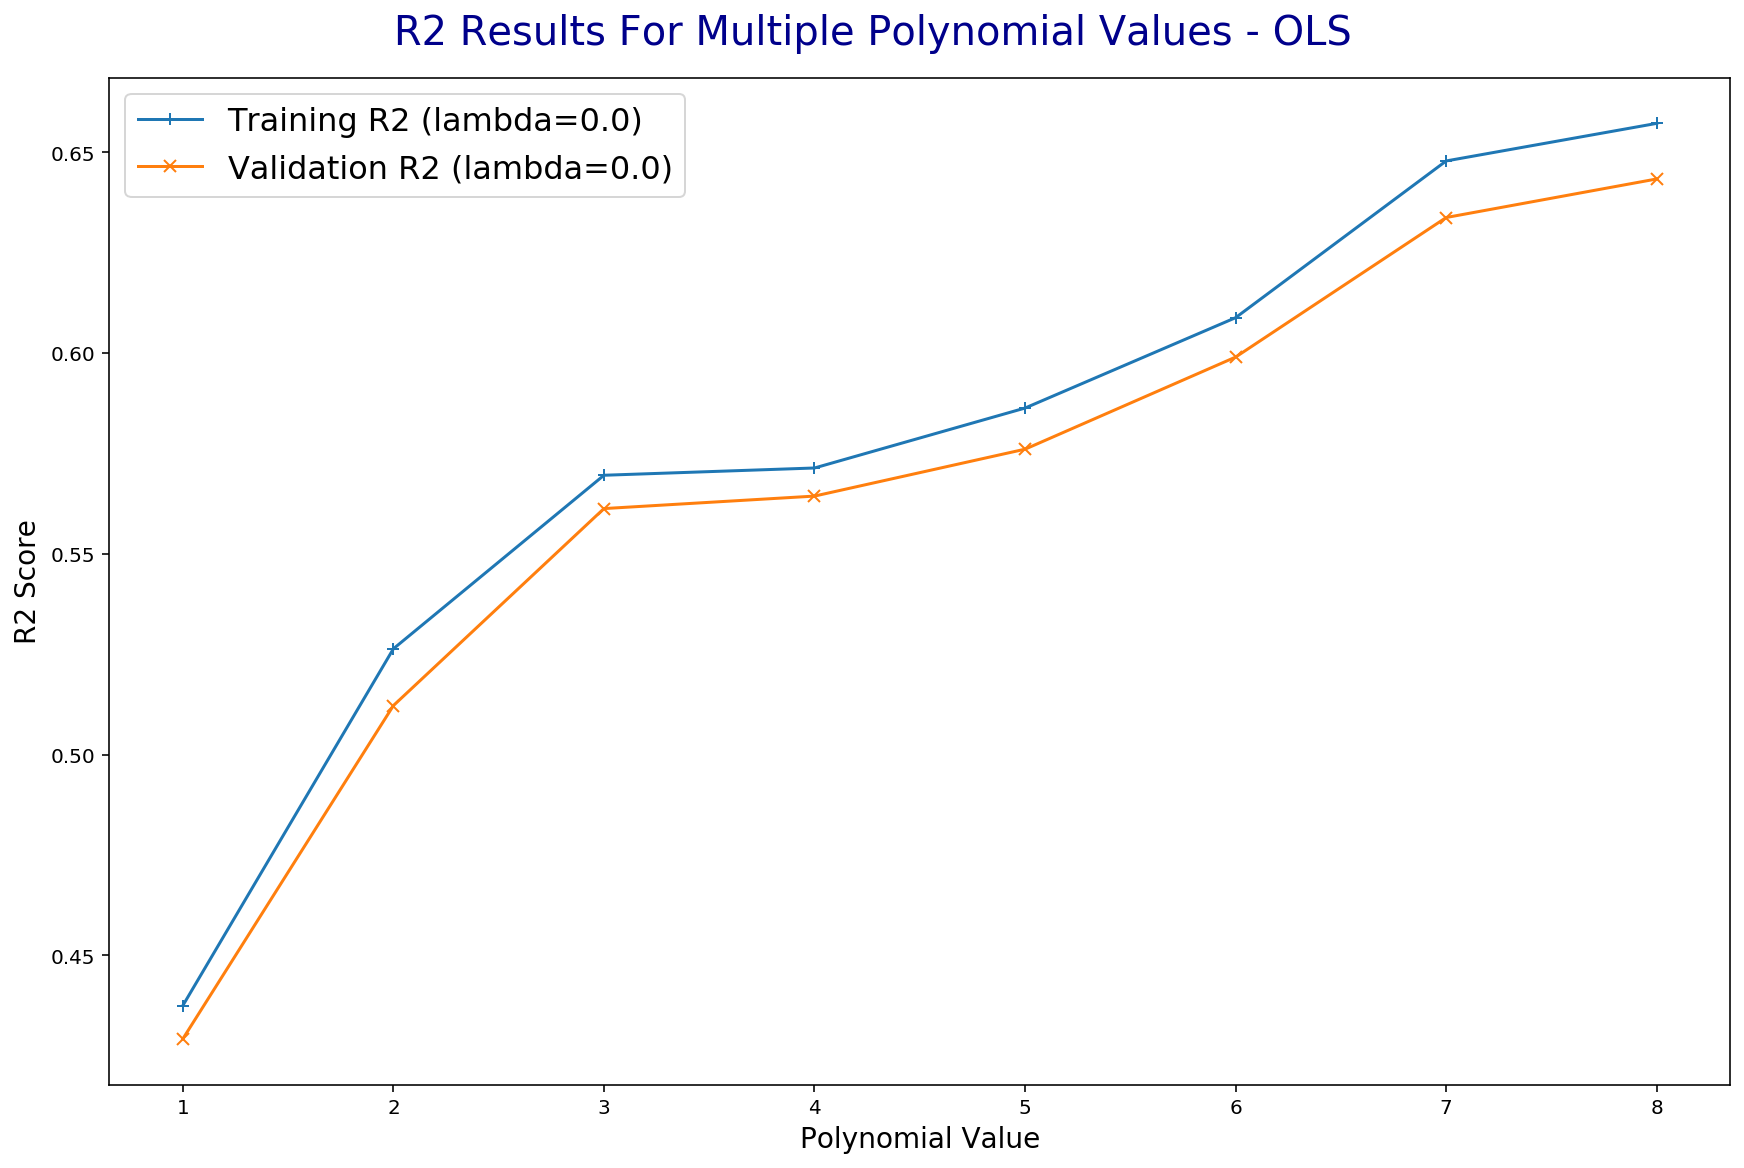

In [99]:
r2_reporting(fit_results, plot_train=True, plot_val=True, score_to_plot='R2', plot_model_types=['OLS'])

In [100]:
# Show charts from result
def plot_single_model(model_entry:pd.Series, 
                      train_set:pd.DataFrame, 
                      val_set:pd.DataFrame,
                      debug=False) -> None:
    """
    Plots the results of a single model including.
    """
    
    model = model_entry['model']
    library = 'scikit'
    if "statsmodels" in str(type(model)):
        library = 'statsmodels'

    x_train, y_train, x_val, y_val, x_scaler, y_scaler = get_design_mats(
            train_df=train_set, 
            val_df=val_set,  
            degree=model_entry['degree'], 
            target_col=model_entry['target_col'], 
            bad_columns=model_entry['bad_columns'],
            interactive_continuous=model_entry['cont_cols'],
            interactive_binaries=model_entry['binary_cols'],
            library=library,
            debug=debug
    )

    if debug:
        print("\ndef plot_single_model()")
        print("Model: ", str(type(model)))
        print("Library: ", library)
        print("num x_train cols: {}".format(len(x_train.columns)))
        print("x_train cols: \n\t{}".format(x_train.columns))
        try:
            print("num model cols: {}".format(len(model.params)))
        except:
            print("num model cols: {}".format(len(model.coef_)))
            

    # predict model
    predictions_train = model.predict(x_train)
    predictions_val = model.predict(x_val)
    
    # get residuals
#     return y_train, predictions_train
    residuals = np.array(y_train).reshape(-1) - np.array(predictions_train).reshape(-1)

    # plot predictions
    train_data = (x_train, y_train, predictions_train)
    test_data = (x_val, y_val, predictions_val)
    train_test_plots(train_data, test_data)

    # plot residuals
    plot_residuals(residuals, predictions_train, debug=debug)

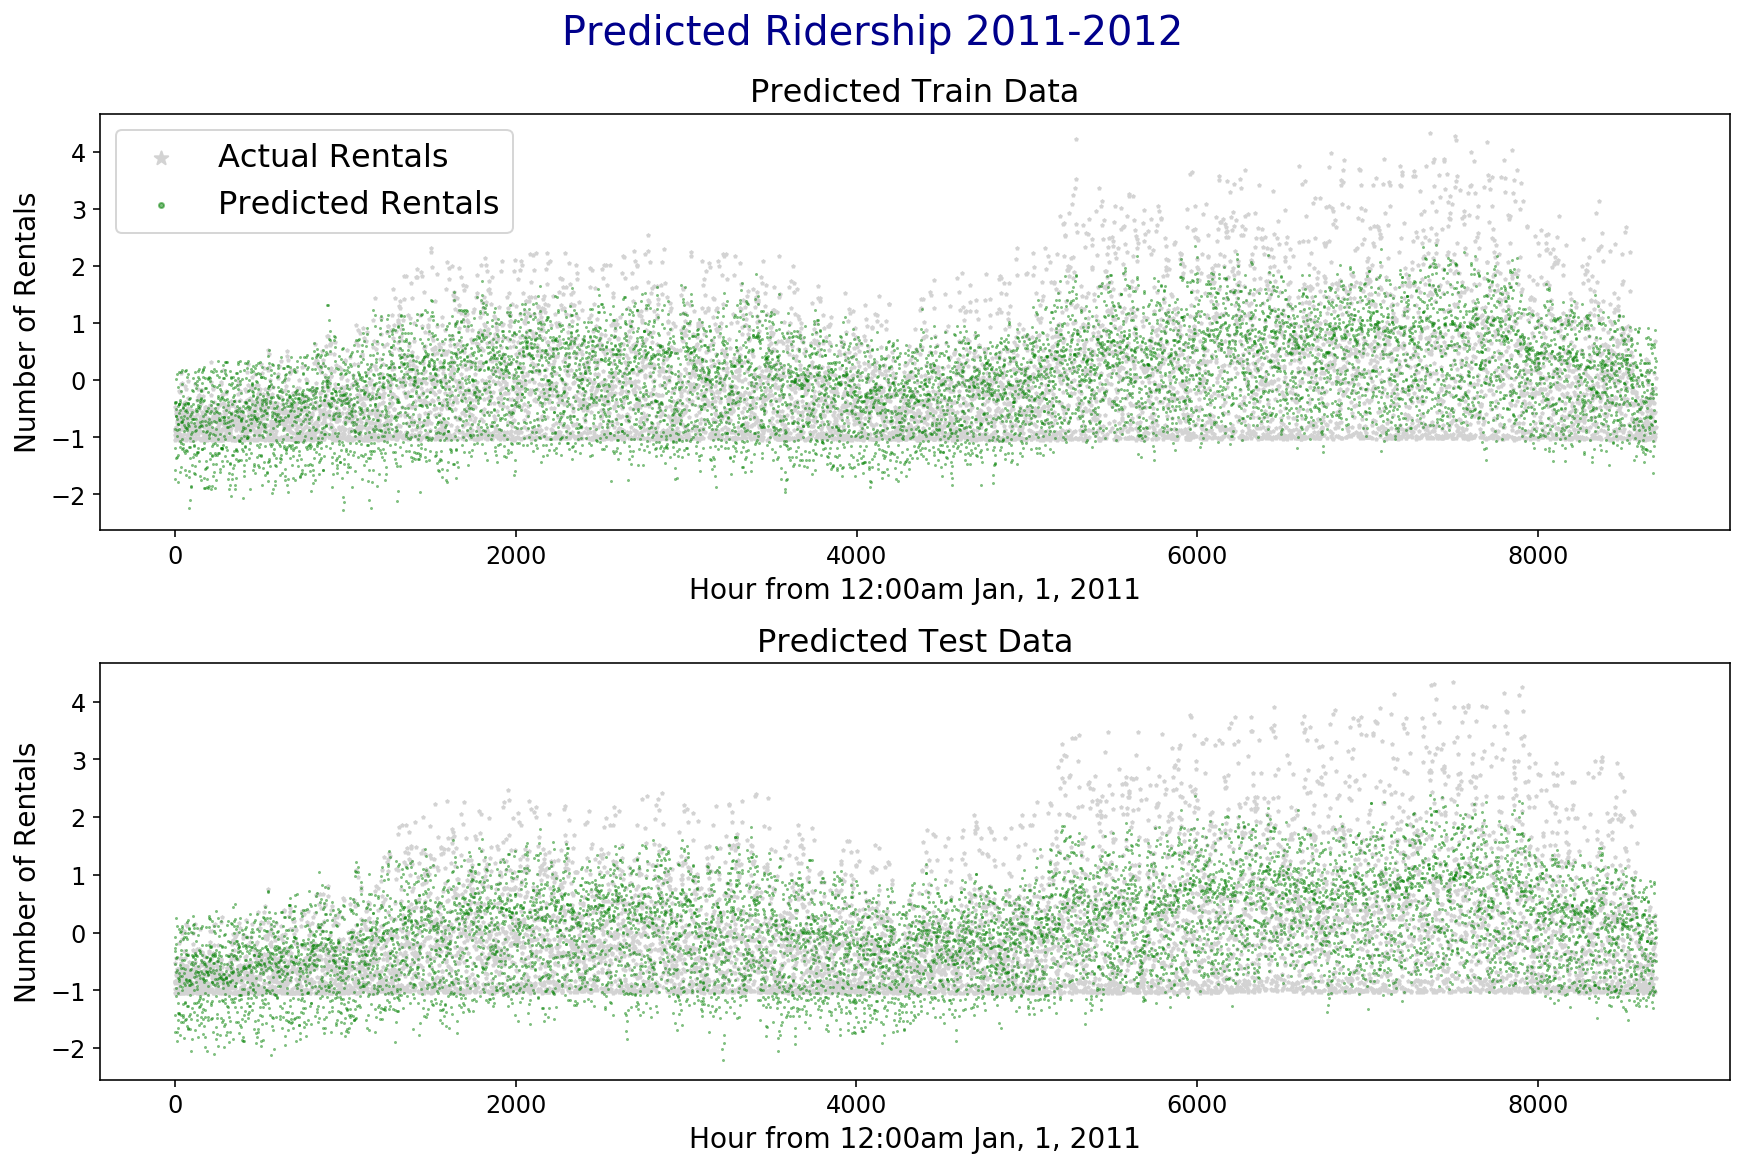

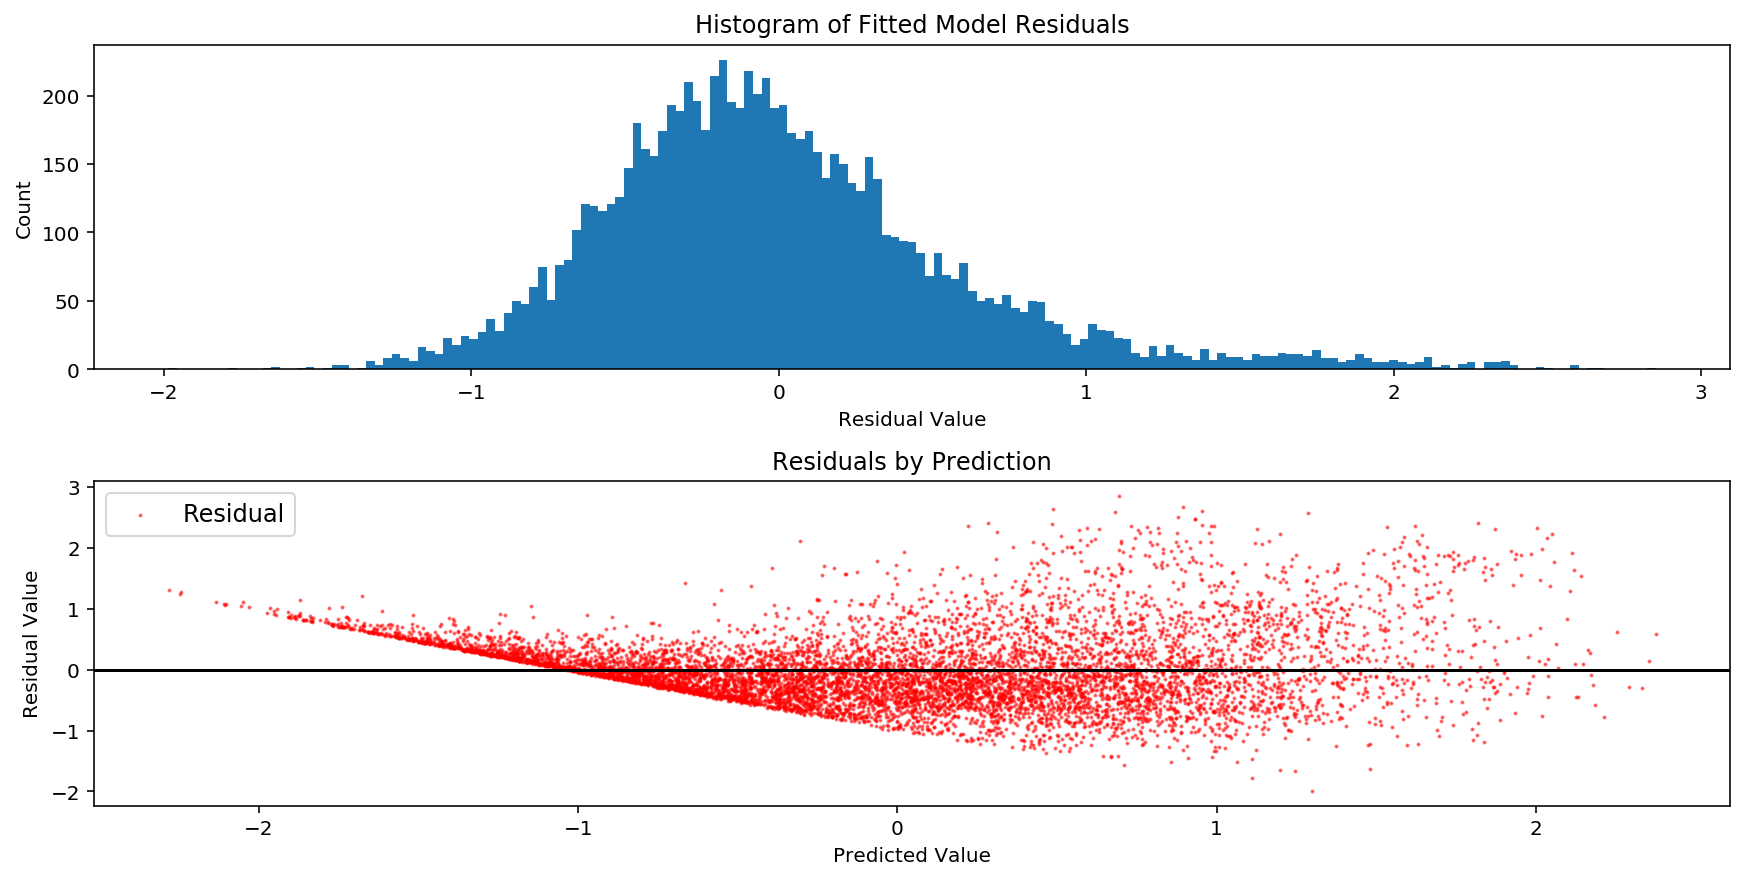

In [101]:
deg = 8.0
lambda_val = 0
ic = ['temp','hum', 'windspeed']
ib = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']
plot_model = fit_results[(fit_results['degree']==deg) & (fit_results['lambda_val']==lambda_val)].iloc[0]
plot_single_model(plot_model, 
                  train_set=BSS_train, 
                  val_set=BSS_test,
                  debug=False)

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

The model with polynomial 8 seems to perform best with the validation set.

Looking at the R2's as the polynomial value increases, we see a tendancy for the model to begine overfitting as the validation R2 value increases at a slower rate than the trianing set.  I would have expected more overfitting with such a high polynomial value.

Despite the identification of a model that performs best in this set of models, the model is still not performing so well.  This distribtion of residuals is still right-skewed and we can still observe a variance in the residual values that changes across the observations.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

In [102]:
# Re-read in data to ensure data set is clean
BSS_train = pd.read_csv('data/BSS_train.csv').sort_values(by=['dteday']).reset_index(drop=True)
BSS_test = pd.read_csv('data/BSS_test.csv').sort_values(by=['dteday']).reset_index(drop=True)


# Convert datetime column to datetime format
BSS_train.loc[:,'dteday'] = pd.to_datetime(BSS_train.loc[:,'dteday'])
BSS_test.loc[:,'dteday'] = pd.to_datetime(BSS_test.loc[:,'dteday'])

# insert a new series with the month so Jan is 1.
BSS_train.insert(2, "month", [y.month for y in BSS_train['dteday']] , False)
BSS_test.insert(2, "month", [y.month for y in BSS_test['dteday']] , False)

# drop_cols = ['dteday', 'workingday','atemp','spring','summer','fall']
drop_cols = ['dteday', 'workingday','spring','summer','fall']
try:
    BSS_train = BSS_train.drop(drop_cols, axis=1)
    BSS_test  = BSS_test.drop(drop_cols, axis=1)
except:
    print("Columns already removed: \n\t", drop_cols)

In [103]:
# your code here

# Split training set
xr_train, xr_val = train_test_split(BSS_train,
                                    test_size=.2, 
                                    random_state=90, 
                                    shuffle=True, 
                                    stratify=BSS_train['month'])

# drop month column - it was only used to stratify
xr_train = xr_train.drop('month', axis=1)
xr_val = xr_val.drop('month', axis=1)
BSS_train = BSS_train.drop('month', axis=1)
BSS_test = BSS_test.drop('month', axis=1)

In [104]:
# Build table of r2 values for each polynomial model 1-8
# Regularize each polyvalue model by lambdas of .01, .05, .1, .5, 1, 5, 10, 50, 100
lambdas = [.01, .05, .1, .5, 1, 5, 10, 50, 100]
target_col = 'counts' 
bad_columns = ['casual','registered','counts']
columns_forpoly = ['temp', 'hum', 'windspeed', 'hour']
ic = ['temp','hum', 'windspeed']
ib = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']

df_lambda_models = create_models(max_poly=8,
                                 train_set=xr_train,
                                 val_set=xr_val,
                                 lambdas=lambdas,
                                 bad_columns=bad_columns,
                                 columns_forpoly=columns_forpoly,
                                 interactive_continuous=ic,
                                 interactive_binaries=ib, 
                                 target_col=target_col,
                                 model_types=['ridge'],
                                 library='scikit',
                                 debug=True)


Beginning Model Creation
Response Variable: 
	 counts
Base Predictors: 
	 ['hour', 'holiday', 'year', 'temp', 'atemp', 'hum', 'windspeed', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
create_models(): library:scikit x_train columns: 78

Building OLS-Ridge Regularized model: 0.01 Columns:78
	Saved Model with polynomial: 1   lambda: 0.01/ridge

Building OLS-Ridge Regularized model: 0.05 Columns:78
	Saved Model with polynomial: 1   lambda: 0.05/ridge

Building OLS-Ridge Regularized model: 0.1 Columns:78
	Saved Model with polynomial: 1   lambda: 0.1/ridge

Building OLS-Ridge Regularized model: 0.5 Columns:78
	Saved Model with polynomial: 1   lambda: 0.5/ridge

Building OLS-Ridge Regularized model: 1.0 Columns:78
	Saved Model with polynomial: 1   lambda: 1/ridge

Building OLS-Ridge Regularized model: 5.0 Columns:78
	Saved Model with polynomial: 1   lambda: 5/ridge

Building OLS-Ridge Regul

In [105]:
display_cols = ['degree', 'lambda_val', 'model_type', 'R2_val']
listing = df_lambda_models[display_cols]
col_template = '%10s' '%10s'  '%10s' '%10s'
print(col_template % ("Polynomial", "Lambda", "ModelType", "R2 Val"))
for i, item in listing.iterrows():
    print(col_template % (item['degree'], item['lambda_val'], item['model_type'], np.round(item['R2_val'], decimals=3)))

Polynomial    Lambda ModelType    R2 Val
         1      0.01     ridge     0.415
         1      0.05     ridge     0.415
         1       0.1     ridge     0.415
         1       0.5     ridge     0.415
         1       1.0     ridge     0.416
         1       5.0     ridge     0.417
         1      10.0     ridge     0.417
         1      50.0     ridge     0.418
         1     100.0     ridge     0.417
         2      0.01     ridge     0.517
         2      0.05     ridge     0.517
         2       0.1     ridge     0.517
         2       0.5     ridge     0.517
         2       1.0     ridge     0.517
         2       5.0     ridge     0.518
         2      10.0     ridge     0.518
         2      50.0     ridge     0.518
         2     100.0     ridge     0.517
         3      0.01     ridge     0.579
         3      0.05     ridge     0.579
         3       0.1     ridge     0.579
         3       0.5     ridge     0.579
         3       1.0     ridge     0.579
         3      

**5.2** Find the best-scoring degree and regularization combination.

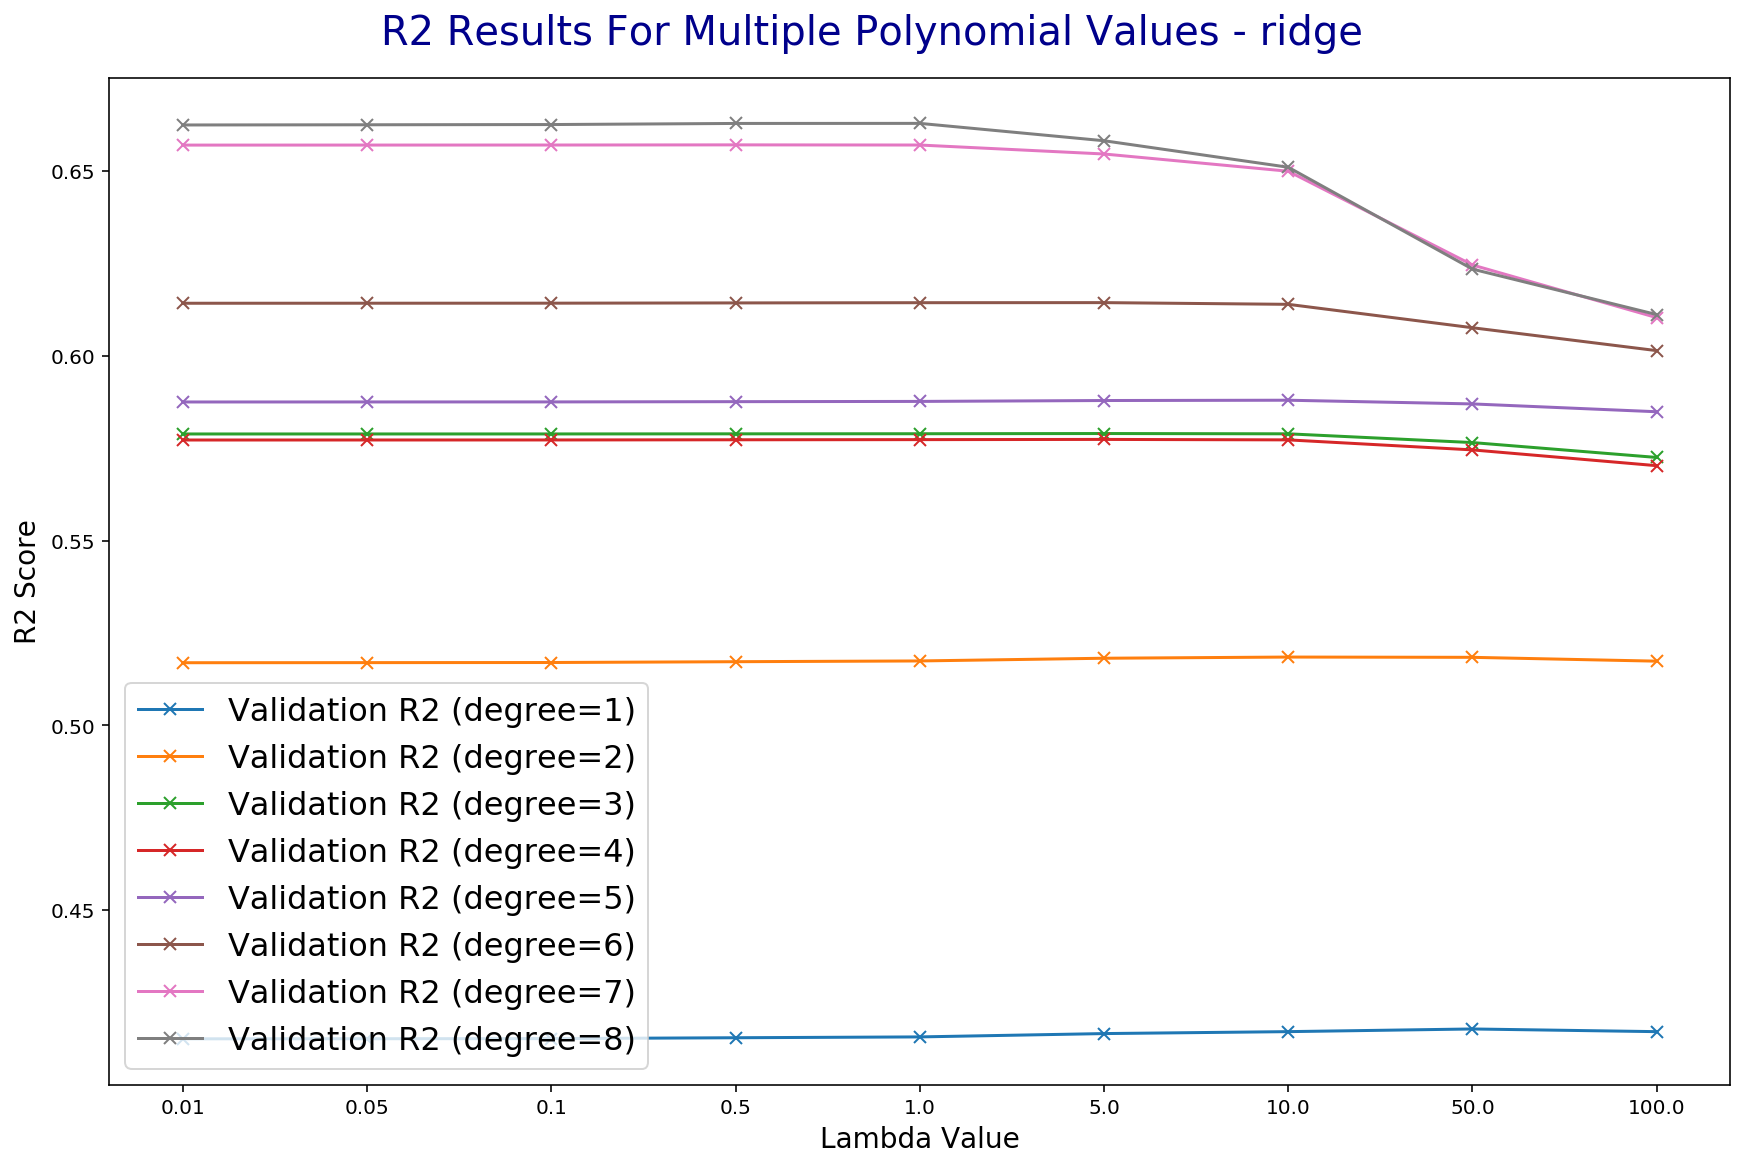

In [106]:
r2_reporting(df_lambda_models, 
             plot_train=False, 
             supress_table=True, 
             supress_chart=False, 
             invert_chart=True, 
             score_to_plot='R2',
             plot_model_types=['ridge'])

In [107]:
display_cols = ['degree', 'lambda_val', 'model_type', 'R2_val', 'MSE_val']

In [108]:
# Best scoring MSE value
df_lambda_models[df_lambda_models['MSE_val']==np.min(df_lambda_models['MSE_val'])][display_cols]

degree  lambda_val model_type    R2_val   MSE_val
67      8         1.0      ridge  0.662886  0.311299

In [109]:
# Check best scoring R2 value to confirm MSE result is reasonable
df_lambda_models[df_lambda_models['R2_val']==np.max(df_lambda_models['R2_val'])][display_cols]

degree  lambda_val model_type    R2_val   MSE_val
67      8         1.0      ridge  0.662886  0.311299

In [110]:
# The best MSE and R2 are the same model degree=8 / lambda=1.0
# Let's investigate degrees between 6 and 8 to see if there are nominal differences.

In [111]:
df_lambda_models[(df_lambda_models['degree']>=5) & (df_lambda_models['degree']<=8) & (df_lambda_models['lambda_val']==1.0)][display_cols]


degree  lambda_val model_type    R2_val   MSE_val
40      5         1.0      ridge  0.587655  0.380768
49      6         1.0      ridge  0.614366  0.356103
58      7         1.0      ridge  0.657027  0.316708
67      8         1.0      ridge  0.662886  0.311299

The improvement of using all 8 polynomials doesn't adds a significant improvement (>1%), so we will consider 7 the optimal polynomial value in order to minimize the complexity of the model a little.

**Selected Degree/Lamda Combination = Degrees=7 / Lambda=1.0  (note: best performing was degee 8)**

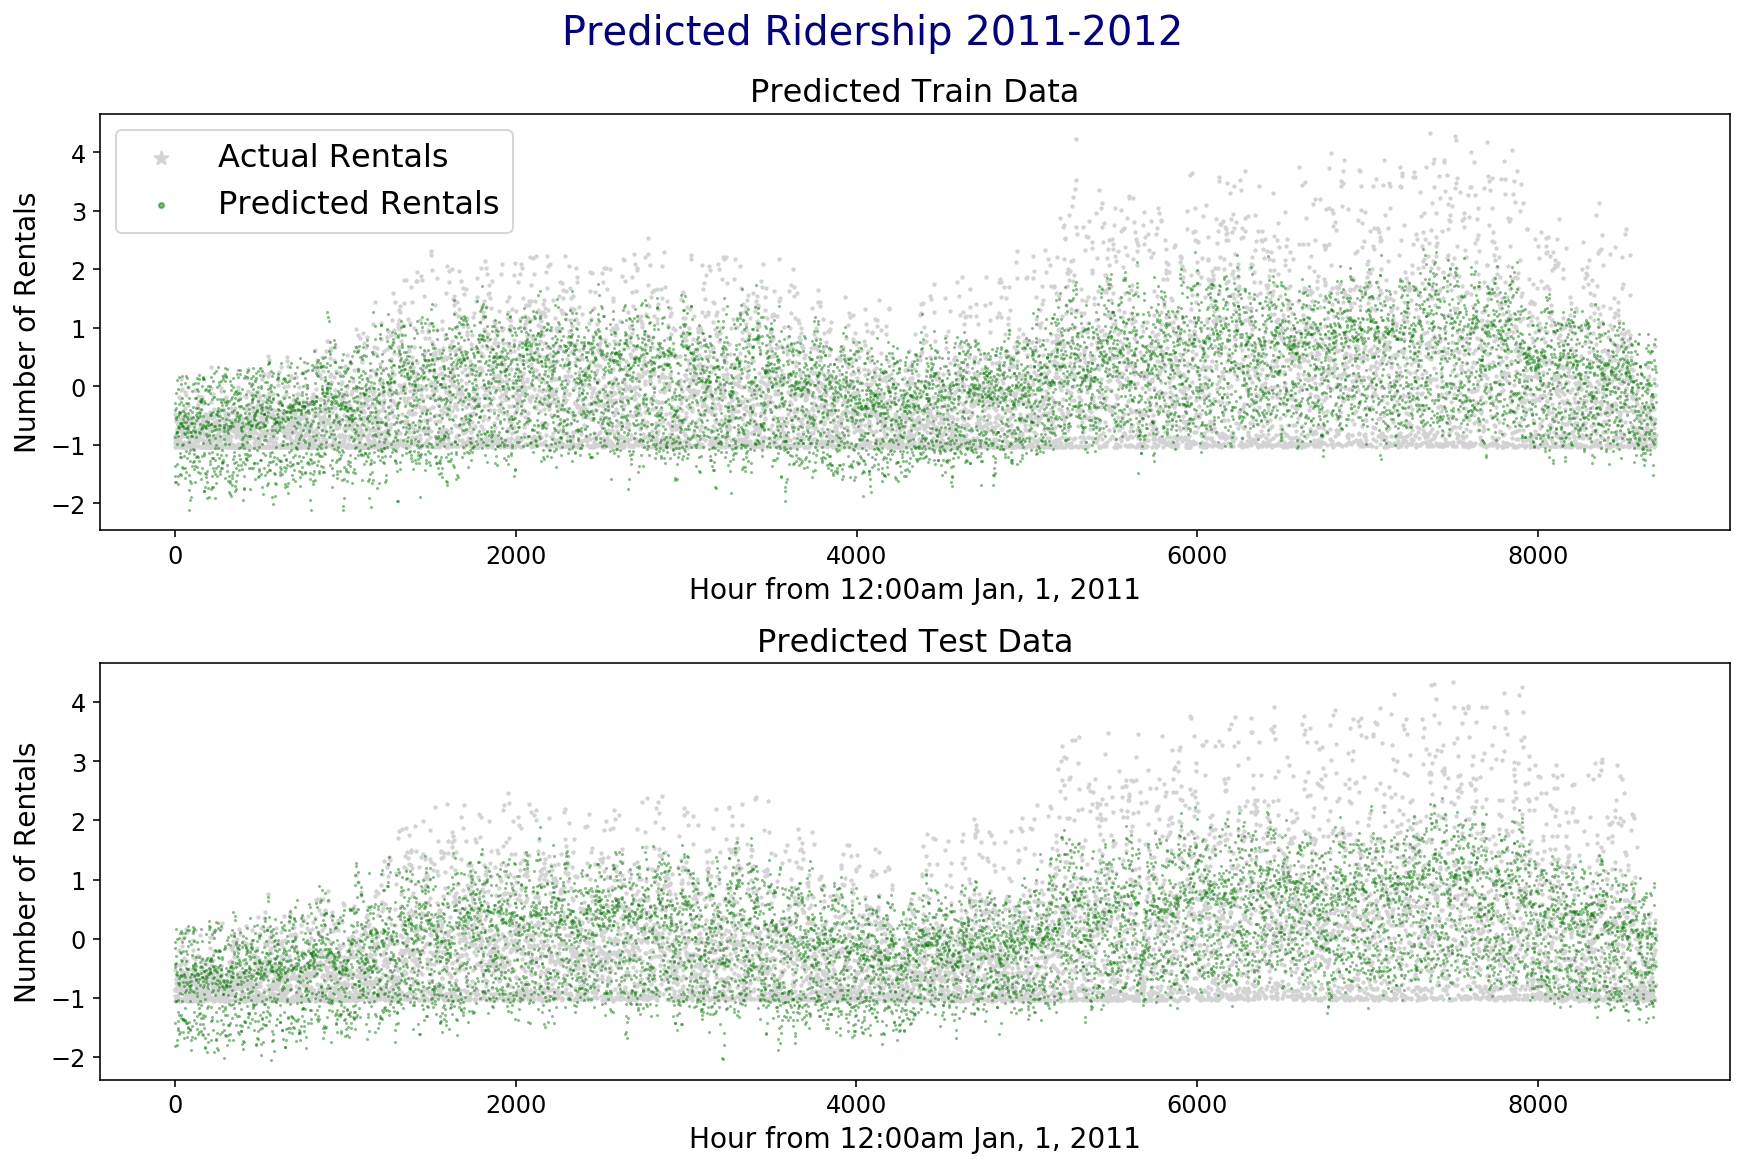

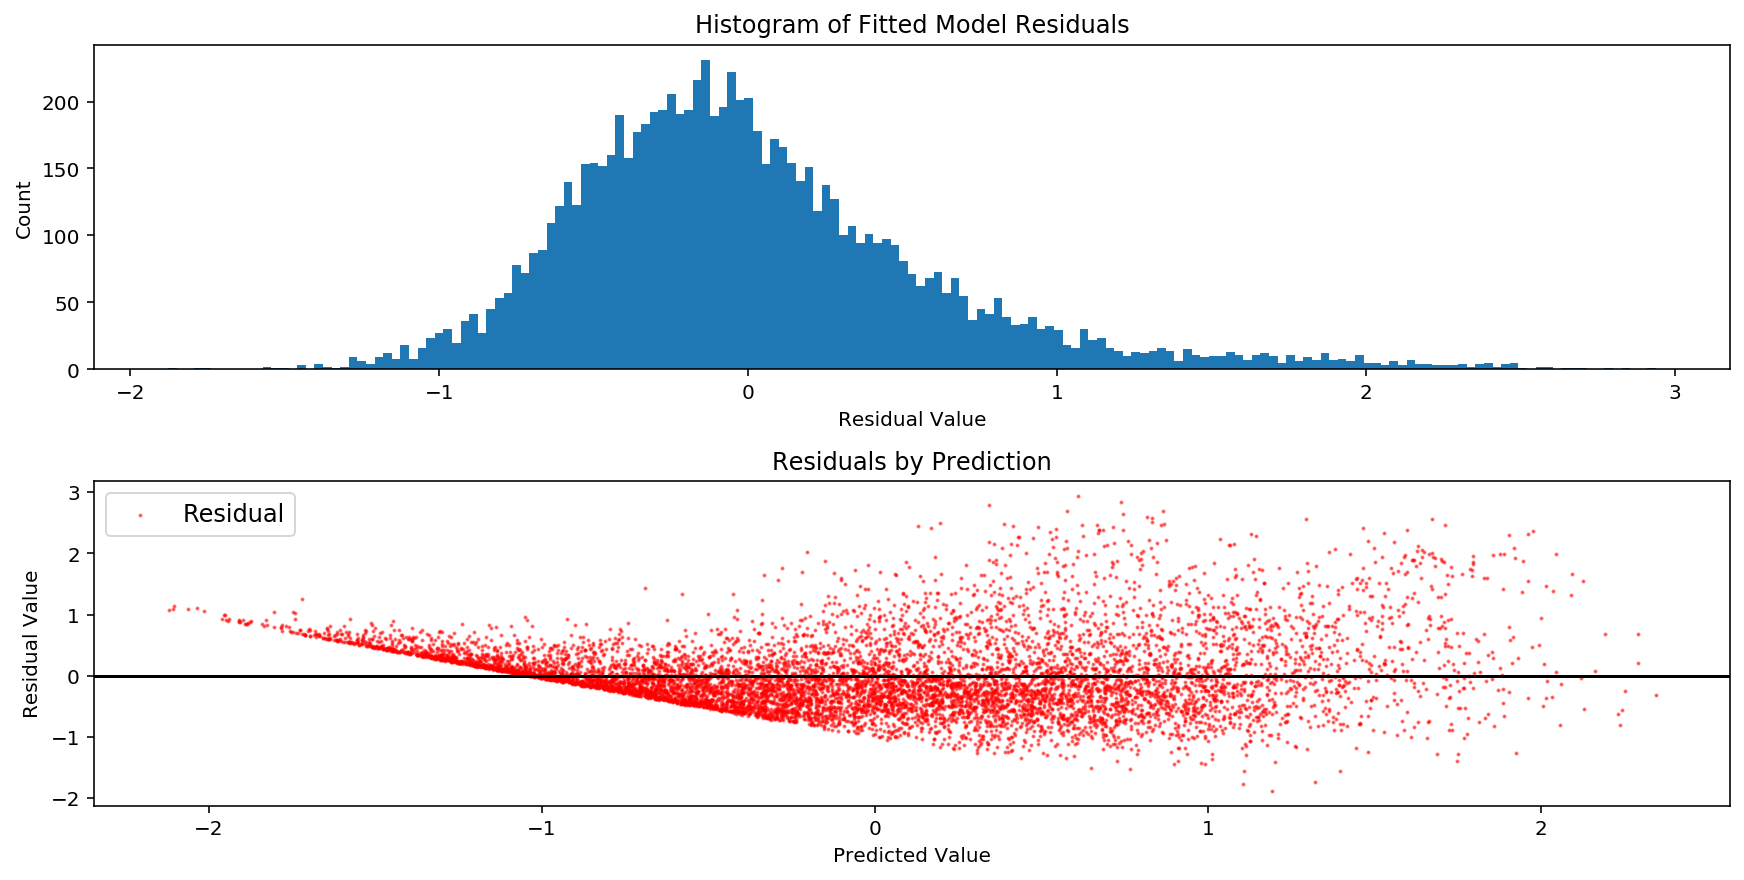

In [112]:
deg = 7.0
lambda_val = 1.0
df_model = df_lambda_models
best_model_entry = df_model[(df_model['degree']==deg) & (df_model['lambda_val']==lambda_val)].iloc[0]
plot_single_model(best_model_entry, 
                  train_set=BSS_train, 
                  val_set=BSS_test, 
                  debug=False)


Analyzing the distribution and residuals looks like the model is improving.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?


In [113]:
BSS_test.head()

hour  holiday  year  temp   atemp   hum  windspeed  casual  registered  \
0    19        0     0  0.42  0.4242  0.88     0.2537       6          31   
1     2        0     0  0.22  0.2727  0.80     0.0000       5          27   
2     9        0     0  0.32  0.3485  0.76     0.0000       8           6   
3    13        0     0  0.46  0.4545  0.72     0.2985      47          47   
4     5        0     0  0.24  0.2576  0.75     0.0896       0           1   

   counts  ...  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
0      37  ...    0    0    0    0    0    0    1       0     1      0  
1      32  ...    0    0    0    0    0    0    1       0     0      0  
2      14  ...    0    0    0    0    0    0    1       0     0      0  
3      94  ...    0    0    0    0    0    0    1       1     0      0  
4       1  ...    0    0    0    0    0    0    1       1     0      0  

[5 rows x 30 columns]

In [114]:
# Create an x_test and y_test set based on the best polynomial
poly = best_model_entry.degree
target_col = best_model_entry.target_col
bad_columns = best_model_entry.bad_columns
columns_forpoly = best_model_entry.columns_forpoly
ic = best_model_entry.cont_cols
ib = best_model_entry.binary_cols
x_scaler = best_model_entry.x_scaler
y_scaler = best_model_entry.y_scaler

In [115]:
poly

7

In [116]:
# Create test data sets for x and y using configuring options 
# By not supplying a val_df object, the function returns a test split between x and y.
x_test, y_test = get_design_mats(
            train_df=BSS_test, 
            degree=poly,
            columns_forpoly=columns_forpoly,
            target_col=target_col, 
            bad_columns=bad_columns,
            interactive_continuous=ic,
            interactive_binaries=ib,
            scale_data=True,
            library='scikit',
            x_scaler=x_scaler,
            y_scaler=y_scaler)

In [117]:
# get the trained and fitted model for our best result
best_model = best_model_entry['model']

# Get predictions based on the best model with the test data
test_predictions = best_model.predict(x_test)

In [118]:
# R2 for test data (calc with sklearn)
R2_test = r2_score(y_test, test_predictions)

print("R2 Test : ", np.round(R2_test , decimals=5))

R2 Test :  0.63348


**R2 dropped to .63 from .66**

I would expect the R2 to be similar or even a little lower just as happened.  Variations from the validation testing can be expected in one direction or another.

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

In [119]:
# your code here
lambdas = [.1,.5,1,5,10,50,100]
max_poly = 1
model_types = ['OLS', 'ridge', 'ridgeCV', 'lassoCV']

In [120]:
# Build table of r2 values for each polynomial model 1-8
target_col = 'counts' 
bad_columns = ['casual','registered','counts']
poly_cols = ['temp', 'hum', 'windspeed', 'hour']
ic = ['temp','hum', 'windspeed']
ib = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat']

df_lambda_models = create_models(max_poly=max_poly,
                                 train_set=xr_train,
                                 val_set=xr_val,
                                 lambdas=lambdas,
                                 bad_columns=bad_columns,
                                 columns_forpoly=poly_cols,
                                 interactive_continuous=ic,
                                 interactive_binaries=ib, 
                                 target_col=target_col,
                                 model_types=model_types,
                                 debug=True)


Beginning Model Creation
Response Variable: 
	 counts
Base Predictors: 
	 ['hour', 'holiday', 'year', 'temp', 'atemp', 'hum', 'windspeed', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']
create_models(): library:statsmodels x_train columns: 79

Building OLS model using statsmodels.  Columns: 79
	Saved Model with polynomial: 1   lambda: 0.0/OLS

Building OLS-Ridge Regularized model: 0.1 Columns:79
	Saved Model with polynomial: 1   lambda: 0.1/ridge

Building OLS-Ridge Regularized model: 0.5 Columns:79
	Saved Model with polynomial: 1   lambda: 0.5/ridge

Building OLS-Ridge Regularized model: 1.0 Columns:79
	Saved Model with polynomial: 1   lambda: 1/ridge

Building OLS-Ridge Regularized model: 5.0 Columns:79
	Saved Model with polynomial: 1   lambda: 5/ridge

Building OLS-Ridge Regularized model: 10.0 Columns:79
	Saved Model with polynomial: 1   lambda: 10/ridge

Building OLS-Ridge Regulari

In [121]:
display_cols = ['degree', 'lambda_val', 'model_type', 'R2_train', 'R2_val', 'MSE_train', 'MSE_val']

In [122]:
df_lambda_models[display_cols]

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
0      1         0.0        OLS  0.440387  0.415182   0.559613  0.540034
1      1         0.1      ridge  0.440386  0.415250   0.559614  0.539971
2      1         0.5      ridge  0.440368  0.415483   0.559632  0.539756
3      1         1.0      ridge  0.440326  0.415709   0.559674  0.539547
4      1         5.0      ridge  0.439880  0.416609   0.560120  0.538716
5      1        10.0      ridge  0.439430  0.417134   0.560570  0.538231
6      1        50.0      ridge  0.436806  0.417856   0.563194  0.537564
7      1       100.0      ridge  0.434117  0.417130   0.565883  0.538235
8      1         0.1    lassoCV  0.320215  0.326012   0.679785  0.622375
9      1         1.0    ridgeCV  0.440326  0.415709   0.559674  0.539547

In [123]:
# Check best scoring R2 value - RIDGE
m_type = 'ridge'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['R2_val']==np.max(subset_models['R2_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
6      1        50.0      ridge  0.436806  0.417856   0.563194  0.537564

In [124]:
# Check best scoring MSE value - RIDGE
m_type = 'ridge'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['MSE_val']==np.max(subset_models['MSE_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train   R2_val  MSE_train   MSE_val
1      1         0.1      ridge  0.440386  0.41525   0.559614  0.539971

In [125]:
# Check best scoring R2 value - RIDGECV
m_type = 'ridgeCV'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['R2_val']==np.max(subset_models['R2_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
9      1         1.0    ridgeCV  0.440326  0.415709   0.559674  0.539547

In [126]:
# Check best scoring MSE value - RIDGECV
m_type = 'ridgeCV'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['MSE_val']==np.max(subset_models['MSE_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
9      1         1.0    ridgeCV  0.440326  0.415709   0.559674  0.539547

In [127]:
# Check best scoring R2 value - LASSOCV
m_type = 'lassoCV'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['R2_val']==np.max(subset_models['R2_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
8      1         0.1    lassoCV  0.320215  0.326012   0.679785  0.622375

In [128]:
# Check best scoring MSE value - LASSOCV
m_type = 'lassoCV'
subset_models = df_lambda_models[df_lambda_models['model_type']==m_type]
subset_models[(subset_models['MSE_val']==np.max(subset_models['MSE_val']))][display_cols]
                                                                                     

degree  lambda_val model_type  R2_train    R2_val  MSE_train   MSE_val
8      1         0.1    lassoCV  0.320215  0.326012   0.679785  0.622375

The best regularization levels (via MSE) are:

Ridge = 0.1 (note: Using R2 resulted in best lambda of 50.0)

RidgeCV = 1.0

LassoCV = 0.1


**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

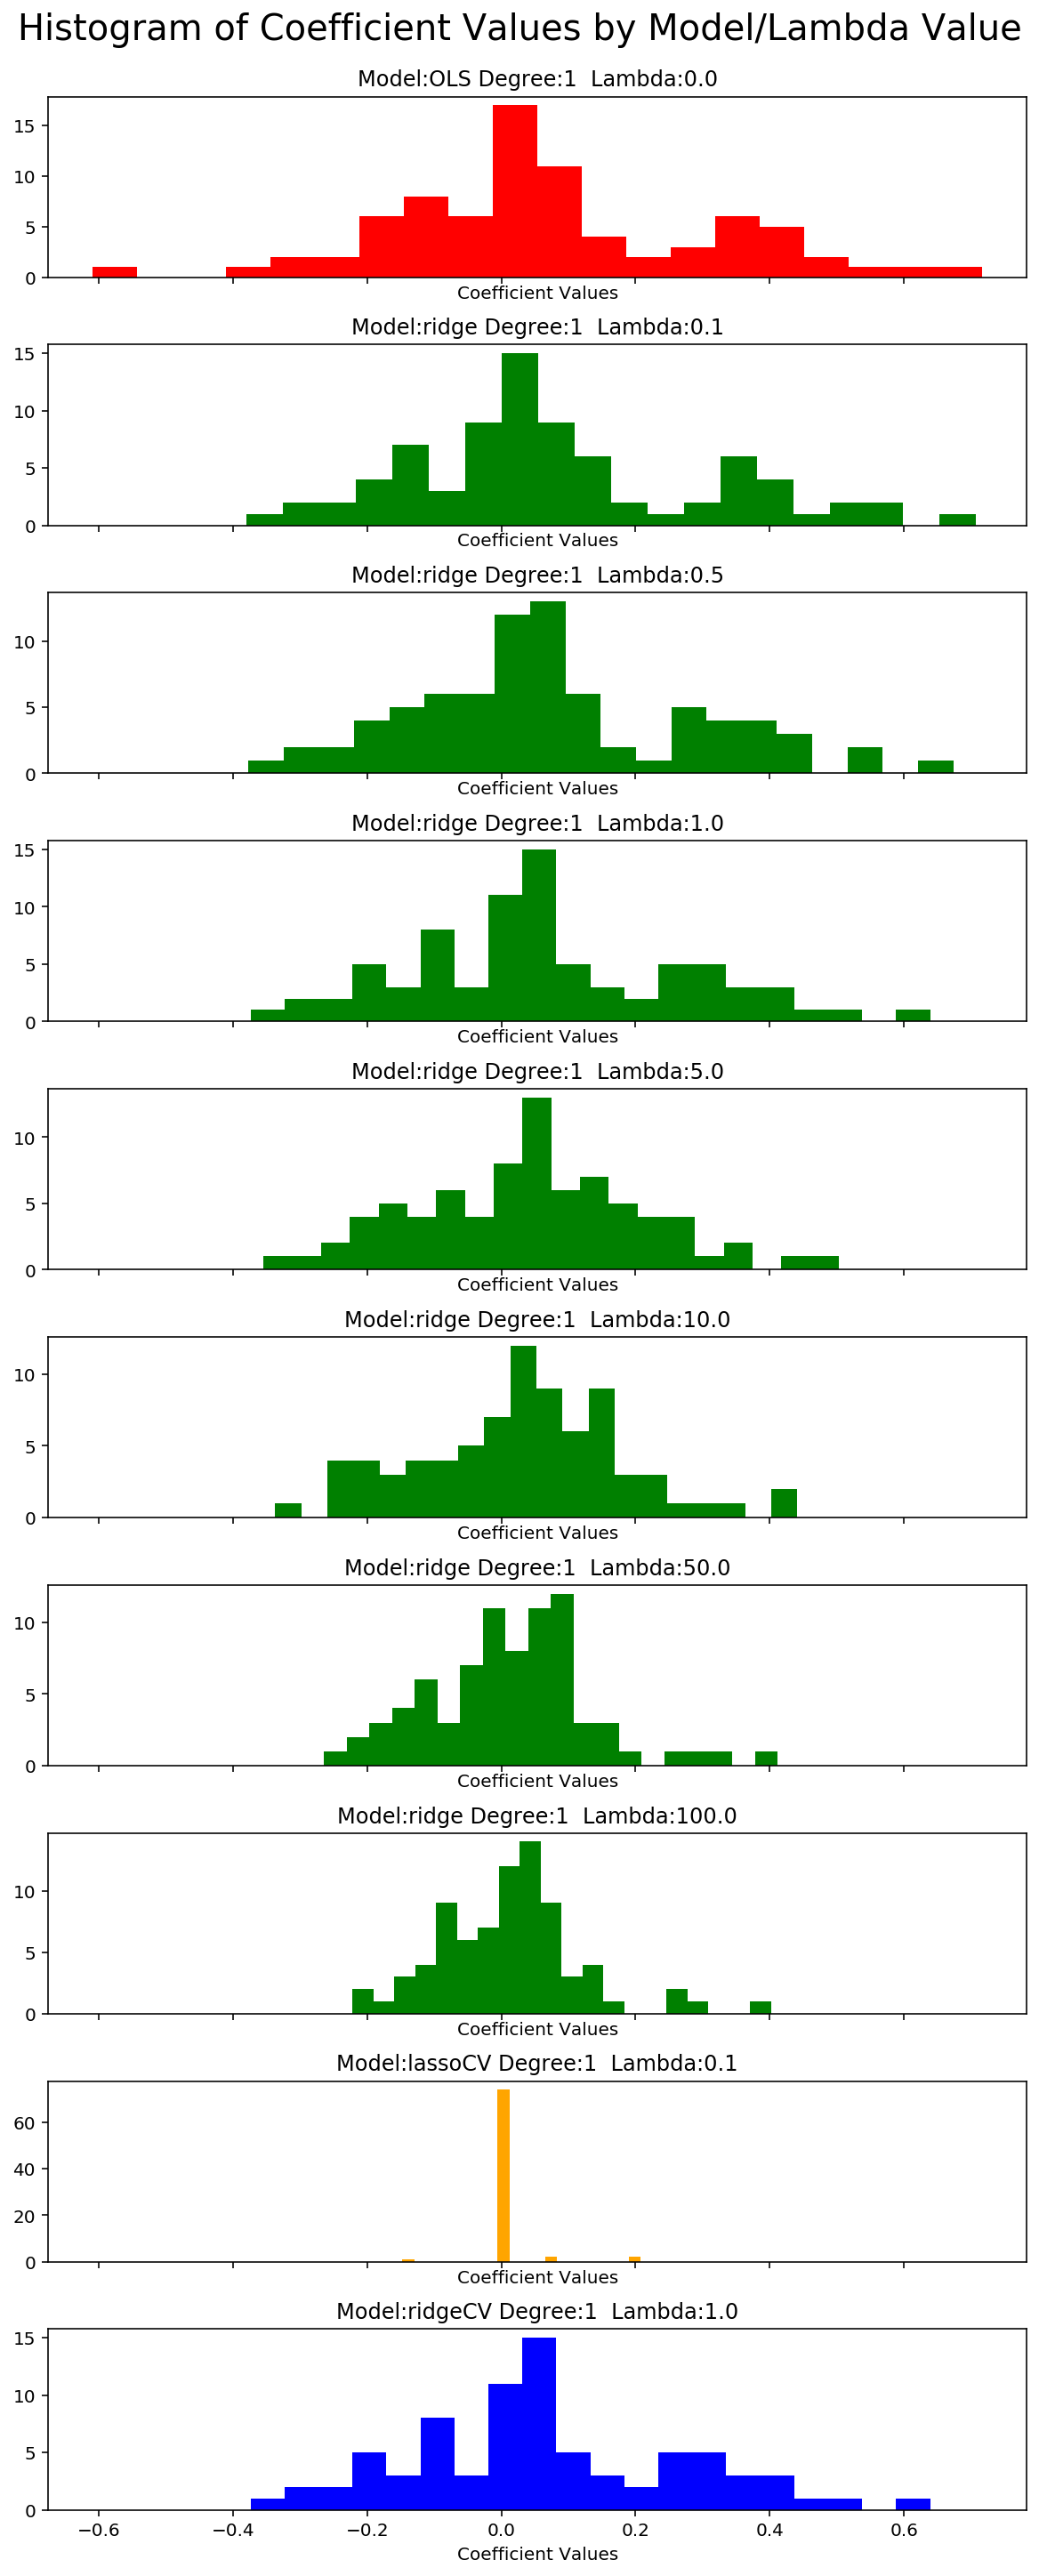

In [129]:
# your code here
# Histogram Plots

plot_model_types = ['OLS', 'ridge', 'ridgeCV', 'lassoCV']

model_entries = df_lambda_models
fig, subplots = plt.subplots(nrows=len(model_entries), figsize=(8,20), constrained_layout=True, sharex=True, sharey=False)
fig.suptitle("Histogram of Coefficient Values by Model/Lambda Value", fontsize=20)

for i, m_type in enumerate(plot_model_types):
    
    for i, model_entry in model_entries.iterrows():
        
        m_type = model_entry.model_type
        
        colors = ['red', 'green', 'blue', 'orange']
        color = colors[plot_model_types.index(m_type)]
        bins = 20
        
        if m_type=='OLS':
            subplots[i].hist(model_entry.model.params, density=False, color=color, bins=bins)
        elif m_type=='lassoCV':
            subplots[i].hist(model_entry.model.coef_, density=False, color=color, bins=bins)
        else:            
            subplots[i].hist(model_entry.model.coef_[0], density=False, color=color, bins=bins)
        subplots[i].set_title("Model:{} Degree:{}  Lambda:{}".format(m_type, model_entry.degree,model_entry.lambda_val))
        subplots[i].set_xlabel("Coefficient Values")


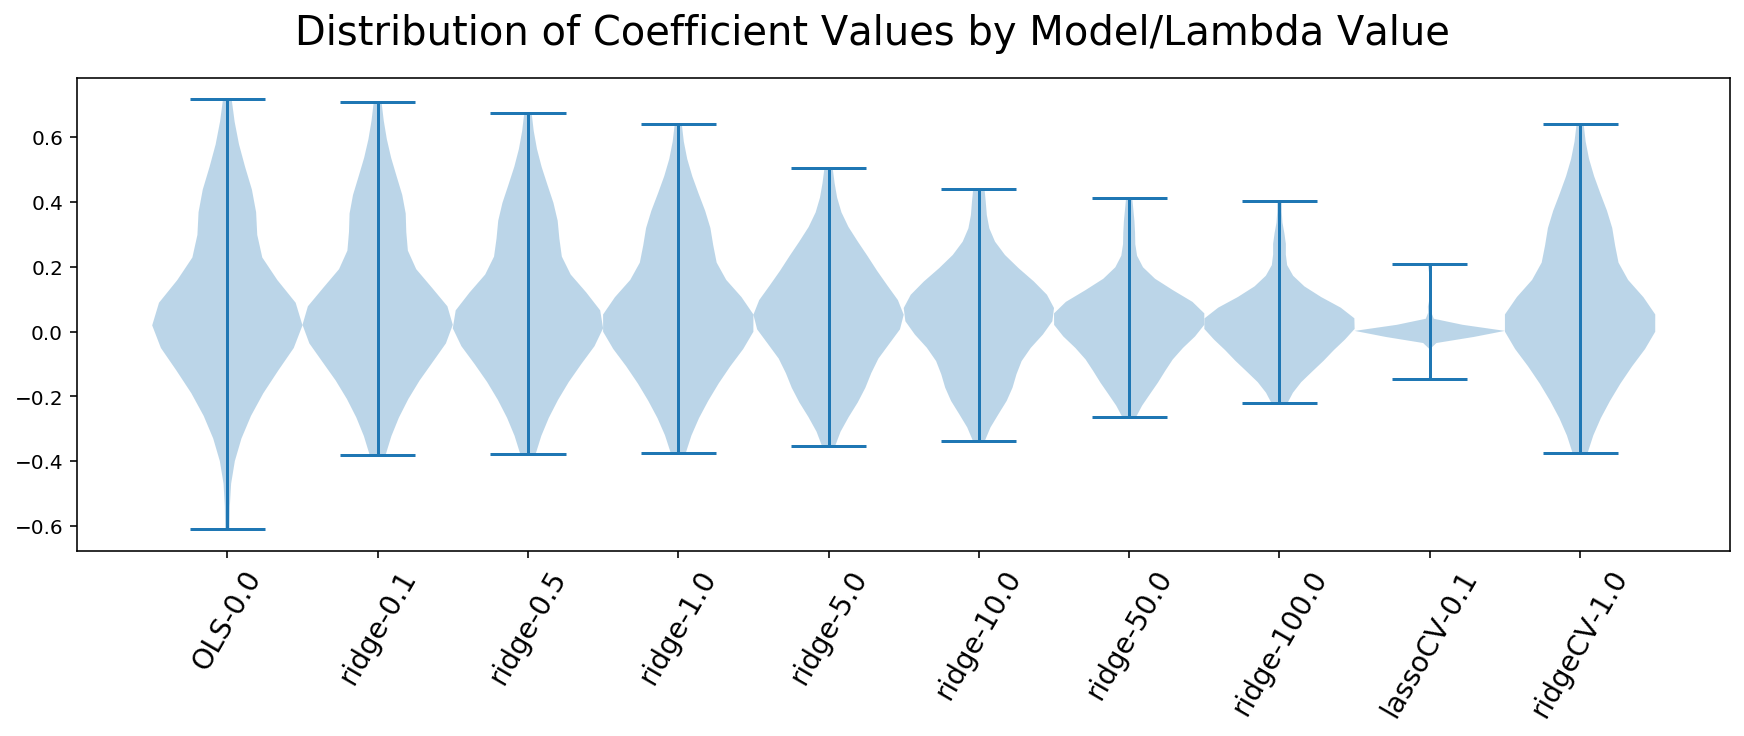

In [130]:
# Violin plots

plot_model_types = ['OLS', 'ridge', 'ridgeCV', 'lassoCV']
colors = ['red', 'green', 'blue', 'orange']

model_entries = df_lambda_models
fig, subplots = plt.subplots(nrows=1, figsize=(12,5), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("Distribution of Coefficient Values by Model/Lambda Value", fontsize=20)

data = []
labels = []
for i, model_entry in model_entries.iterrows():

    if model_entry.model_type not in plot_model_types:
        continue

    m_type = model_entry.model_type
    labels.append('-'.join([m_type, str(model_entry.lambda_val)]))
    color = colors[plot_model_types.index(m_type)]
    
    # get list of coeficients
    if m_type=='OLS':
        data.append(model_entry.model.params)
    elif m_type=='lassoCV':
        data.append(model_entry.model.coef_)
    else:
        data.append(model_entry.model.coef_[0])    
        
subplots.violinplot(data, range(0,len(labels)), points=20, widths=1)
subplots.set_xticks(range(0,len(labels)))
subplots.set_xticklabels(labels, rotation=60, fontsize=14);


**5.5 Answer**

The most evident trend is the 'ridge' trend where each increase in lambda moves the coefficients closer to 0 and the deviation becomes smaller.  Aditionally, the 'ridge' models loses a bi-modal character as the lambda value increases (this may be dataset-specific).

The optimal LassoCV model finds a grouping of coeficients that are close to 0 with much smaller deviation than RidgeCV.  Despite such a small lambda, it is still very effective in compressing the range of coeficient values.  This is expected from a Lasso model and is a characteristic that can also be used for feature selection.  

The optimal RidgeCV model still has a large deviation and looks very similar to the non-CV ridge model at 1.0 lambda.  There is a small bi-model tendancy, but this may just be the result of our particular data set.

I was a little surprised at how extreme the LassoCV model responded to such a small lambda penalty.

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

In [131]:
# your code here
# Create a dataset that includes the coeficient values for each model and model_type
# Use for reporting

plot_model_types = ['OLS', 'ridge', 'lassoCV', 'ridgeCV']

df_coefs = pd.DataFrame()

model_type = 'OLS'
model = df_lambda_models[(df_lambda_models['model_type']==model_type)]['model'][0]
df_OLS = pd.DataFrame(data=model.params, columns=['param_val'])
constant_col = pd.Series([model_type for x in range(0,len(df_OLS))], name='model_type', index=df_OLS.index)
lambda_col = pd.Series([lambda_val for x in range(0,len(df_OLS))], name='lambda_val', index=df_OLS.index)
df_coefs = pd.concat([constant_col, lambda_col, df_OLS], axis=1)

model_type = 'ridge'
# get unique lambda values
lambda_vals = np.unique(df_lambda_models[(df_lambda_models['model_type']==model_type)]['lambda_val'])
# for each lambda_value, get the model and make table
for lambda_val in lambda_vals:
    model = df_lambda_models[(df_lambda_models['model_type']==model_type) & (df_lambda_models['lambda_val']==lambda_val)]['model'].reset_index(drop=True)[0]
    df_ridge = pd.DataFrame(data=model.coef_[0], columns=['param_val'], index=df_OLS.index)
    constant_col = pd.Series([model_type for x in range(0,len(df_ridge))], name='model_type', index=df_OLS.index)
    lambda_col = pd.Series([lambda_val for x in range(0,len(df_ridge))], name='lambda_val', index=df_OLS.index)
    df_ridge = pd.concat([constant_col, lambda_col, df_ridge], axis=1)
    df_coefs = pd.concat([df_coefs, df_ridge])
    
model_type = 'lassoCV'
model = df_lambda_models[(df_lambda_models['model_type']==model_type)]['model'].iloc[0]
df = pd.DataFrame(data=model.coef_, columns=['param_val'], index=df_OLS.index)
constant_col = pd.Series([model_type for x in range(0,len(df))], name='model_type', index=df_OLS.index)
lambda_col = pd.Series([model.alpha_ for x in range(0,len(df))], name='lambda_val', index=df_OLS.index)
df = pd.concat([constant_col, lambda_col, df], axis=1)
df_coefs = pd.concat([df_coefs, df])

model_type = 'ridgeCV'
model = df_lambda_models[(df_lambda_models['model_type']==model_type)]['model'].iloc[0]
df = pd.DataFrame(data=model.coef_[0], columns=['param_val'], index=df_OLS.index)
constant_col = pd.Series([model_type for x in range(0,len(df))], name='model_type', index=df_OLS.index)
lambda_col = pd.Series([model.alpha_ for x in range(0,len(df))], name='lambda_val', index=df_OLS.index)
df = pd.concat([constant_col, lambda_col, df], axis=1)
df_coefs = pd.concat([df_coefs, df])


In [132]:
# Plot selected coeficient values by model type

def plot_coefs(df_coefs:pd.DataFrame, coef_vals:[]=None, num_coefs:int=5):
    """
    Create a plot of barcharts for each coeficient
    comparing the coeficient value for various models.
    """
    if coef_vals is None:
        coef_vals = df_OLS.index[0:num_coefs]
        
    # remove incorrect columns
    iter_vals = coef_vals.copy()
    for c in iter_vals:
        if c not in df_coefs.index:
            coef_vals.remove(c)

    num_vals = len(coef_vals)

    fig, ax = plt.subplots(nrows=num_vals, ncols=1, figsize=(5,1+num_vals*2), sharex=True, sharey=True, constrained_layout=True)
    fig.suptitle("Coeficient Values by Model Type and Lambda Value", fontsize=16)

    for i, coef_val in enumerate(coef_vals):

        plot_data = df_coefs.loc[coef_val]
        plot_data["name"] = ['-'.join((x.model_type, str(x.lambda_val))) for i,x in plot_data.iterrows()]

        # set colors
        colors = []
        for n in plot_data.name:
            if 'OLS' in n:
                colors.append('blue')
            elif 'ridgeCV' in n:
                colors.append('orange')
            elif 'lassoCV' in n:
                colors.append('red')
            elif 'ridge' in n:
                colors.append('green')

        if len(coef_vals)==1:
            showax = ax

        else:
            showax = ax[i]

        showax.bar(x=plot_data.name, height=plot_data.param_val, color=colors, width=.5)
        showax.set_xticklabels(labels=plot_data.name, rotation=60);
        showax.set_title("{}".format(coef_val))
        showax.axhline(0, color='black')


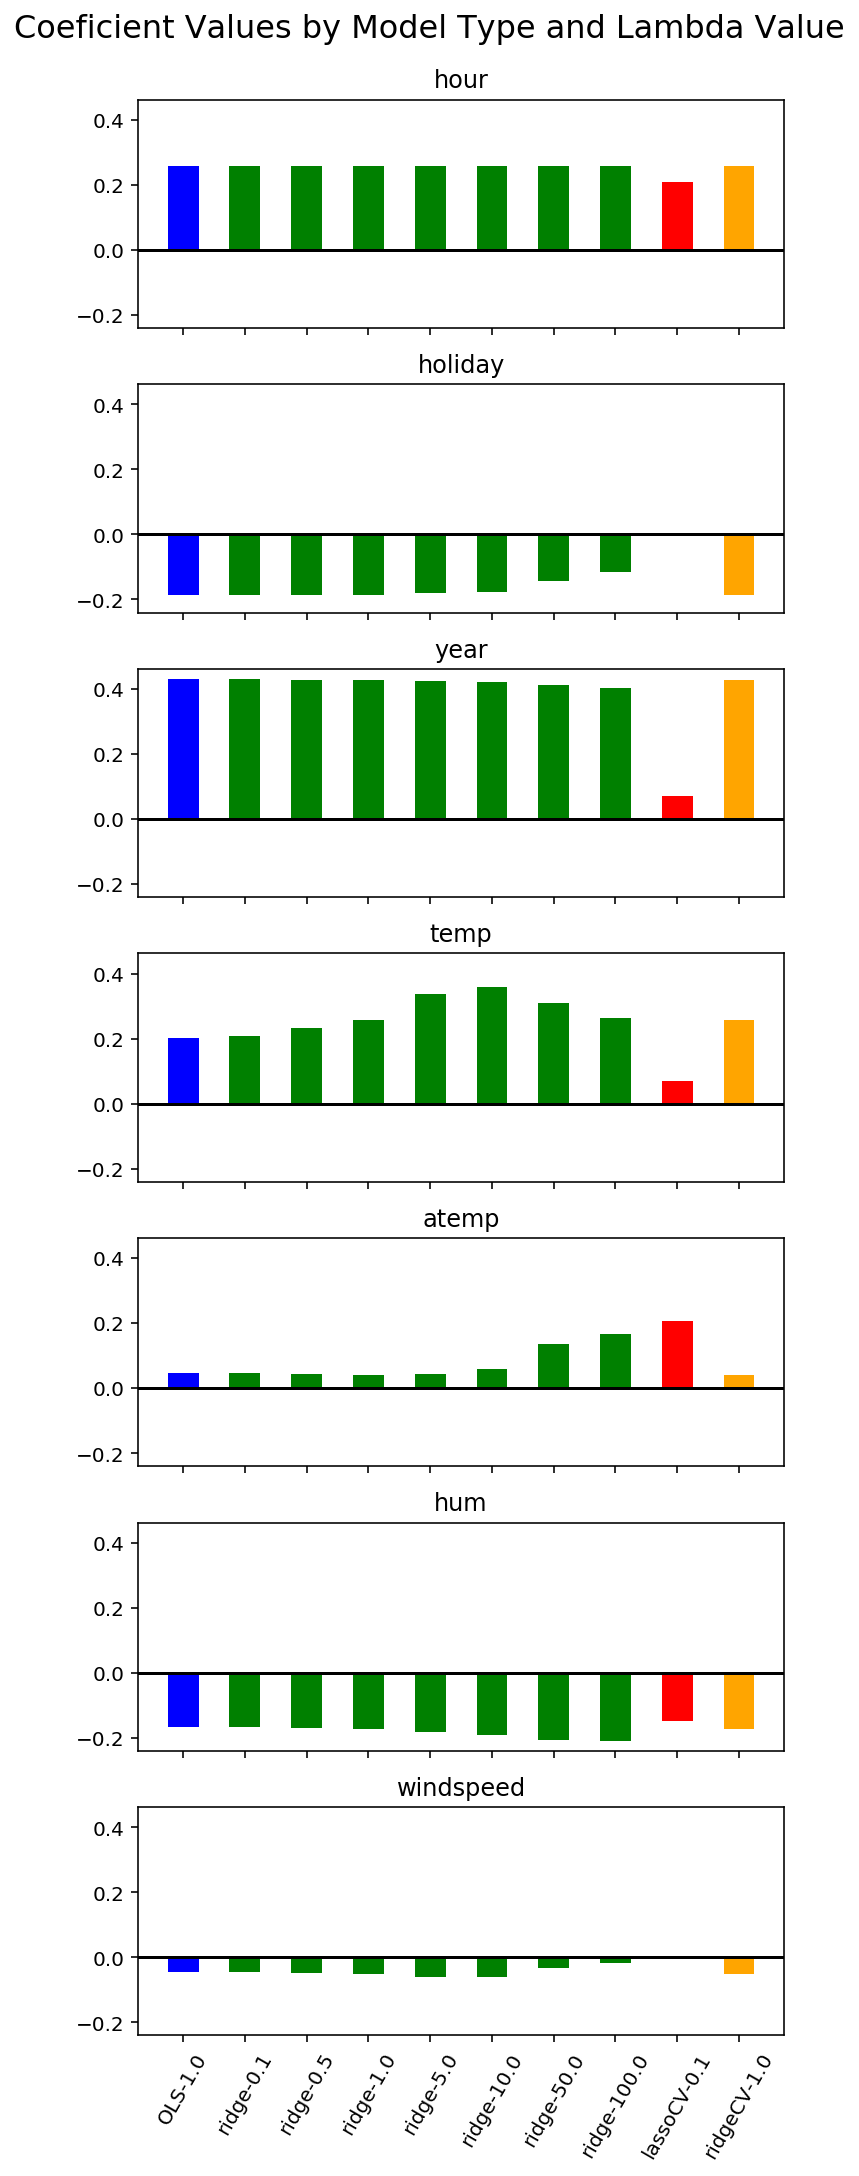

In [133]:
# Constant Variables
coef_vals = df_OLS.index[1:8]
plot_coefs(df_coefs=df_coefs, coef_vals=coef_vals)

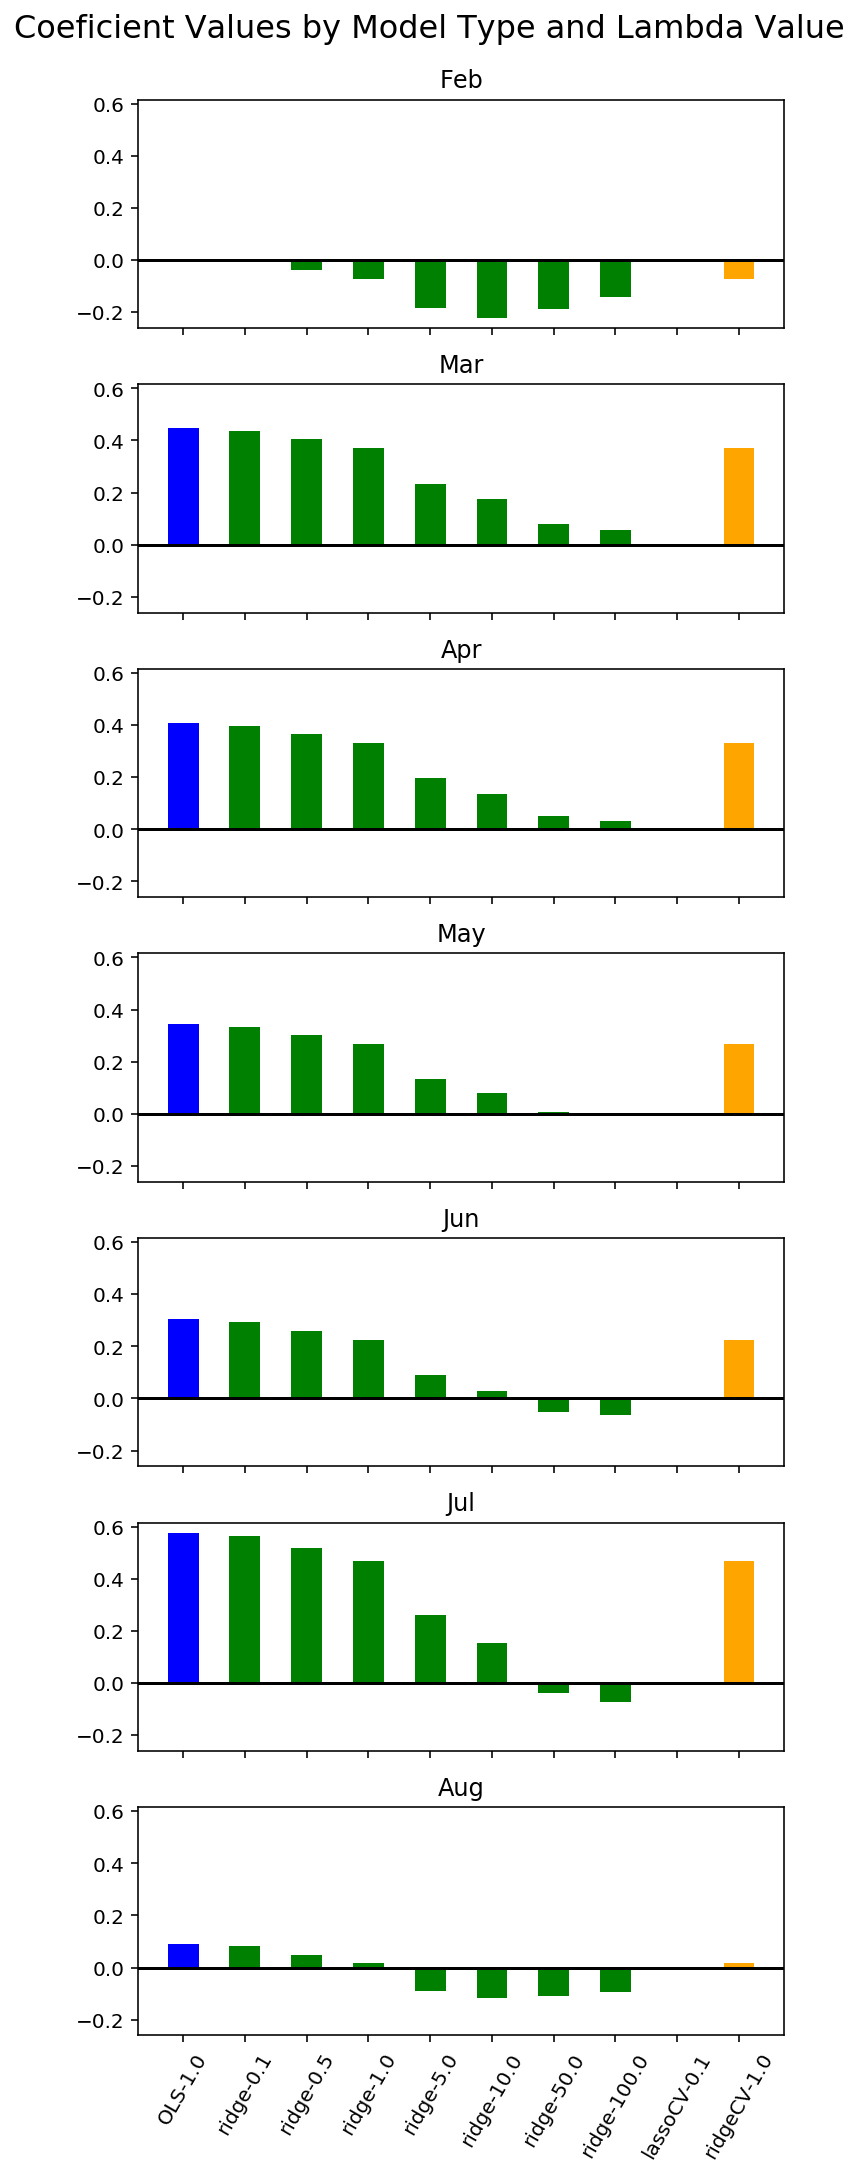

In [134]:
# Dummy variables
coef_vals = df_OLS.index[8:15]
plot_coefs(df_coefs=df_coefs, coef_vals=coef_vals)

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

*your answer here*

NOTE: We had previously removed 'atemp', but I added it back in for this question.

Here we can see how extreme Lasso can be about removing features by setting coeficients to 0.  Several selected points above have 0 values in the Lasso model.  Lasso seems to be setting the dummary variables to 0 while keeping the continuous variables.

The non-CV ridge model seems to slowly reduce the impact of the dummary variables as lambdas increase while maintaining a relatively similar magnitude for the continuous variables at each lambda level.  As the non-CV ridge model increases Lambda, it seems to perform the same variable selection as Lambda does, but only with a much higher penalty level.

Temp and aTemp were handled differently despite thier corelation with one another.  Emphasis for all models was placed on the Temp variable.  In this case, it seems like the models are auto-removing colinear variables by reducing their impact on the result.  Interestingly, Lasso did something similar.  Lasso emphasized aTemp over Temp and Humidity.  Lasso seems to be removing colinearity but is keeping the single important variable rather than the 2 variables that Ridge is selecting.  Another plus for Lasso.

It may be worth noting that the lasso model performed most poorly compared to all the others.  Perhaps, by increasing the polynomials, we may achieve better results; however, in our exercise above, regularizing with Lasso negatively impacted the model.

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*your answer here*

Using a get_design_mats() function is imperative.  Using this ensures that you are making consistent creations of your training, validation and testing data sets.  Without such a function, you are forced to recreate the dataset manually leaving large room for error.

By copying and pasting, you create repeated code that needs to be simulataneously maintained when making corrections or modifications.  You also risk inconsistencies in how datasets used on the same model are created.  Usually, you'll get some kind of dimensionality error, but in the worst-case, you won't and you'll have mis-aligned data sets that you aren't aware of.

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

*your answer here*

Costs:

Ridge and Lasso are more computationally expensive.  In our p-set, this wasn't a problem, but if your dataset has millions of cross-validated records, the time to compute can become excessive.  

Benefits:

Using regularization will reduce the weight that individual coeficients have on the predicted value.  This benefit is most evident in the predicted values of outlier variable values.  Using the CV processes returns a best perfming model based on a number of validation tests.  If you pick a model based on one validation set, you may be picking a model that works well on that one validation set and may behave differently with a different set.  This is the primary benefit that comes at the expense of computation time.

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*your answer here*

If you are simply given a set of variables to use in a prediction, I suppose that there isn't much to interpret; however, I could imagine that the questions are a little more precise.  For instance, "if the expected warm-front comes in on Sunday and the temperature is going to be 85, what is the expected ridership?".  Now, interpretability is important.  I need to know ridership for a date and temperature and possibly how much that ridership will change if the temperature is different.  

If the models predicted well, but the coeficient values didn't make sense, I wouldn't really know if the prediction was lucky or based on some kind of logical result.  If the prediction was right, I may be happy, but still worried about the next prediction because I wasn't really sure why my prediction was correct.

The need for interprestability is more apperent when the model fails.  It becomes impossible to answer why it failed.  Your model will immediately lose credibility.

In short, interpretability matters, and it matters a lot!

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?

*your answer here*

In am not entirely sure that my models are working correctly.  I am not really happy with any of them and would not put any into production.  I feel that they may be predicting trends, but not accurate daily values.  With negative predictions and predictions failing to predict peak values, I may be comfortable to isolate a time that is likely to have reduced ridership but only as long as there are no extreme circumstances (e.g. - unusual weather or events).

If I had to pick a best model, I would pick the OLS model with polynomial and interactive columns.  I tried the regularization models with 8 polynomials and had simlar results to the OLS model.  The calculation time penalty for regularization added little benefit.  The OLS coeficients are more interpretable as well.  From the p-set example, the data didn't seem to be driving extremely large coeficient values, so perhaps the benefits of regularization were not evident.

In order to make the model better, I would consider the data that I am using and take a closer look at whether or not additional data points may be useful, such as sporting events, concerts, conventions, etc.  I would also consider registered vs. casual riders.  Which is driving the variability for which events?  Registreed riders can be expected to drive variability during hours of the day and working days, but I got some impression from the data that casual riders were more impacted by weather.  If you know days that have heavy casual ridership, you will better be able to understand and predict ridership based on weather.  Understanding the casual riders that are from out-of-town would be beneficial when predicting trends on days when there will be a large number of visitors in town.  Perhaps including numerical data that reflects the number of out-of-town visitors on certain days would be helpful (the local Chamber of Commerce may have this information available).

One other thing to consider is that the first year has differnt usage levels than the second year, probably due to marketing or just being around for longer.  This could be keeping the model from predicitng some of the larger values.  Perhaps training the model on the second year only may offer some benefit for future predictions.